# Alzheimers-Classification 

# Imports

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline as sklearnPipeline
from sklearn.model_selection import RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier

# Functions

In [70]:
def check_for_nulls_dupes(df):
  print(f"The amount of Null Values: {df.isna().sum()}")
  print(f"The amount of Duplicated Values {df.duplicated().sum()}")

def check_class_imbalance(target):
  unique, counts = np.unique(target, return_counts=True)
  
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.xlabel("Target Class Breakdown")
  plt.ylabel("Counts")
  plt.show()

def create_heatmap(df):
  
  plt.figure(figsize=(15, 8))
  sns.heatmap(df, annot=True, cmap='coolwarm')
  plt.title('Heatmap of Selected Columns')
  plt.show()

def plot_distribution(df, kind):
  
  for col in df.columns:
    plt.figure(figsize=(10, 7))
    sns.histplot(df[col], kde=True) if kind == "Hist" else plt.boxplot(df[col])
    plt.title(f"Distribuition of {col}")
    plt.ylabel("Counts")
    plt.show()
  
def aggregate_dataset(df, interested_columns, agg_col, function):
  
  for col in interested_columns:
    grouped_df = getattr(df.groupby(agg_col)[col], function)().reset_index(name=col)
    plt.figure(figsize=(12, 8))
    sns.barplot(data=grouped_df, x=agg_col, y=col)
    plt.title(f"Agg of {col}")
    plt.ylabel(col)
    plt.xticks(rotation =45)
    plt.show()

def create_sklearn_pipeline(model):
  
  return sklearnPipeline(steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("Model", model)
  ])

def create_pipeline(sample_model, model, kbest=None):
  
  steps = [
    ("Scaler", StandardScaler()),
    ("PowerTransformer", PowerTransformer()),
    ("Sample", sample_model),
    ("Model", model)
  ]
  
  if kbest:
    steps.insert(2, (kbest))
  return Pipeline(steps=steps)

def pca_analysis(X):
  
  features = range(1, X.shape[1]+1)
  metric_tracker = []
  for component in features:
    pca = PCA(n_components=component)
    pipeline = create_sklearn_pipeline(pca)
    X_pca = pipeline.fit_transform(X)
    cumsum = np.sum(pca.explained_variance_ratio_)
    
    metric_tracker.append(
      {
        "Component": component,
        "CumSum": cumsum
      }
    )
  
  performance_df = pd.DataFrame(metric_tracker)
  plt.figure(figsize=(12, 8))
  plt.title("PCA Analysis")
  sns.barplot(data=performance_df, x="Component", y="CumSum")
  plt.xlabel("Components")
  plt.ylabel("CumSum")
  plt.show()
  print(performance_df)

def grab_selected_models(names):
  
  models = {
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "DUMMY": DummyClassifier(strategy="uniform")
  }
  
  return [models[model_name] for model_name in names]

def get_metrics(y, predictions):
    acc_metric = accuracy_score(y, predictions)
    recall_metric = recall_score(y, predictions, average='weighted')
    precision_metric = precision_score(y, predictions, average='weighted')
    f1_metric = f1_score(y, predictions, average='weighted')
    
    return [acc_metric,recall_metric, precision_metric, f1_metric]

def evaluate_model(model, X, y, metric):
  
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10,random_state=1)
  scores = cross_val_score(model, X, y, cv=cv, scoring=metric, n_jobs=-1)
  preds = cross_val_predict(model, X, y, n_jobs=-1, cv=10)
  acc, recall_metric, precision_metric, f1_metric = get_metrics(y, preds)
  
  return [
    round(np.mean(scores),3), 
    round(np.var(scores), 3), 
    round(np.std(scores),3), 
    round(acc,3), 
    round(recall_metric,3),
    round(precision_metric,3),
    round(f1_metric,3)
  ]

def test_kbest_columns(X, y, sample_model, model, model_name, kbest):
  
  metric_tracker = []
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)
  for k in range(1, X.shape[1]+1):
    metric = SelectKBest(score_func=kbest, k=k)
    pipeline = create_pipeline(sample_model, model, metric)
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc, recall_metric, precision_metric, f1_metric = get_metrics(y_test, y_pred)

    metric_tracker.append({
        "Model": model_name,
        "K":k,
        "acc_metric": acc,
        "f1_metric": f1_metric,
        "recall":recall_metric,
        "precision":precision_metric
      })
  
  return pd.DataFrame(metric_tracker)

def test_selected_models(sample_model, model_names, models, X, y, scoring_metric, kbest=None):
  
  metric_tracker = []
  
  for model, model_name in zip(models, model_names):
    pipeline = create_pipeline(sample_model, model, kbest) if kbest else create_pipeline(sample_model, model) 
    scores = evaluate_model(pipeline, X, y, scoring_metric)
    metric_tracker.append({
      "Model": model_name,
      "Mean": scores[0],
      "Var": scores[1],
      "STD": scores[2],
      "Test-Acc":scores[3],
      "recall-Score":scores[4],
      "precision-Score":scores[5],
      "F1-Score":scores[6]
    })
  
  performance_df = pd.DataFrame(metric_tracker).sort_values(by="Mean", ascending=False)
  print(performance_df)

# EDA Analysis

In [15]:
df = pd.read_csv("/Users/maukanmir/Downloads/alzheimers_disease_data.csv")
df

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,6895,61,0,0,1,39.121757,0,1.561126,4.049964,6.555306,...,0,0,4.492838,1,0,0,0,0,1,XXXConfid
2145,6896,75,0,0,2,17.857903,0,18.767261,1.360667,2.904662,...,0,1,9.204952,0,0,0,0,0,1,XXXConfid
2146,6897,77,0,0,1,15.476479,0,4.594670,9.886002,8.120025,...,0,0,5.036334,0,0,0,0,0,1,XXXConfid
2147,6898,78,1,3,1,15.299911,0,8.674505,6.354282,1.263427,...,0,0,3.785399,0,0,0,0,1,1,XXXConfid


# Check For Nulls and Dupes

In [16]:
check_for_nulls_dupes(df)

The amount of Null Values: PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCo

# Check For Class Imbalance

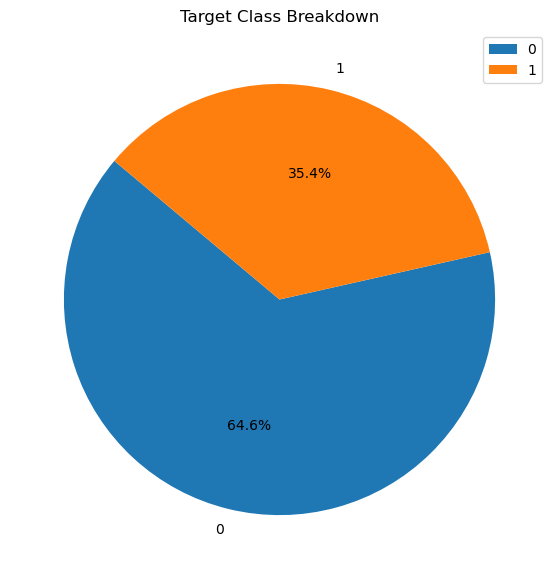

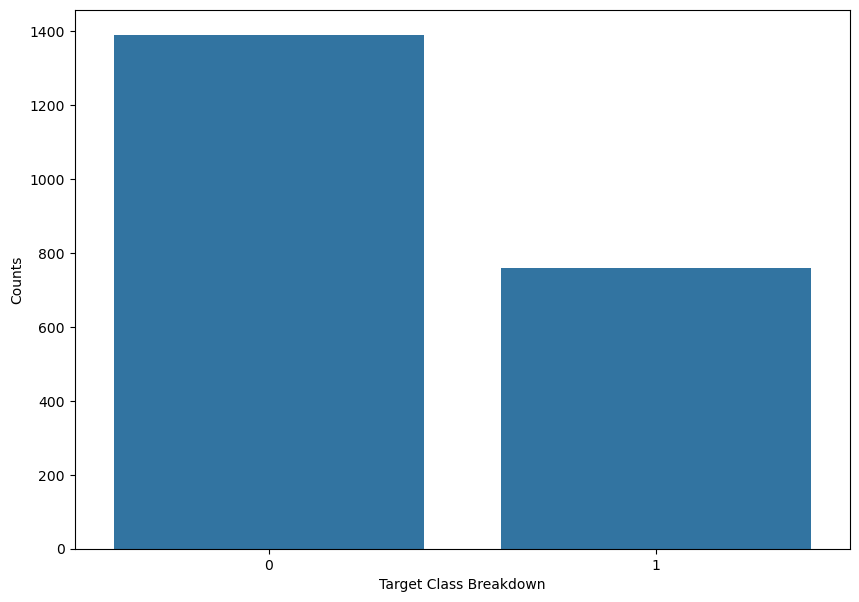

In [17]:
check_class_imbalance(df["Diagnosis"])

# Class Imbalance Exists

In [18]:
df.dtypes

PatientID                      int64
Age                            int64
Gender                         int64
Ethnicity                      int64
EducationLevel                 int64
BMI                          float64
Smoking                        int64
AlcoholConsumption           float64
PhysicalActivity             float64
DietQuality                  float64
SleepQuality                 float64
FamilyHistoryAlzheimers        int64
CardiovascularDisease          int64
Diabetes                       int64
Depression                     int64
HeadInjury                     int64
Hypertension                   int64
SystolicBP                     int64
DiastolicBP                    int64
CholesterolTotal             float64
CholesterolLDL               float64
CholesterolHDL               float64
CholesterolTriglycerides     float64
MMSE                         float64
FunctionalAssessment         float64
MemoryComplaints               int64
BehavioralProblems             int64
A

In [19]:
df.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [20]:
df.drop(["DoctorInCharge", "PatientID"], axis=1, inplace=True)

# Visuals

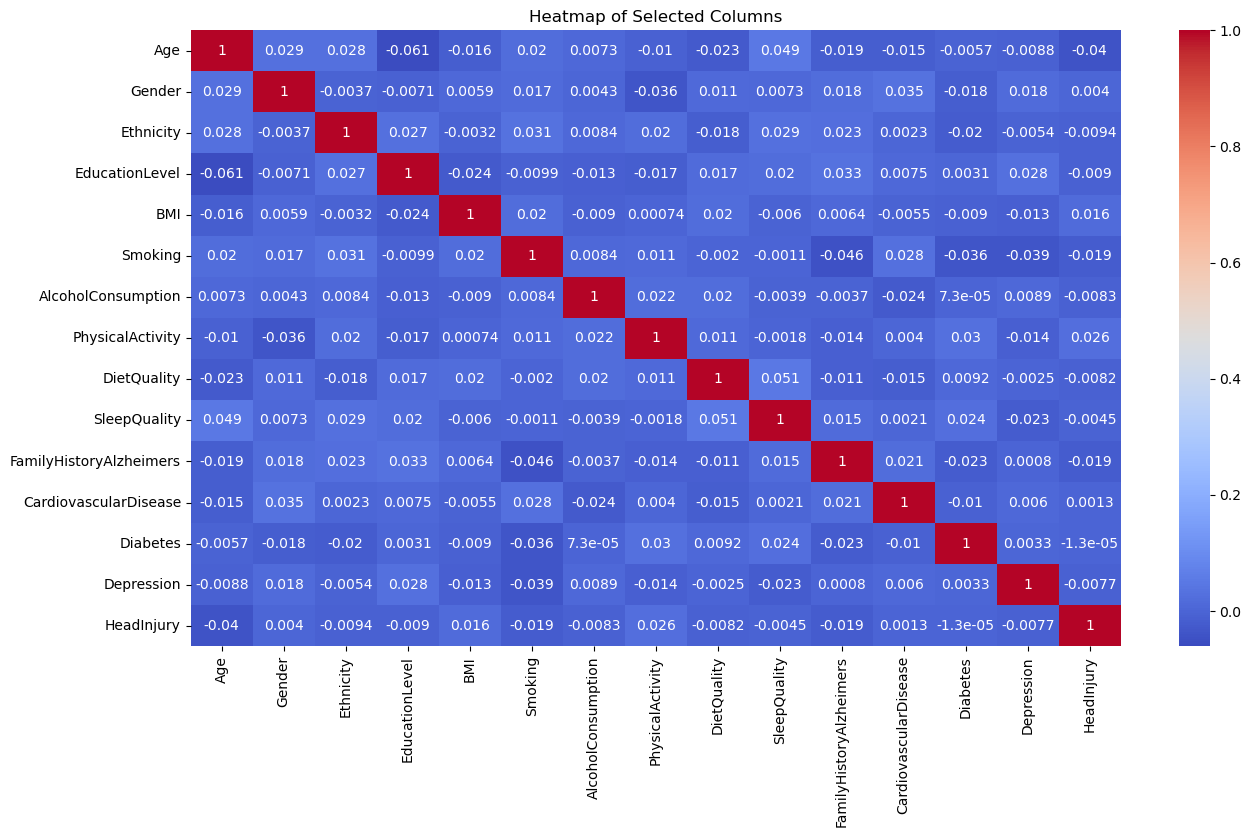

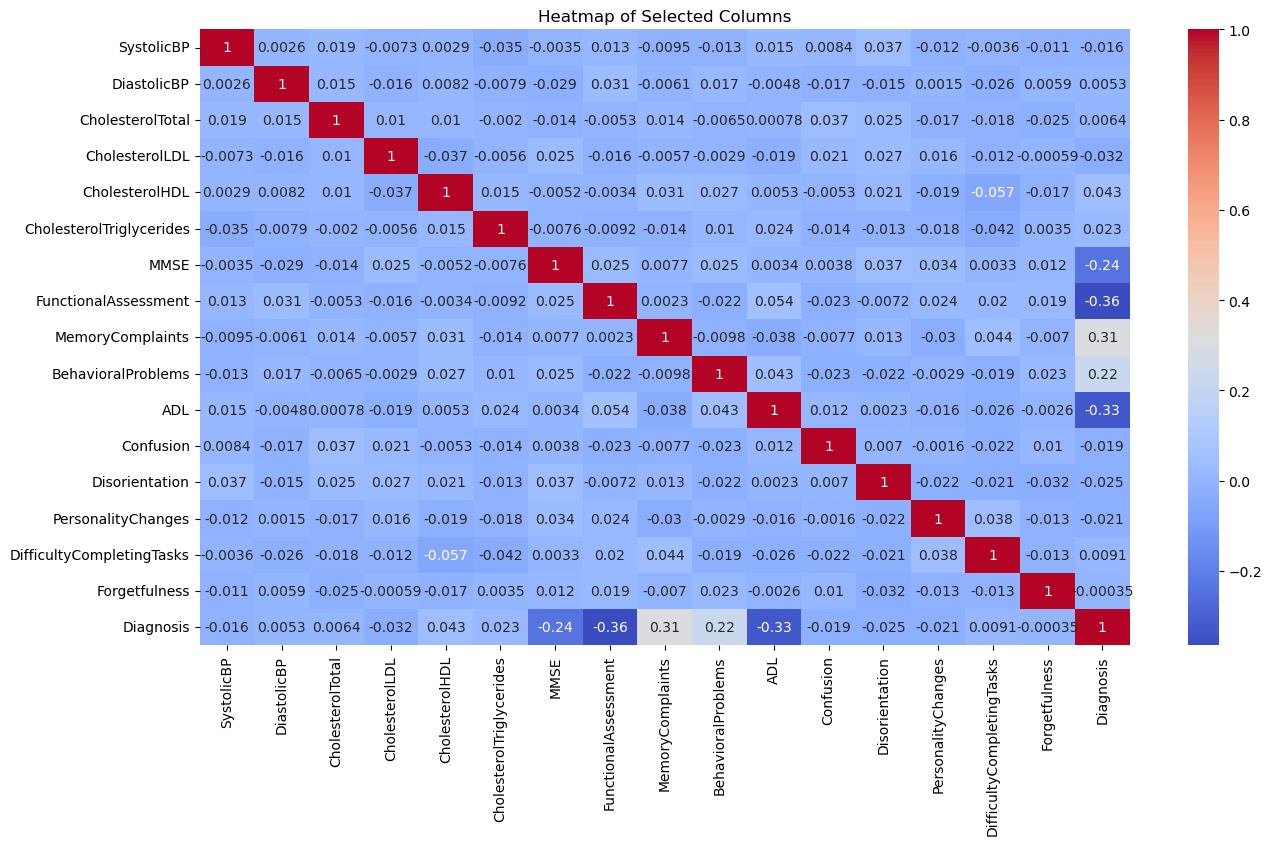

In [47]:
create_heatmap(df.iloc[:, 0:15].corr())
create_heatmap(df.iloc[:, 16:33].corr())

# Histogram

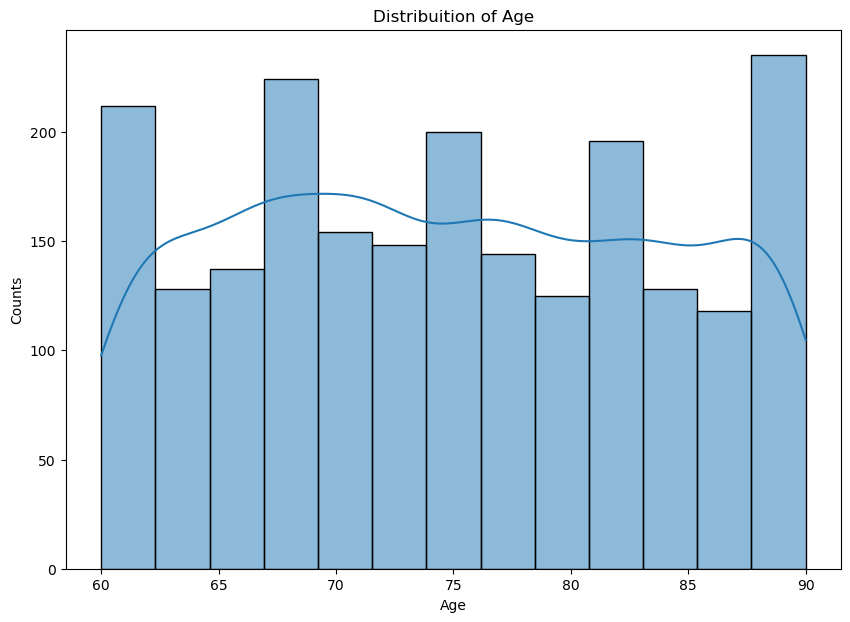

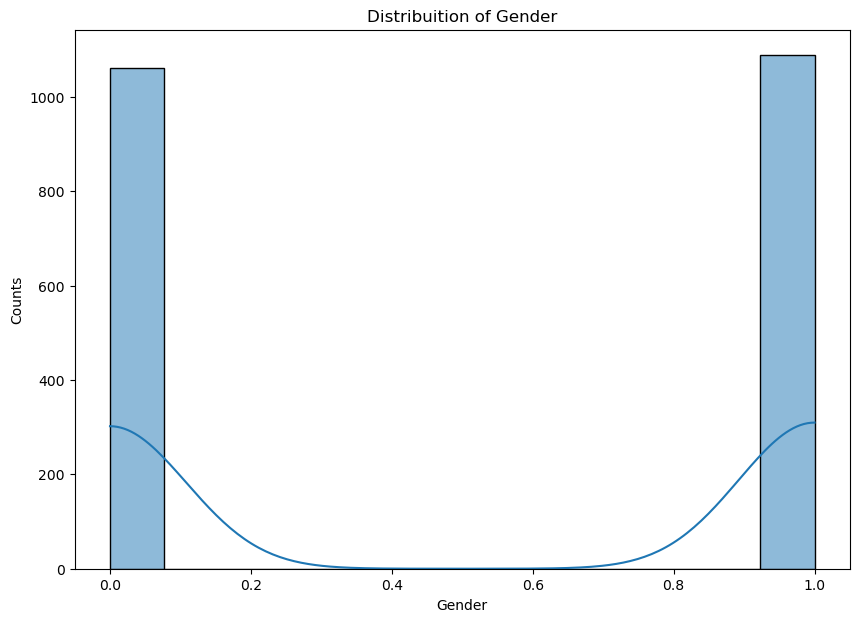

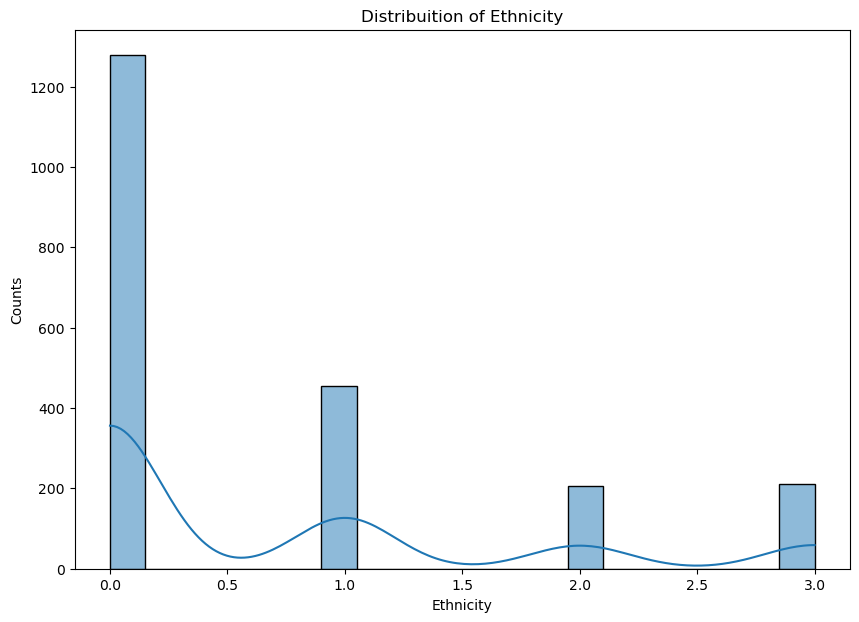

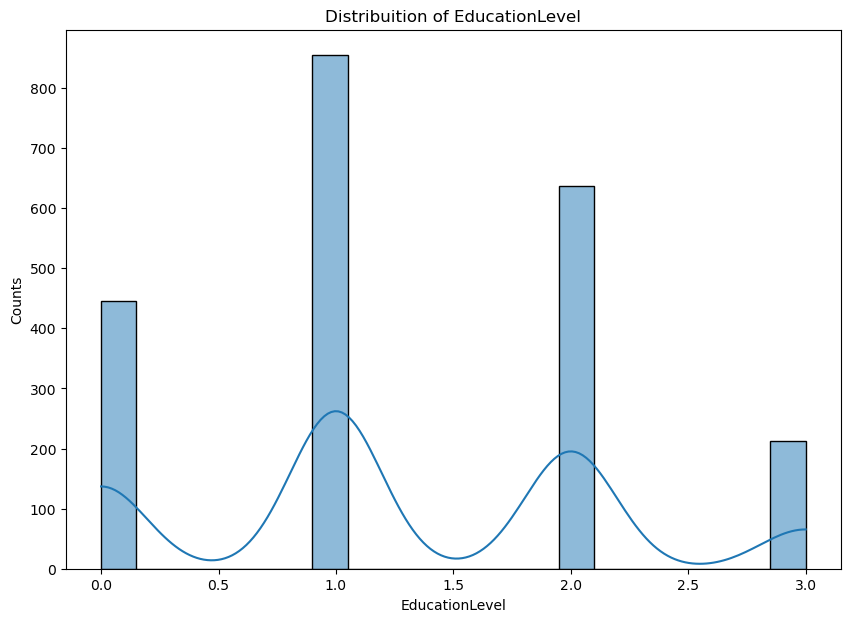

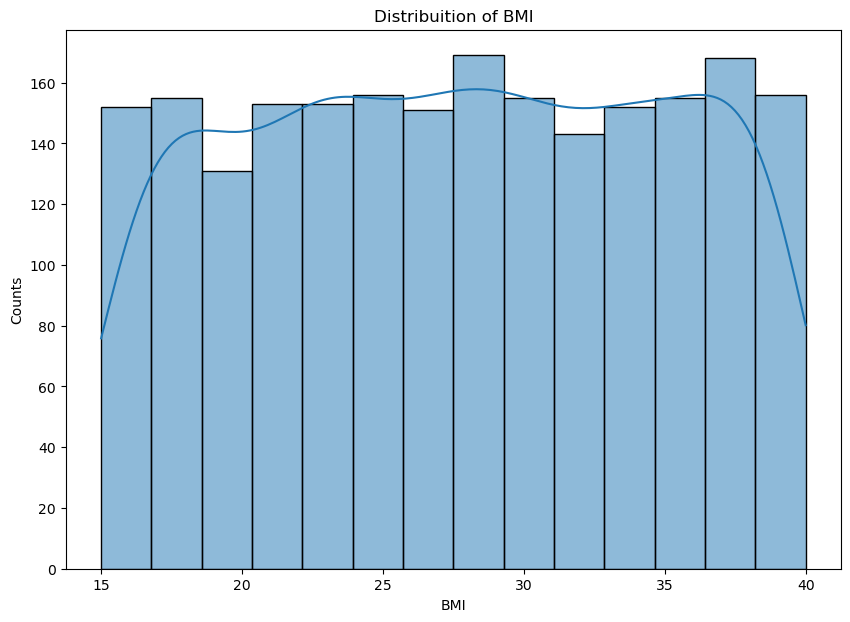

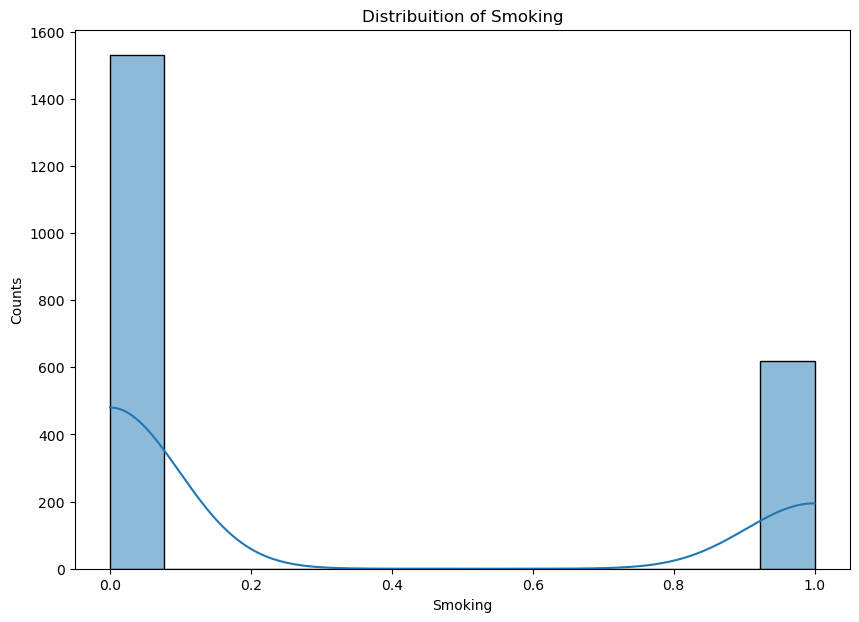

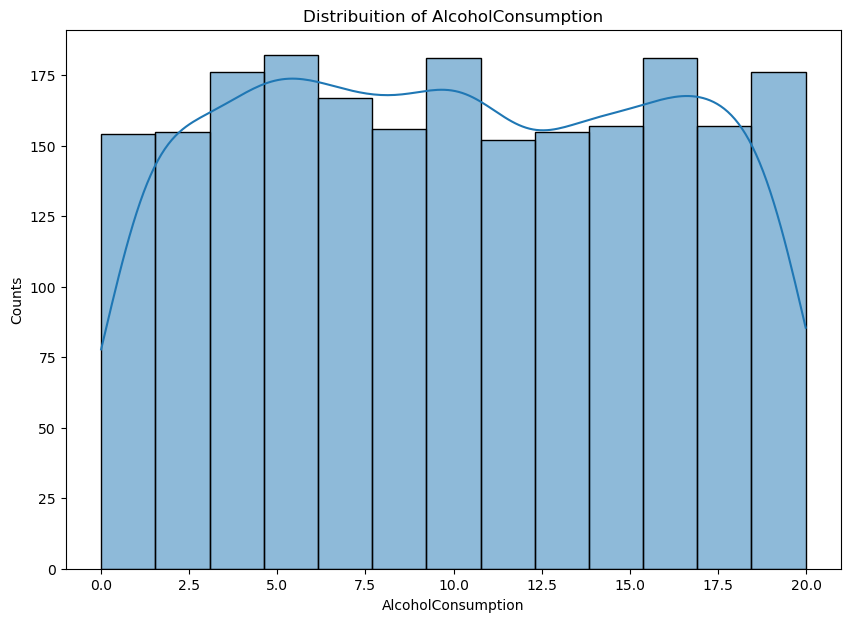

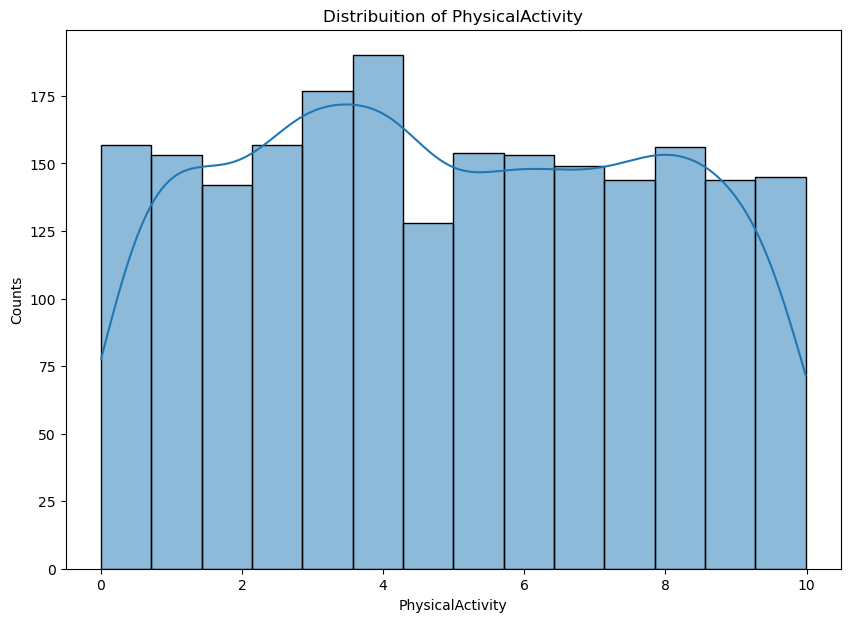

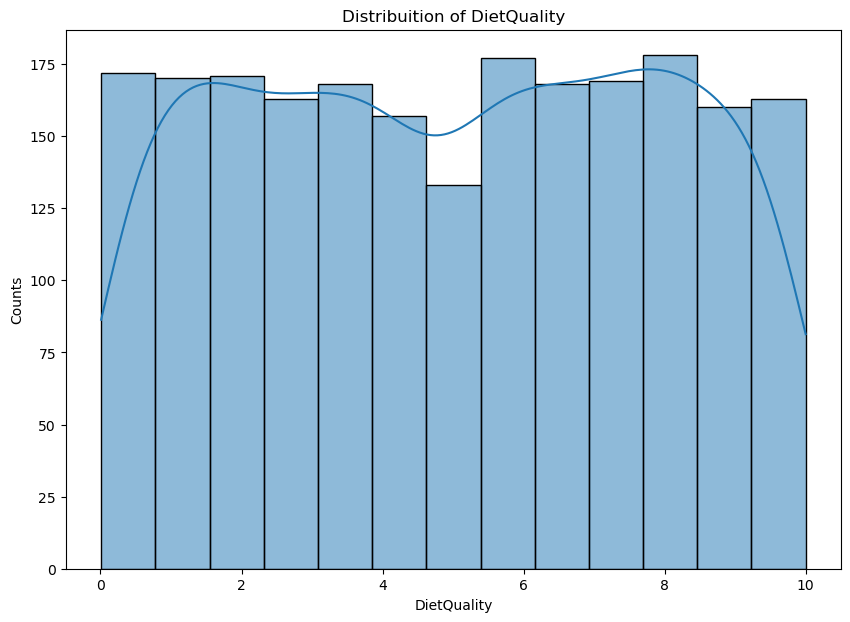

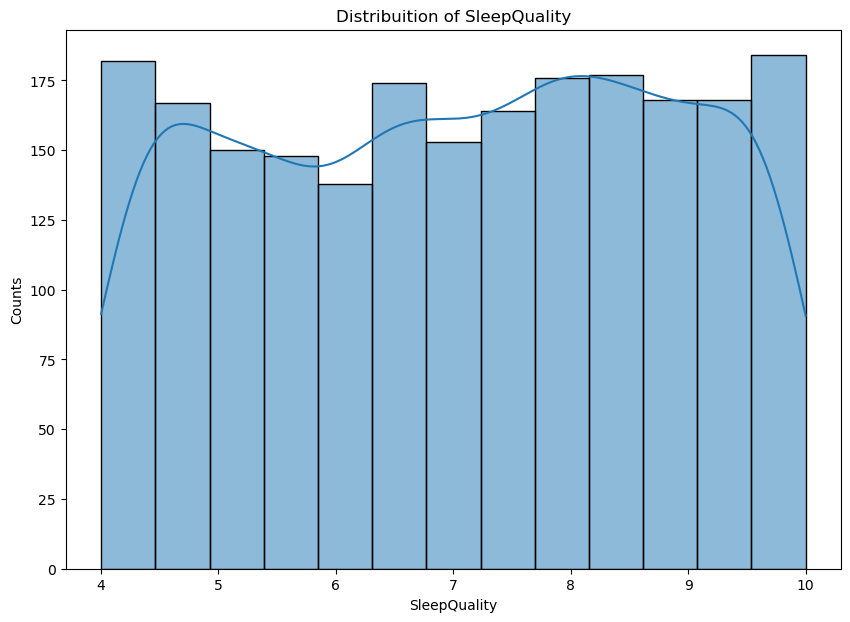

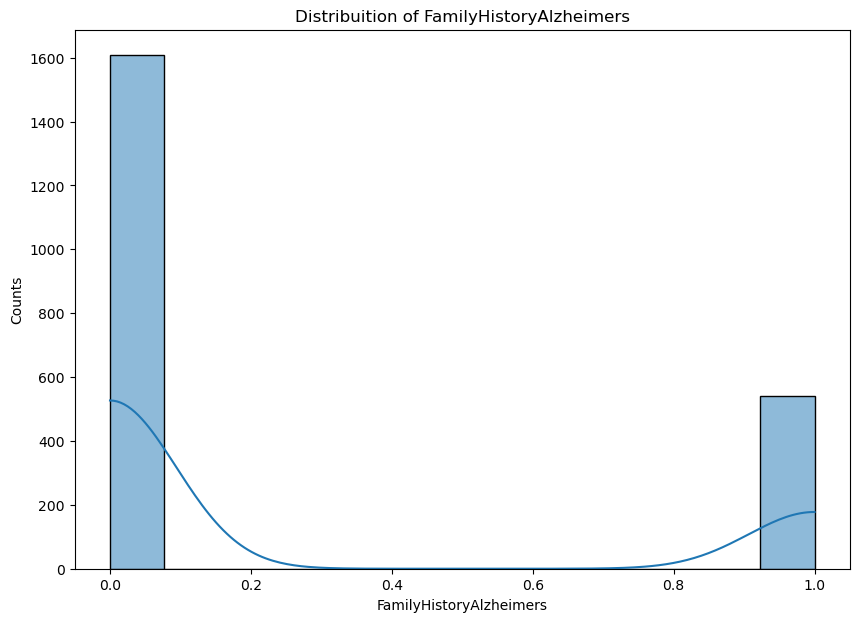

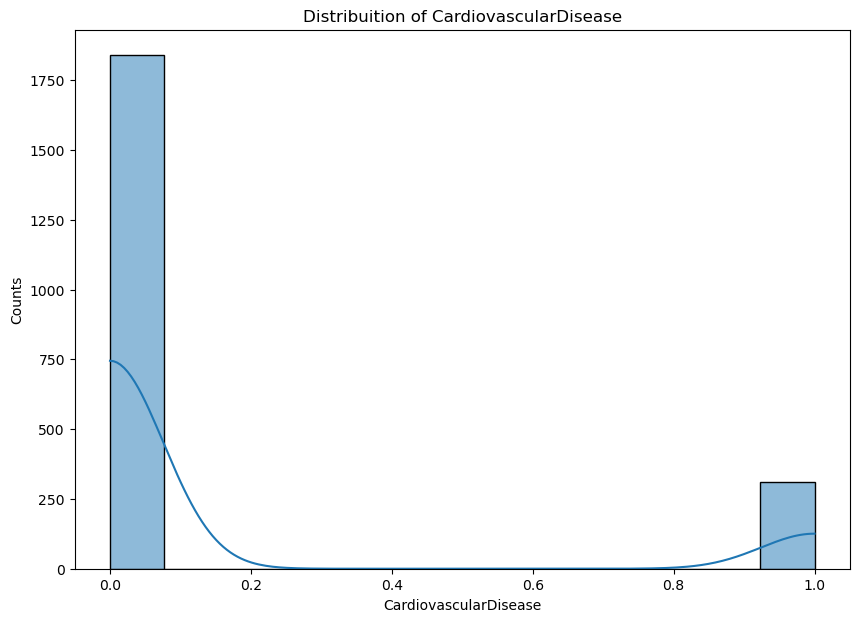

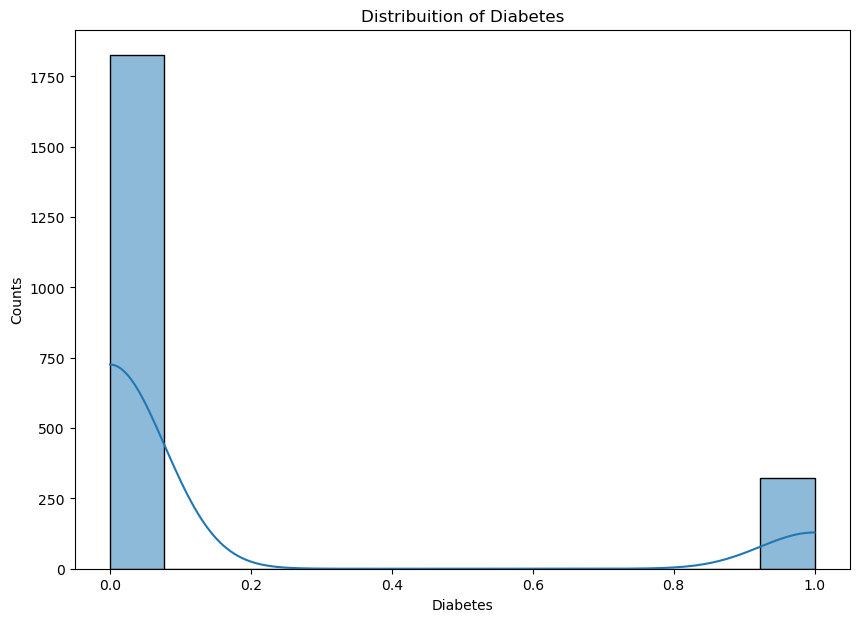

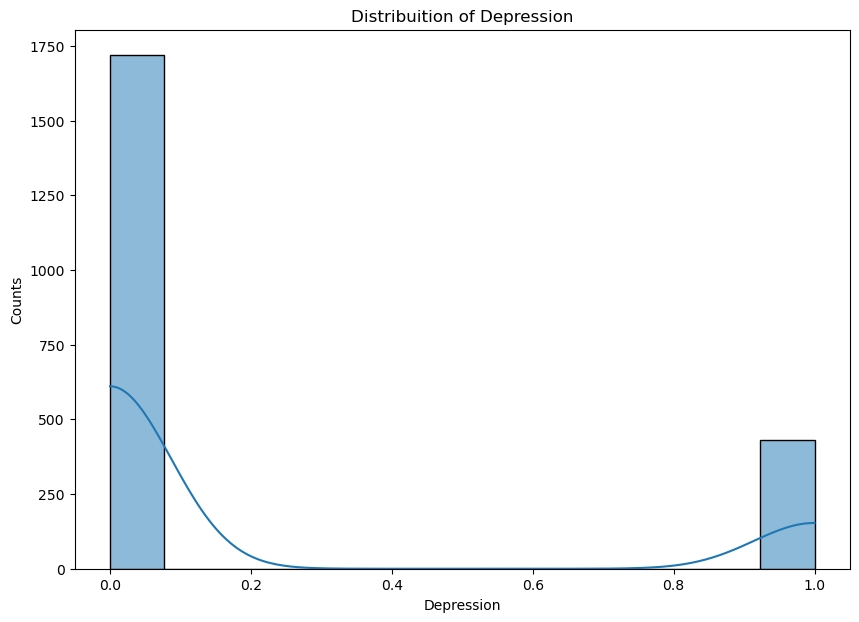

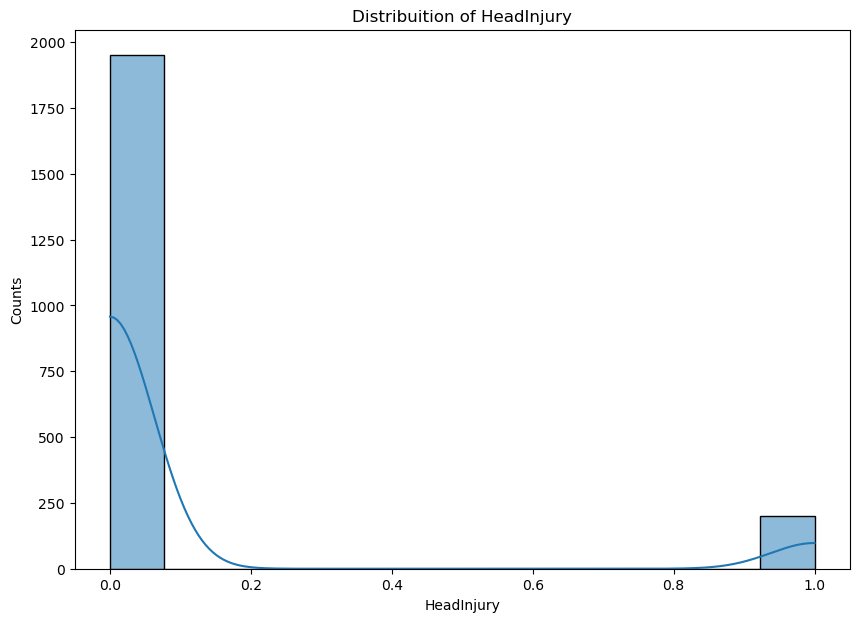

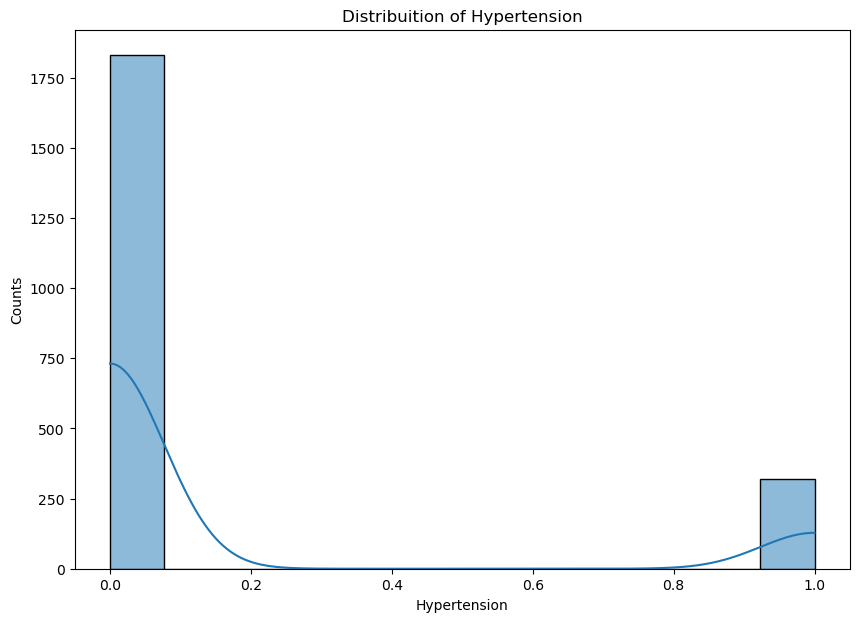

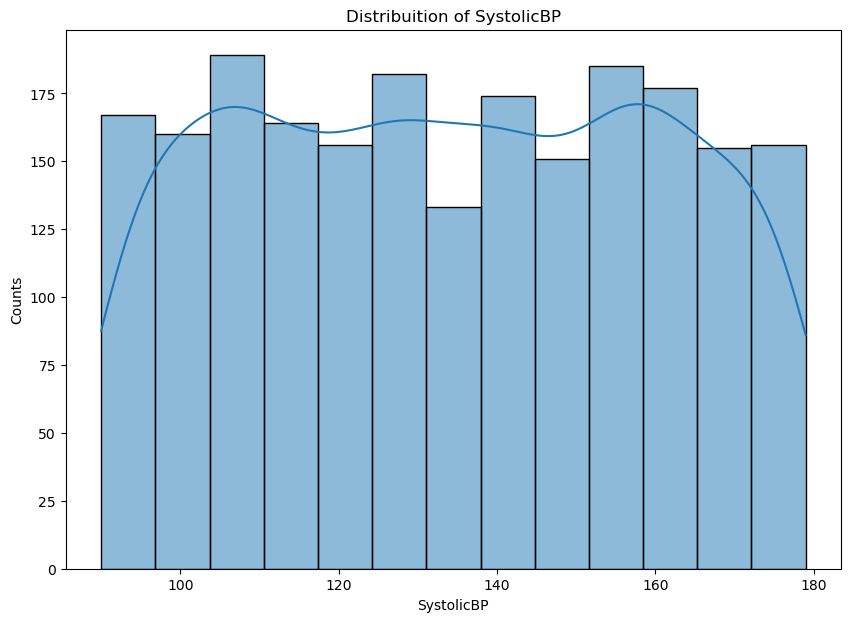

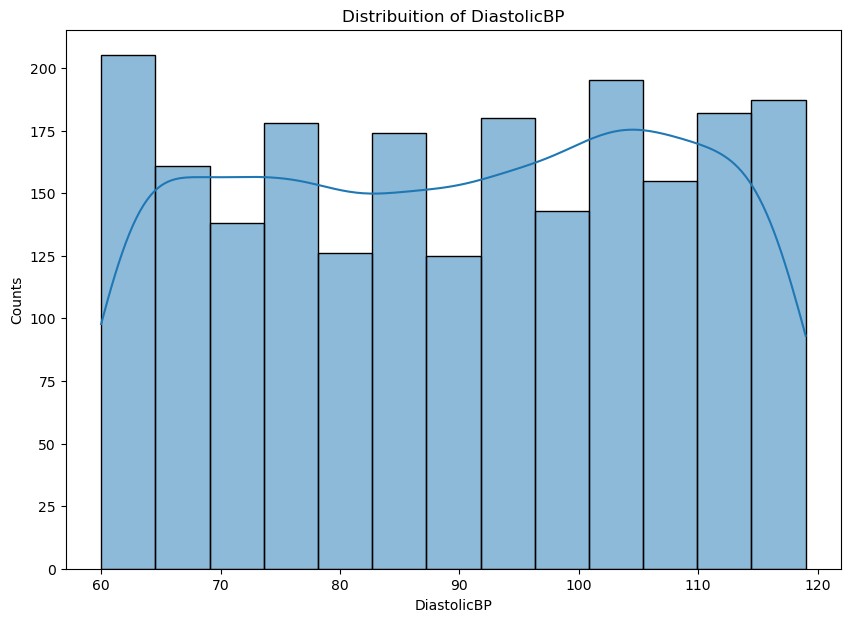

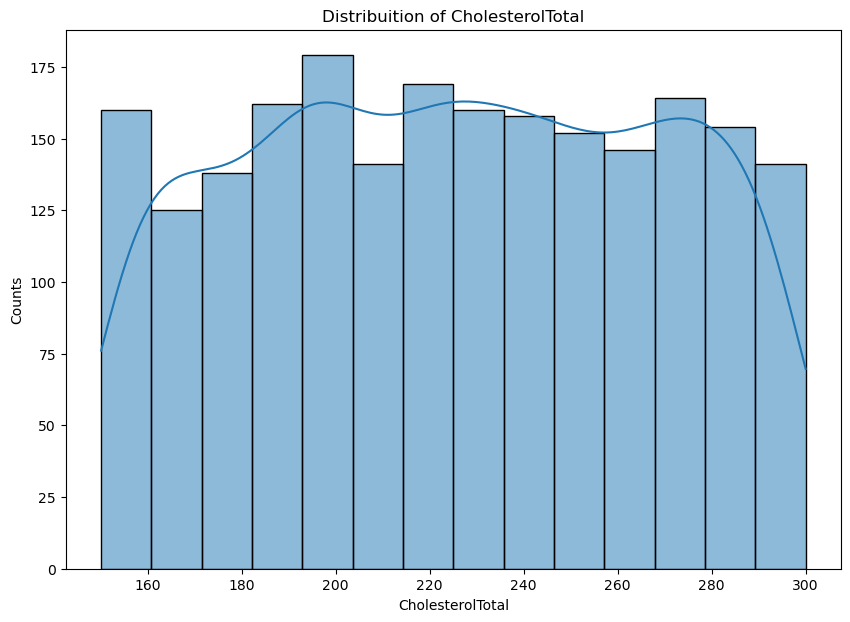

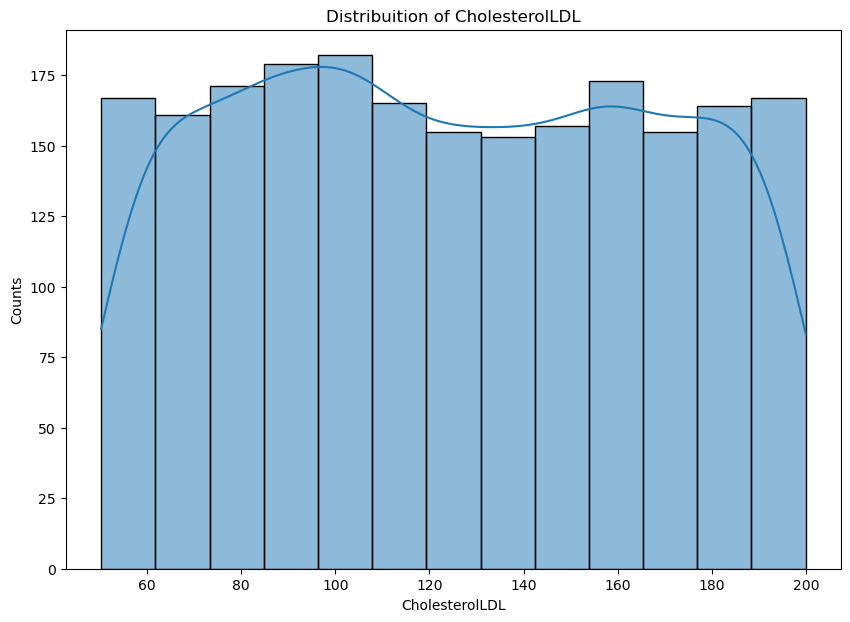

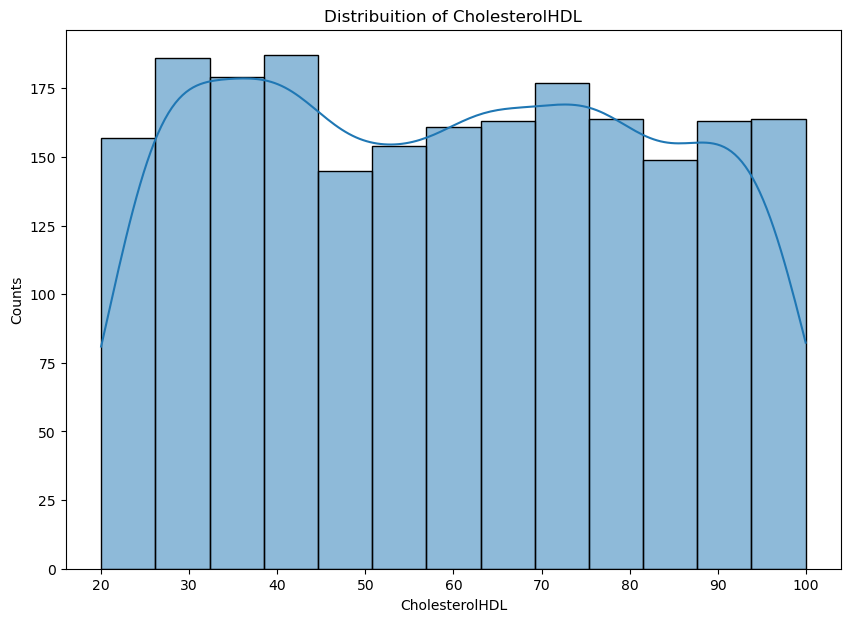

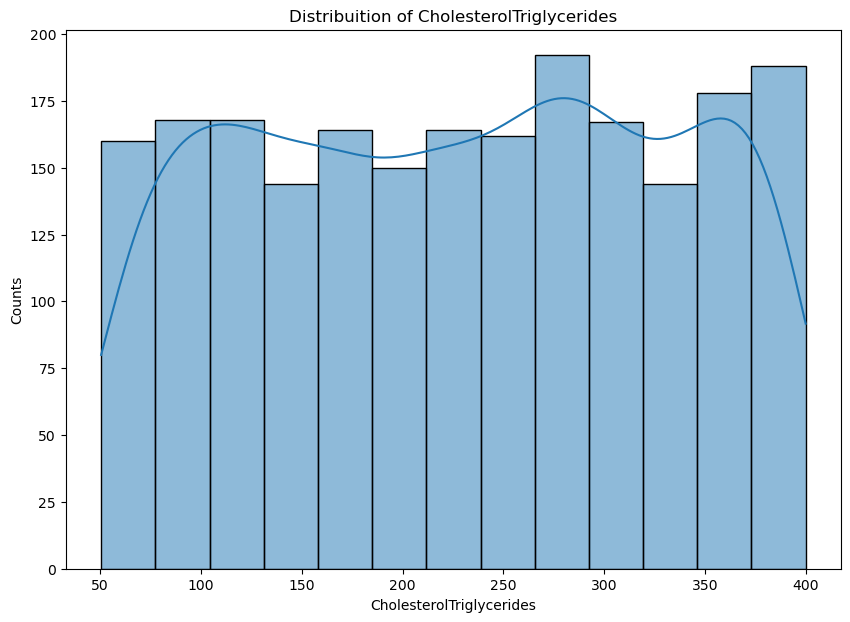

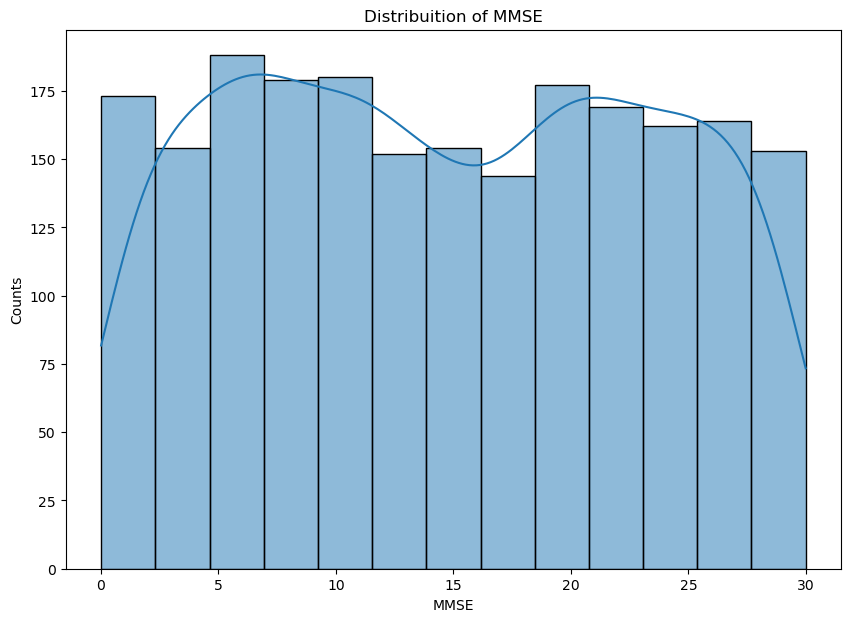

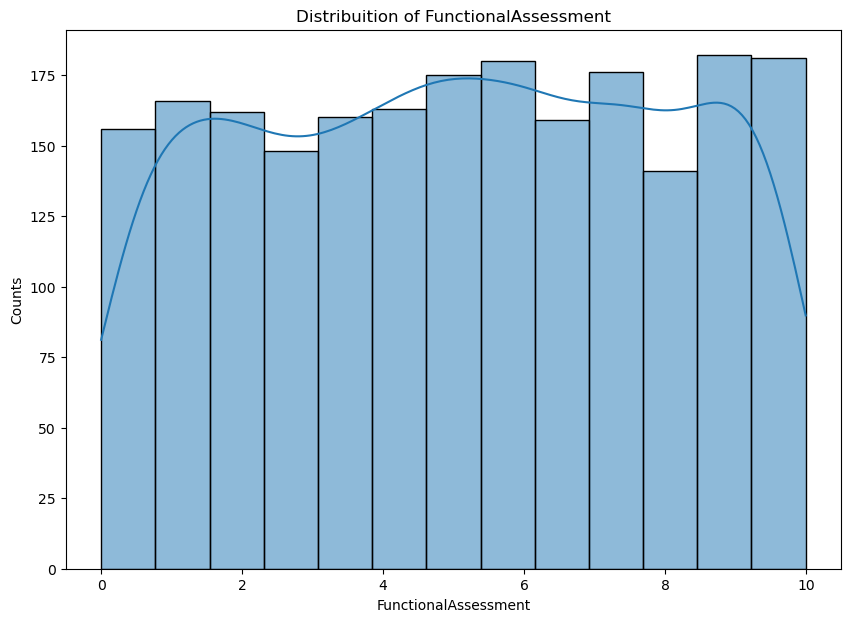

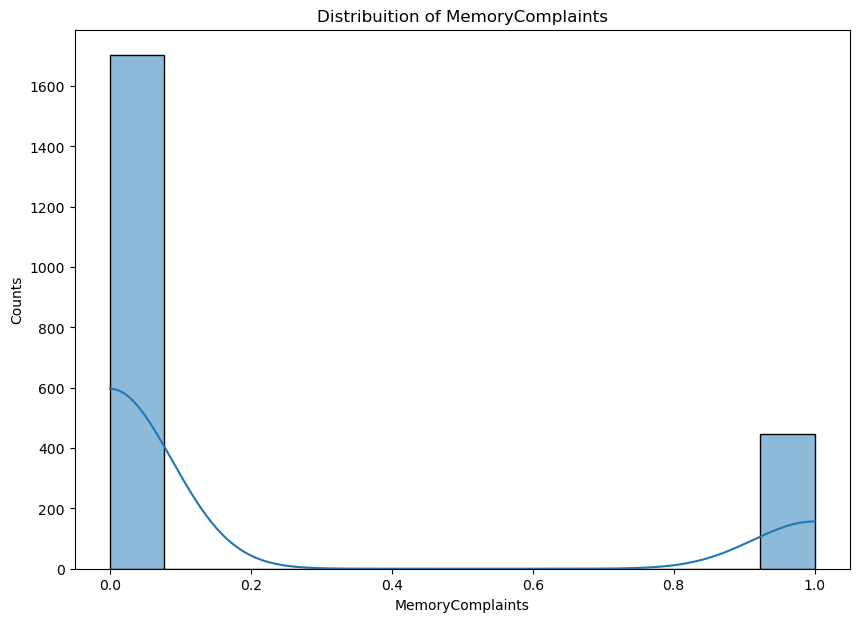

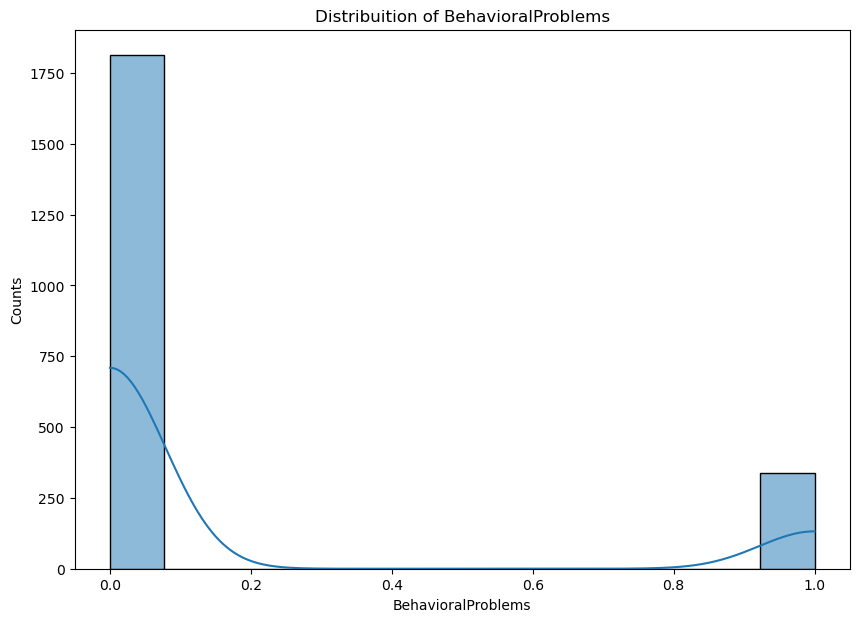

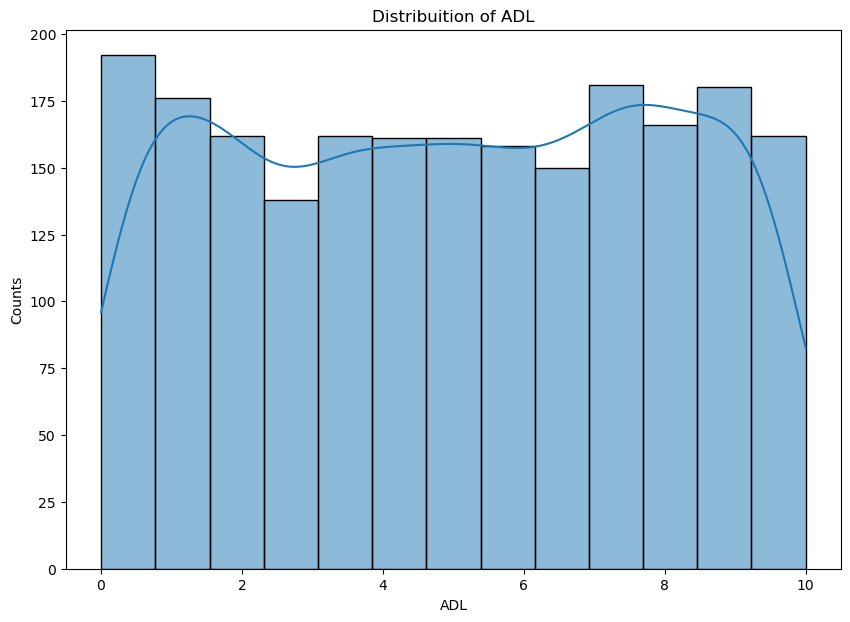

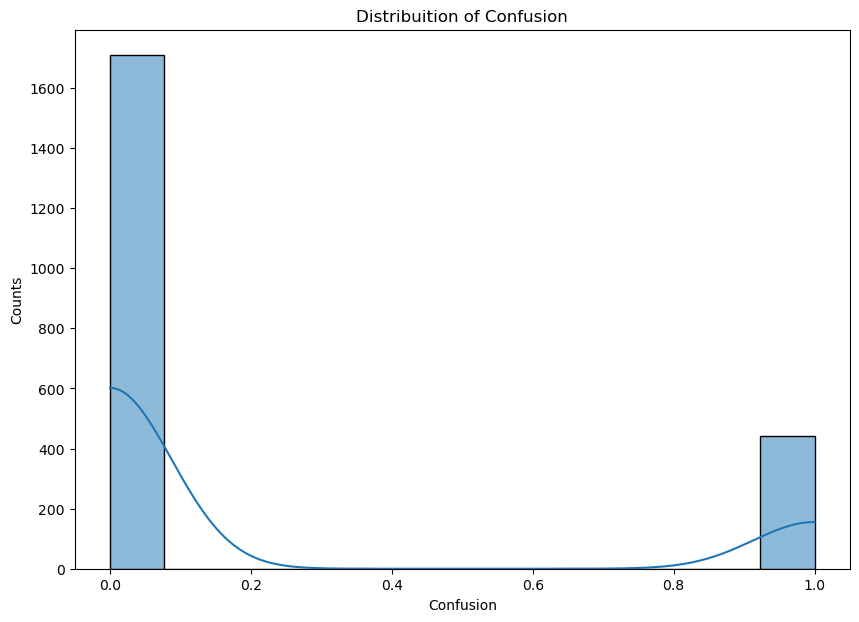

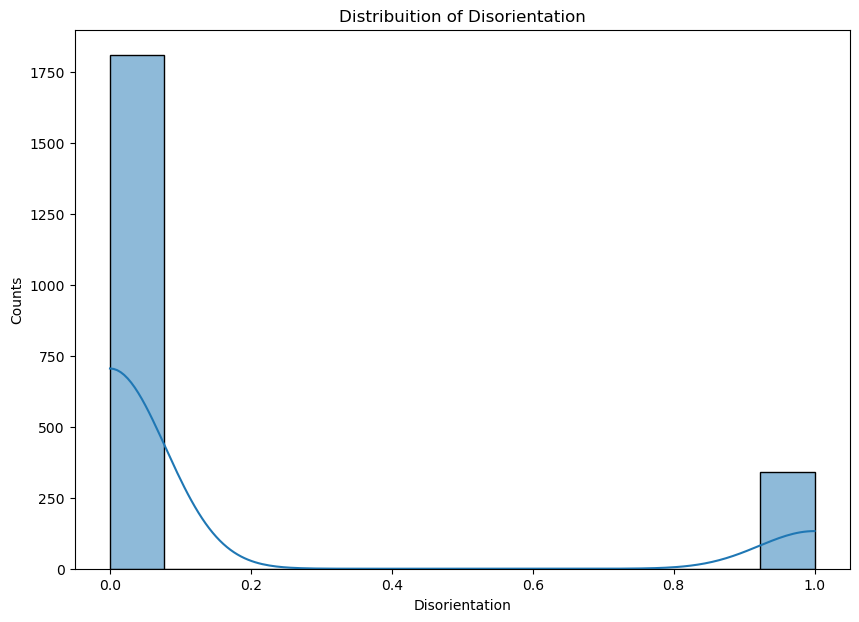

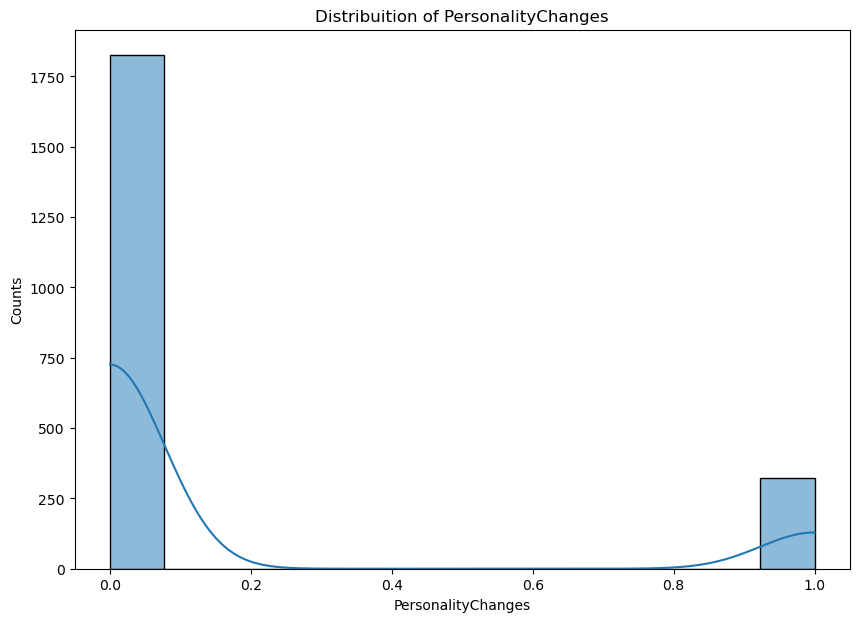

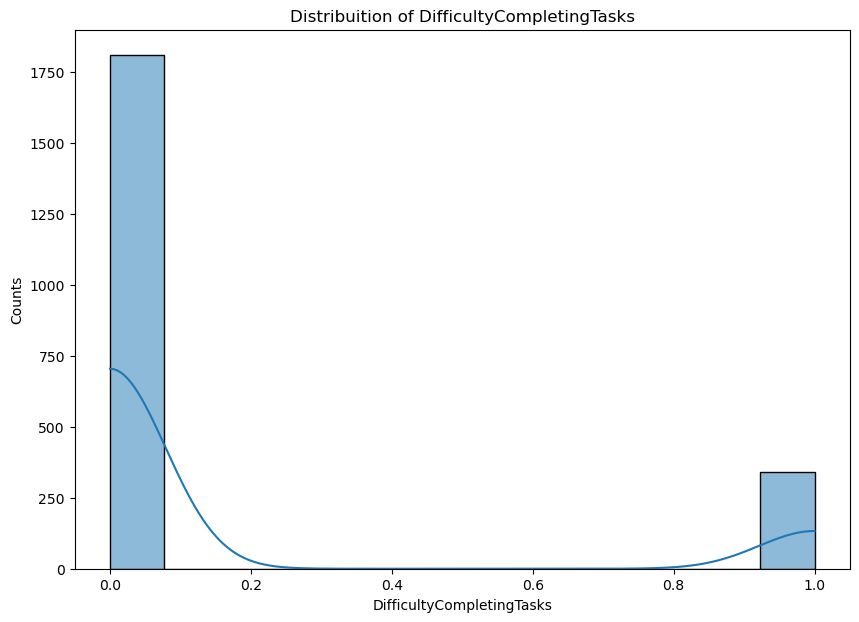

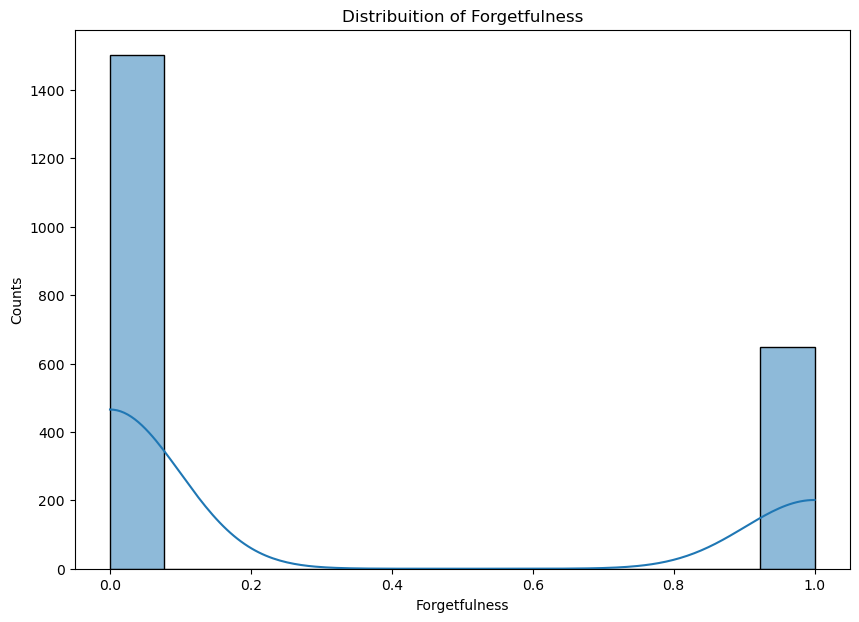

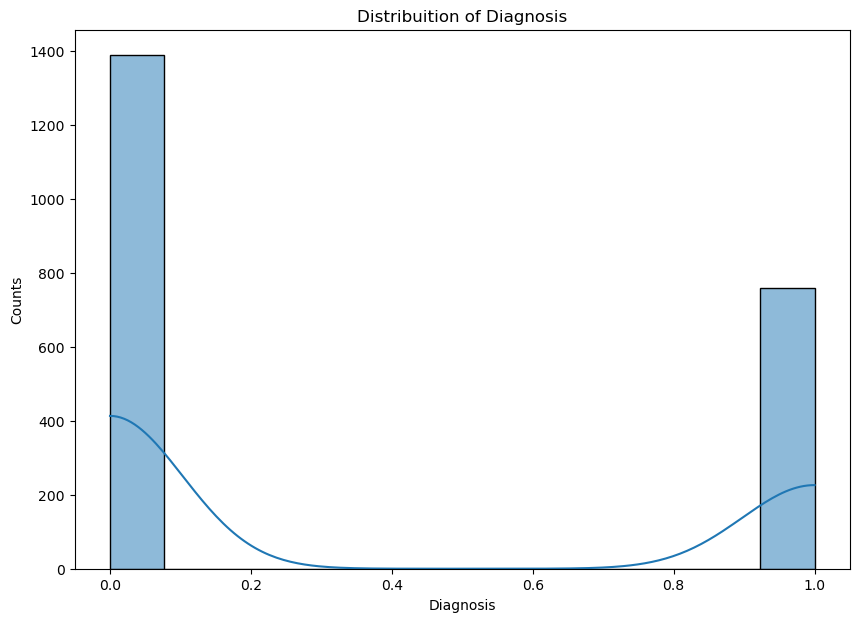

In [51]:
plot_distribution(df, "Hist")

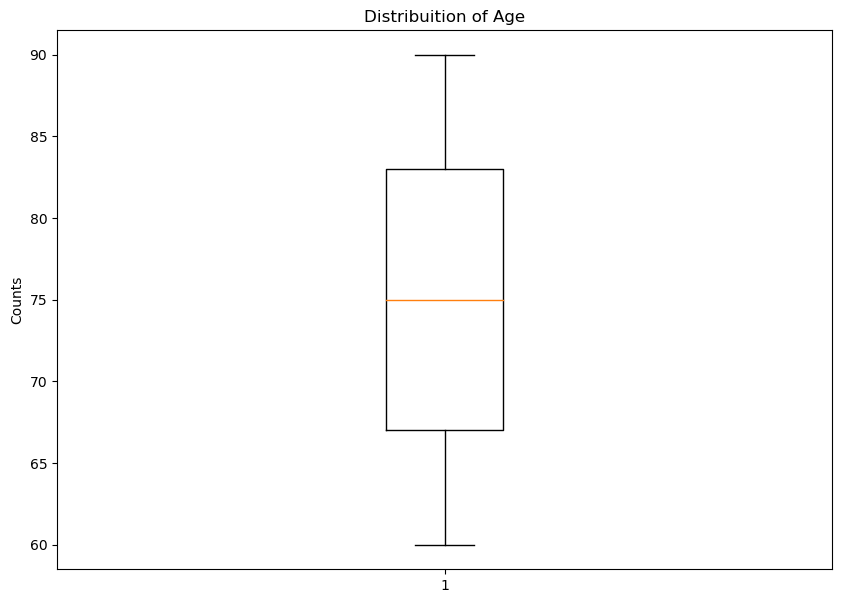

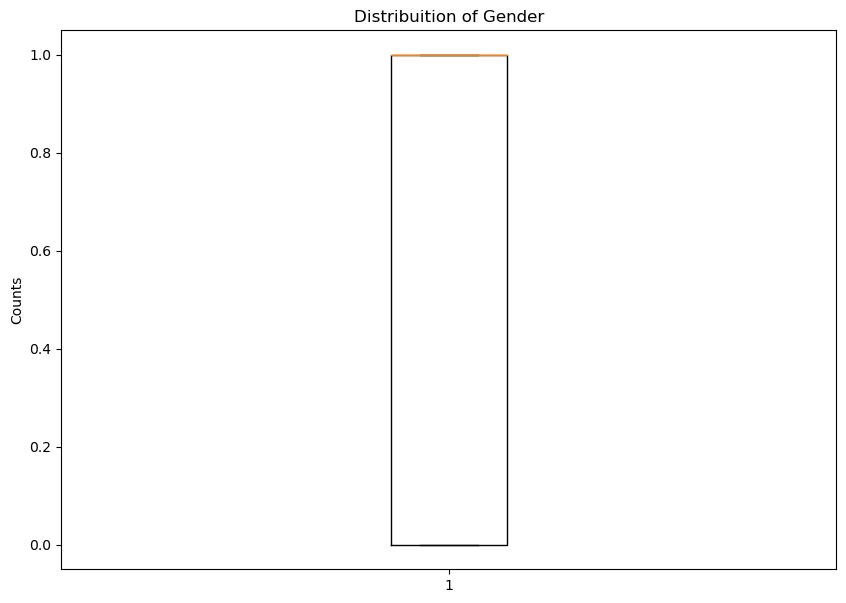

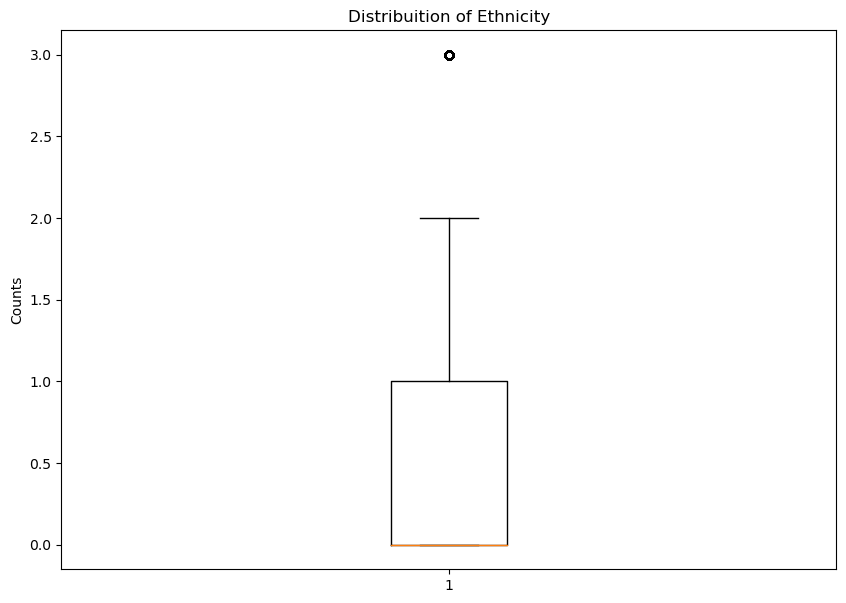

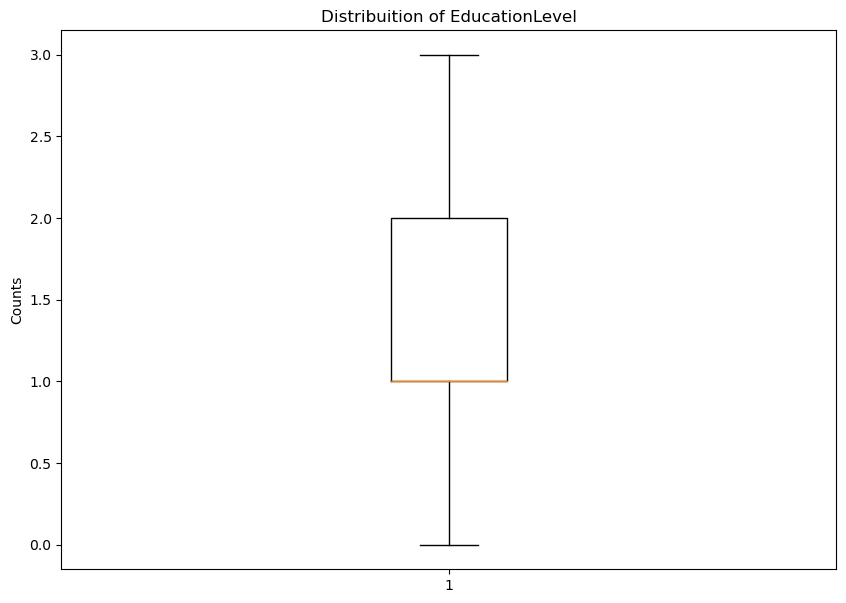

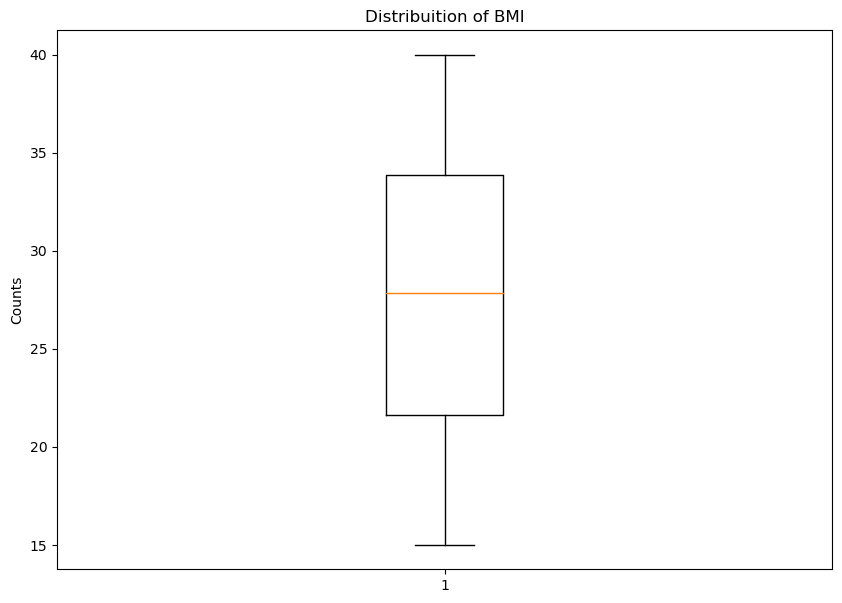

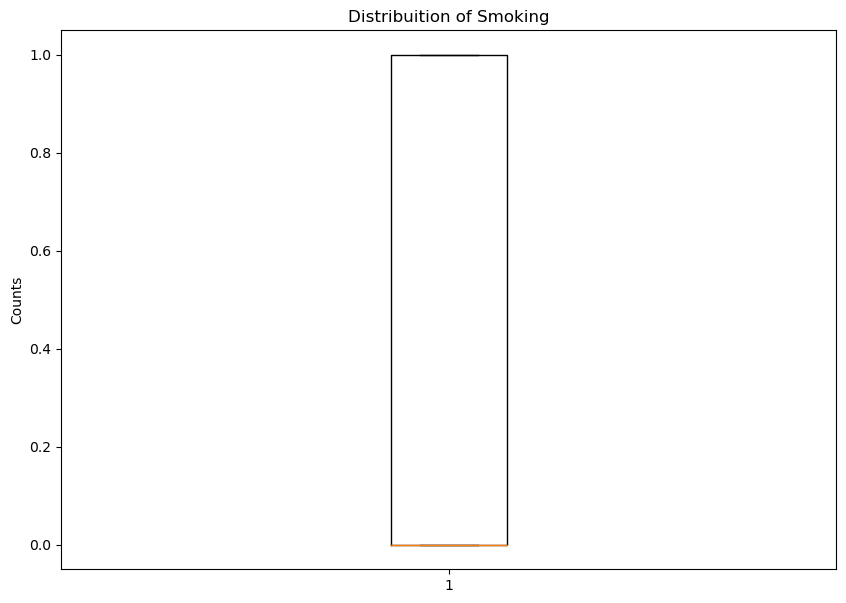

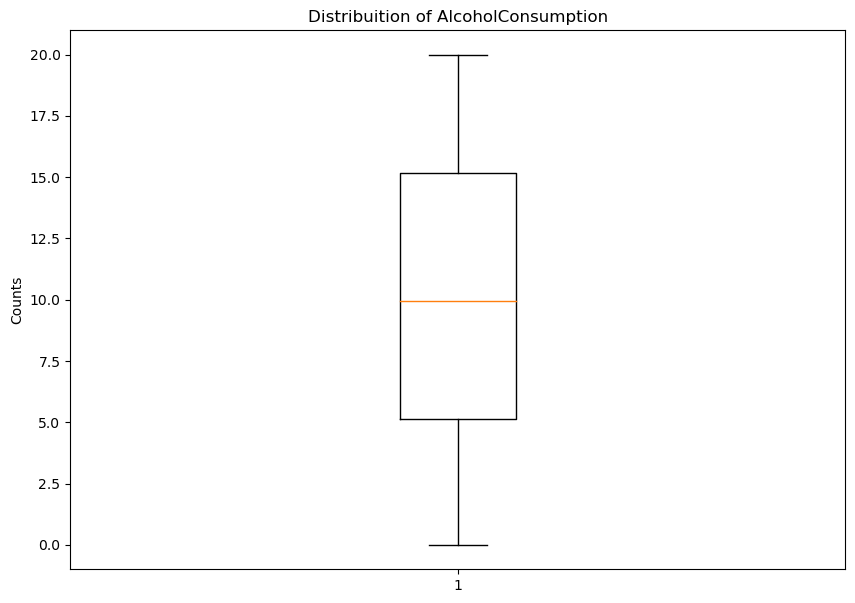

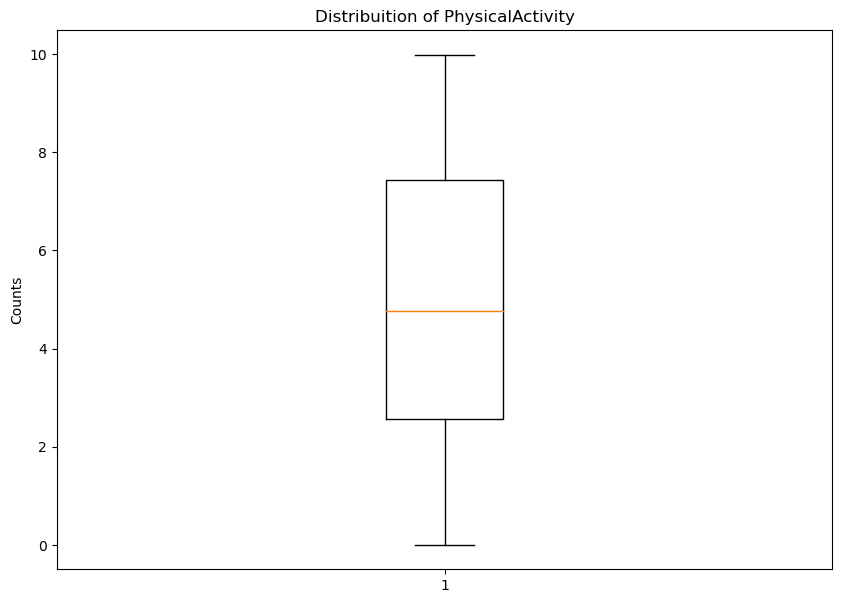

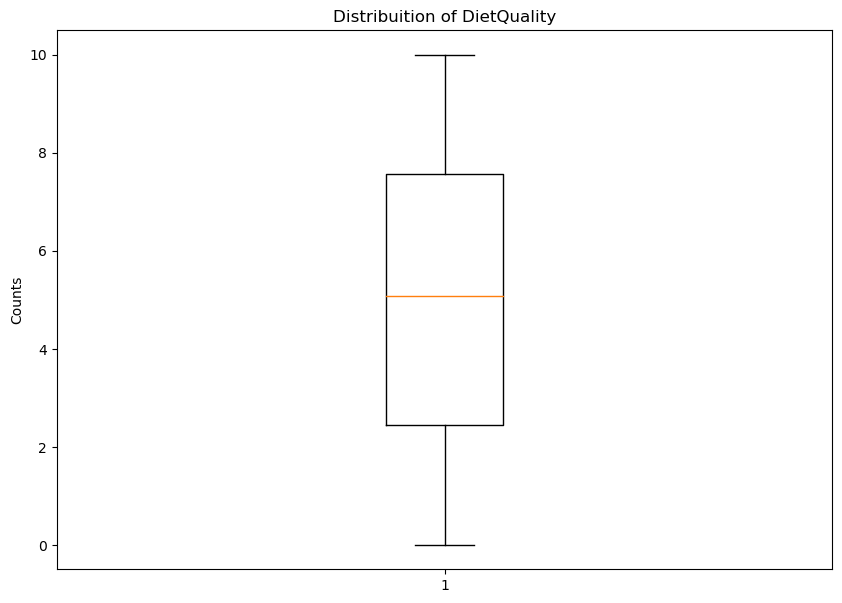

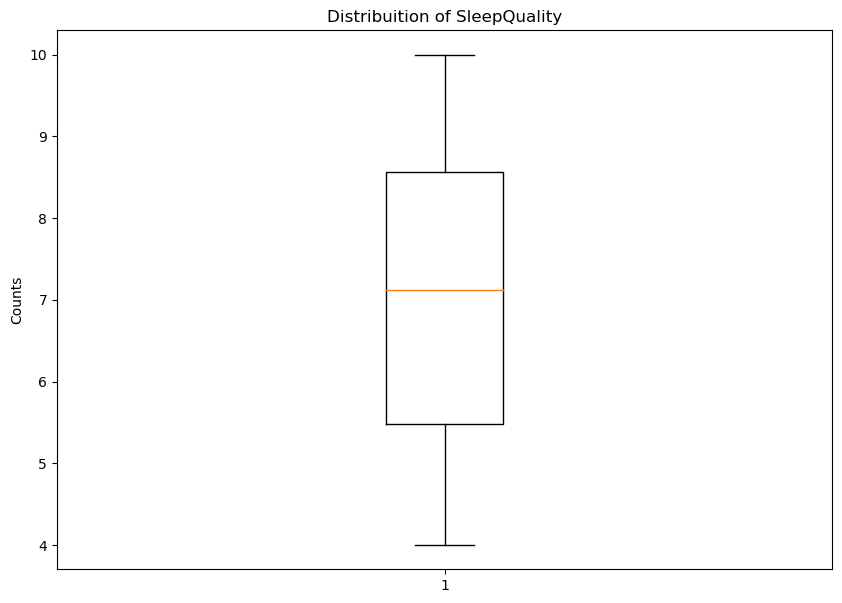

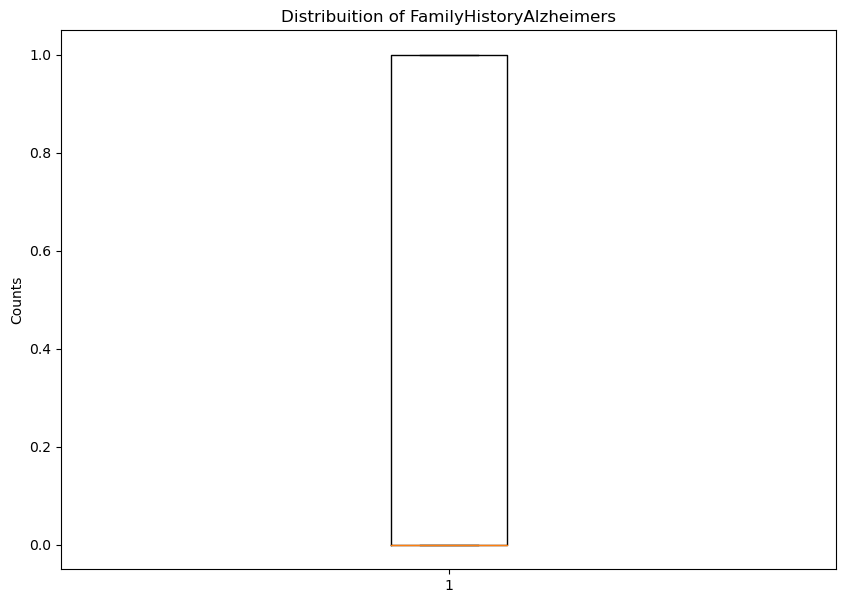

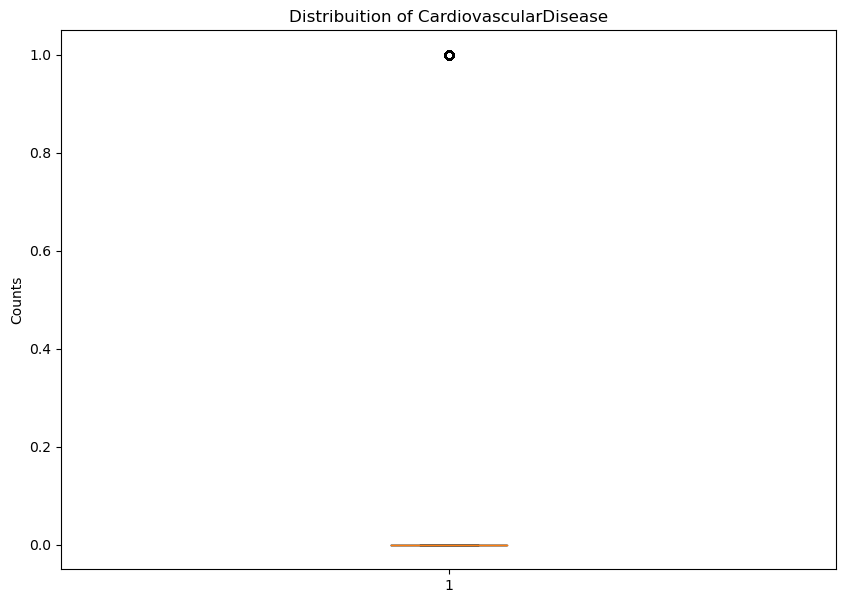

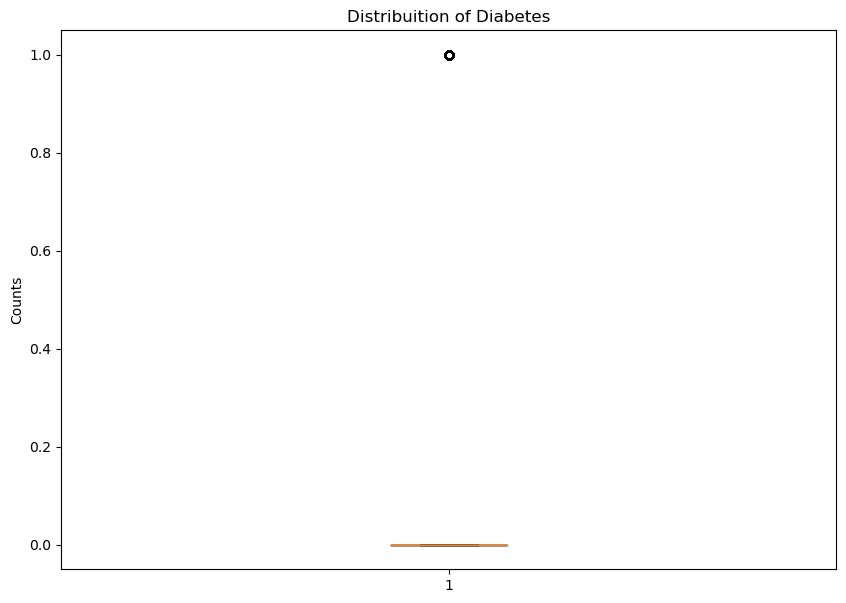

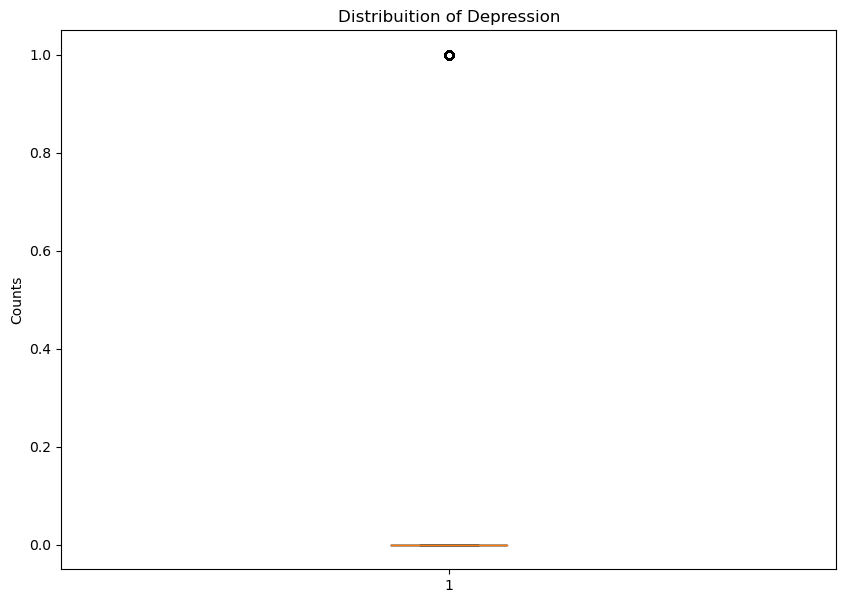

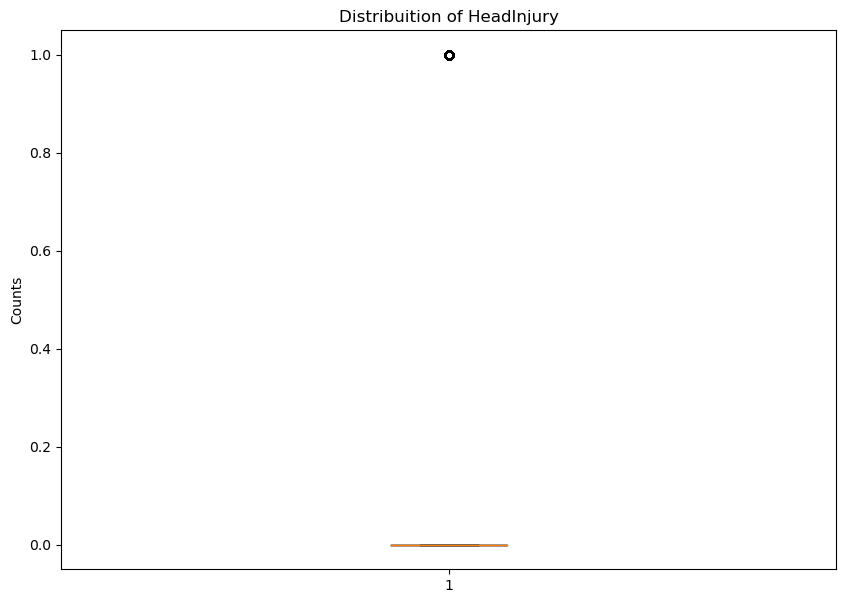

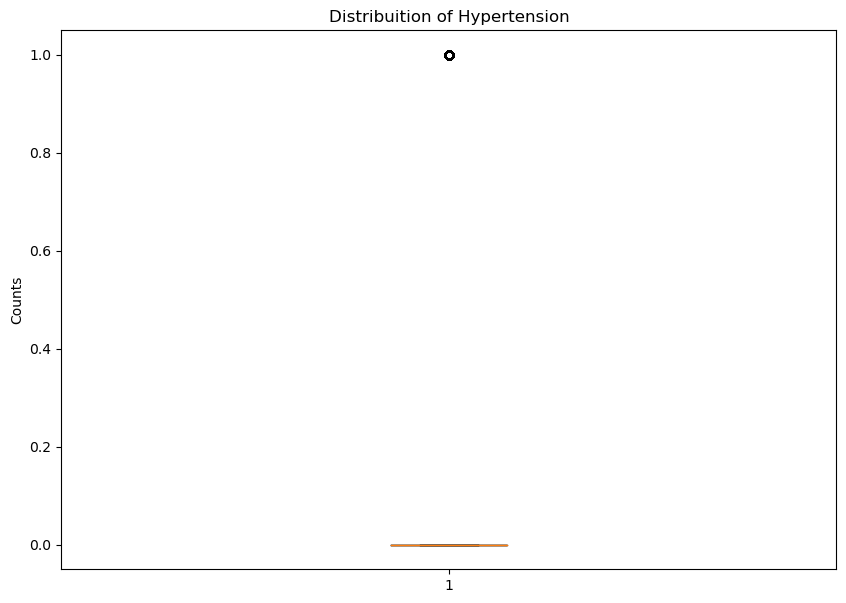

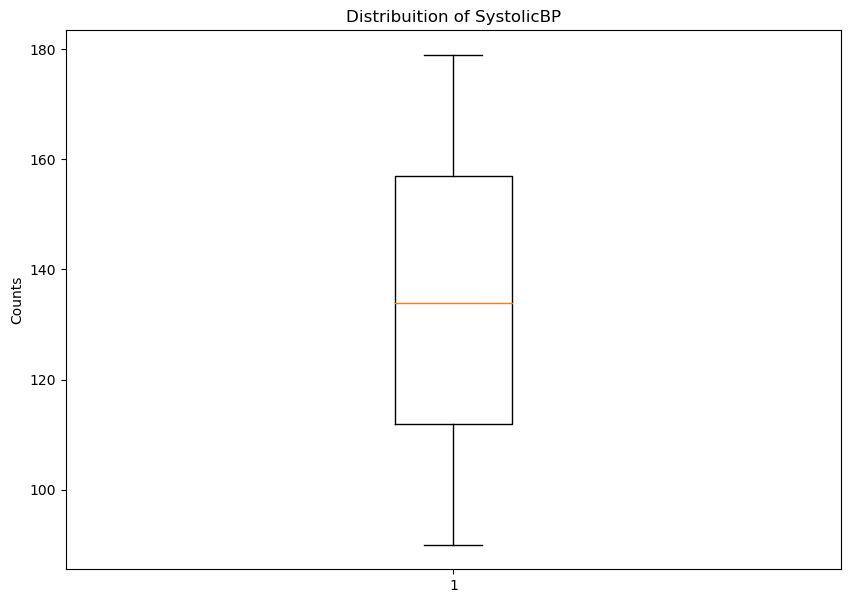

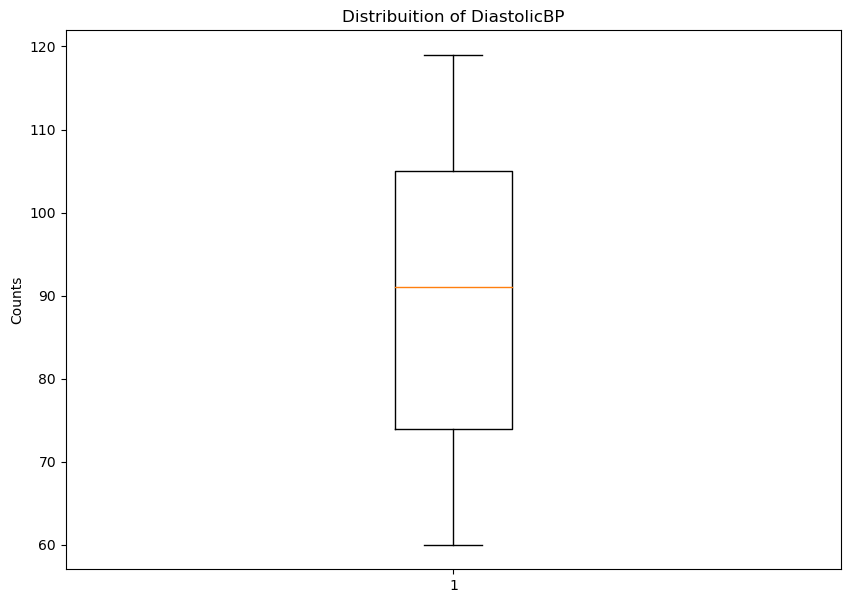

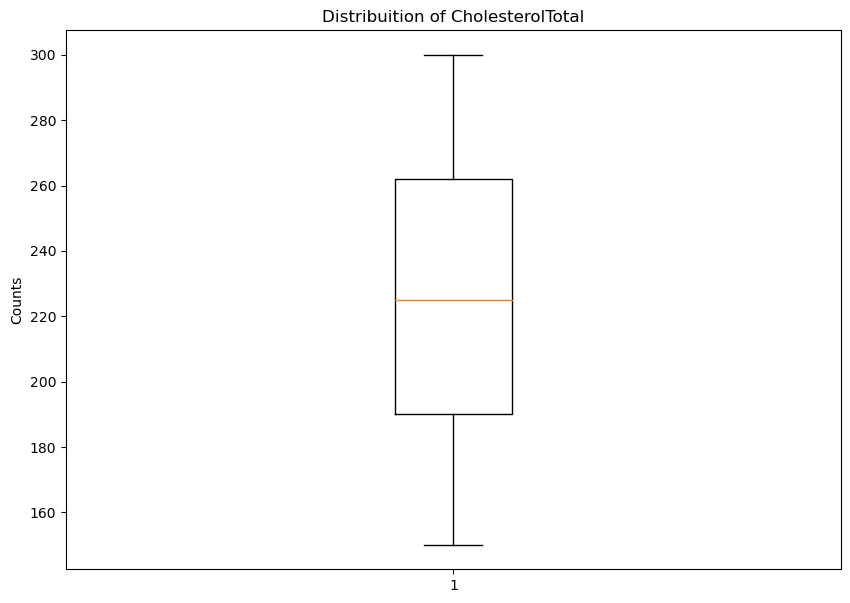

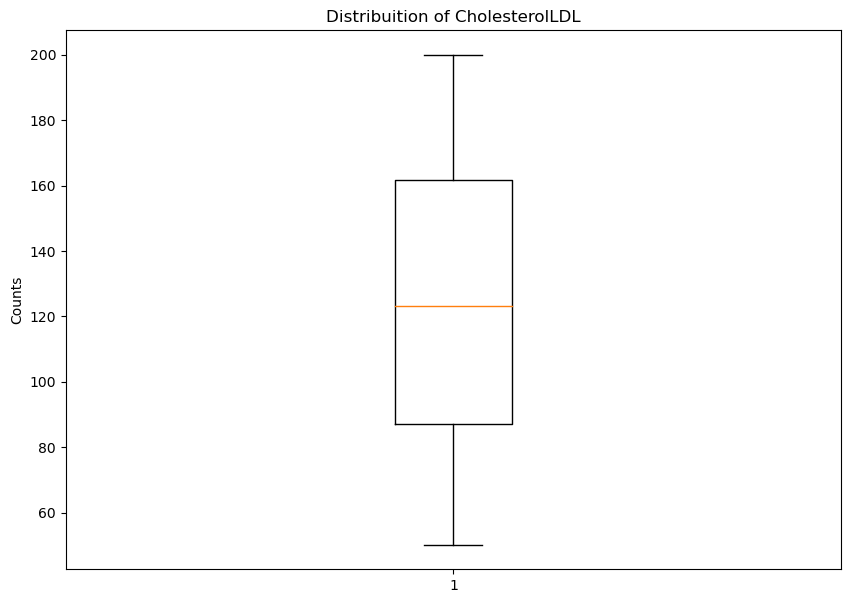

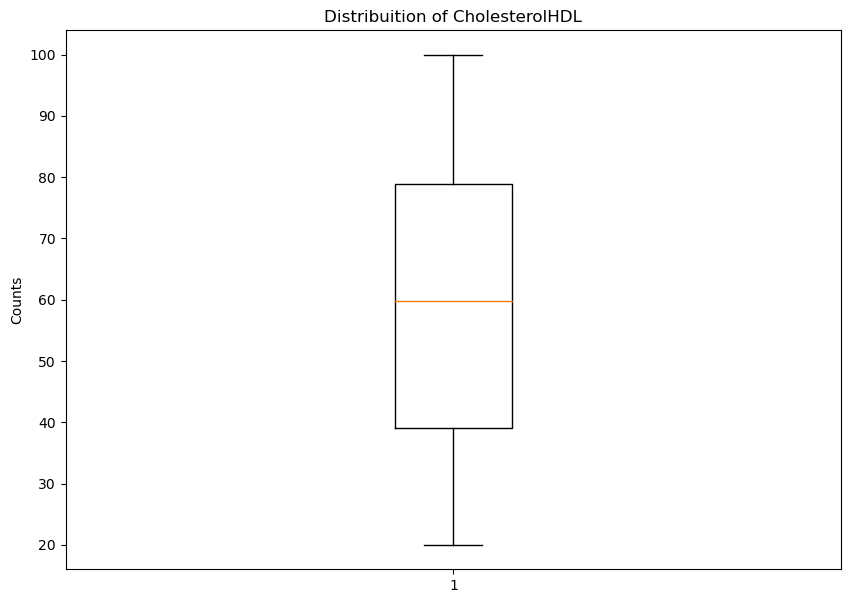

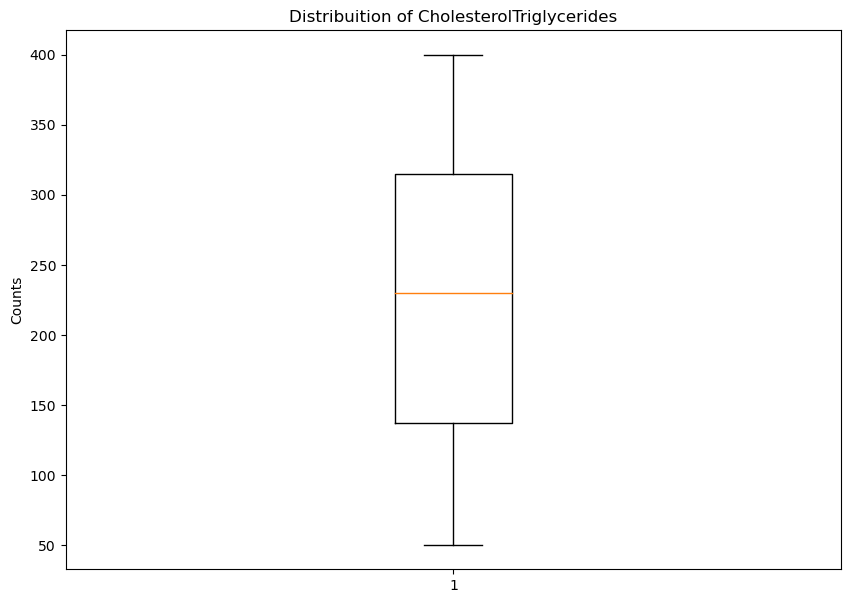

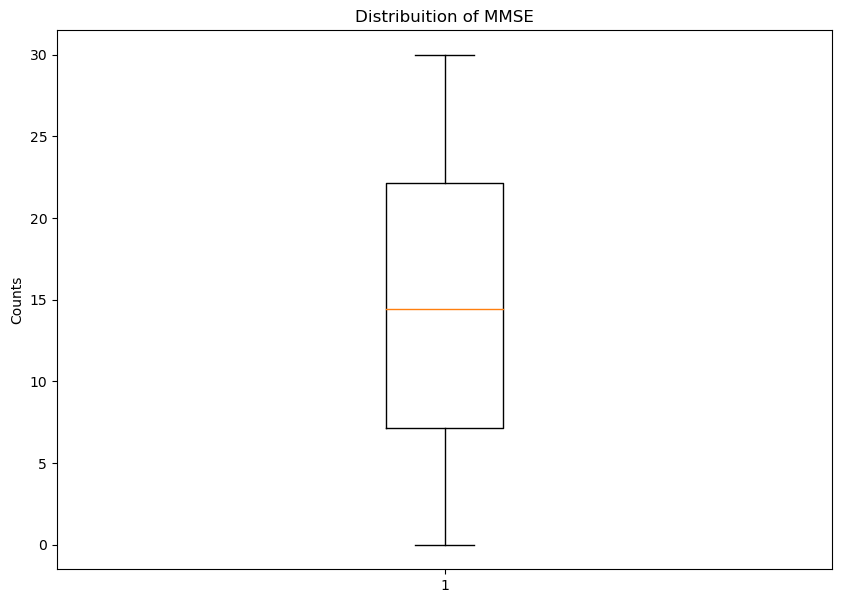

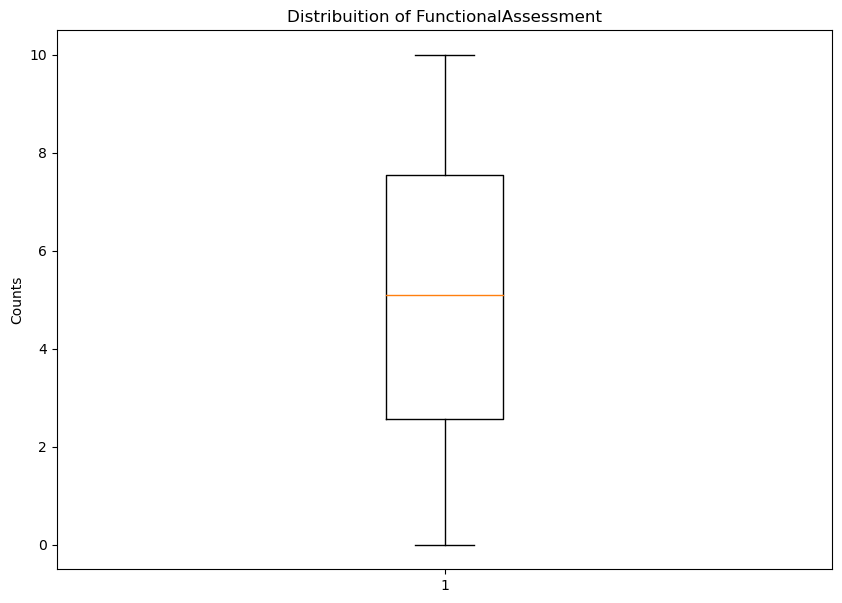

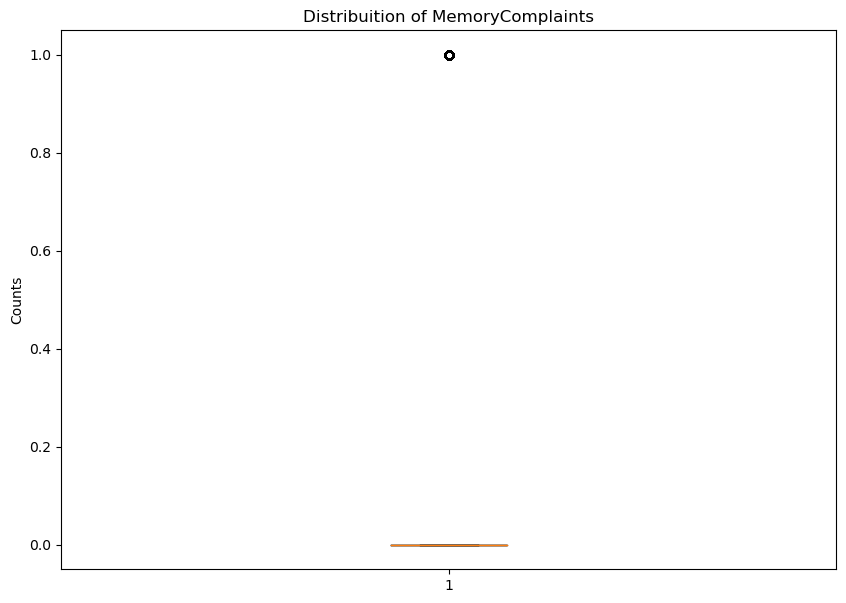

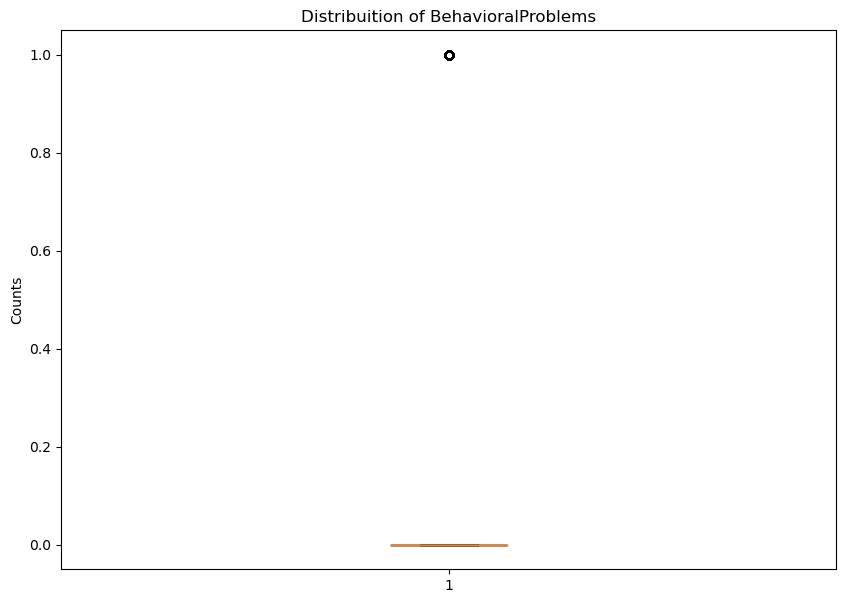

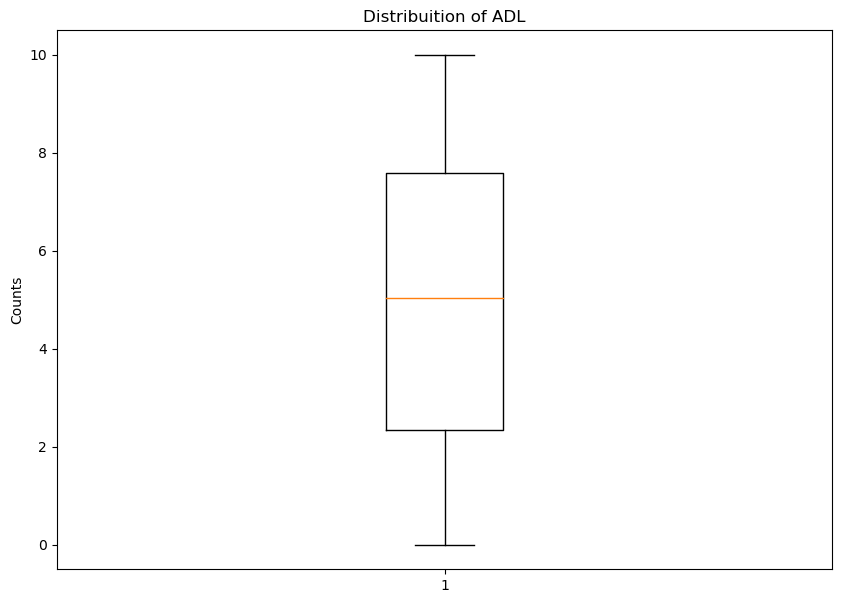

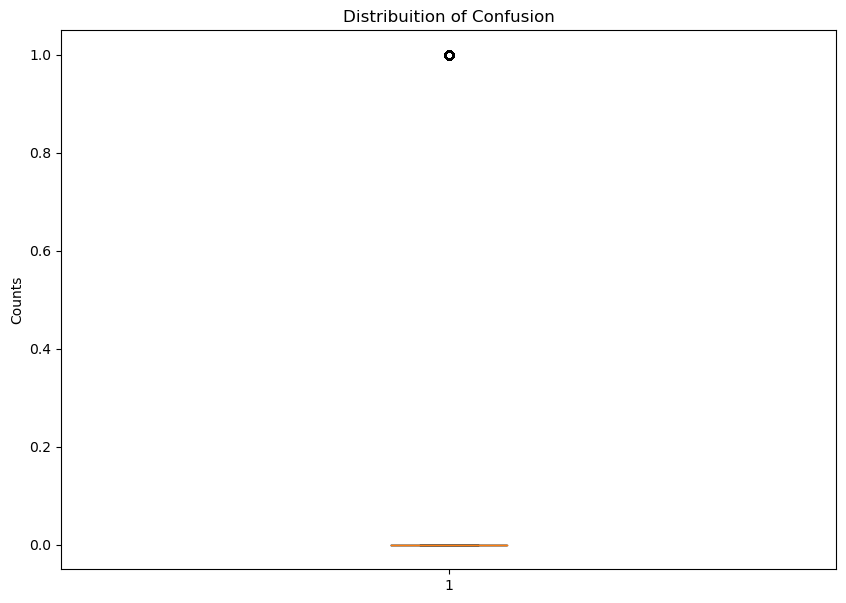

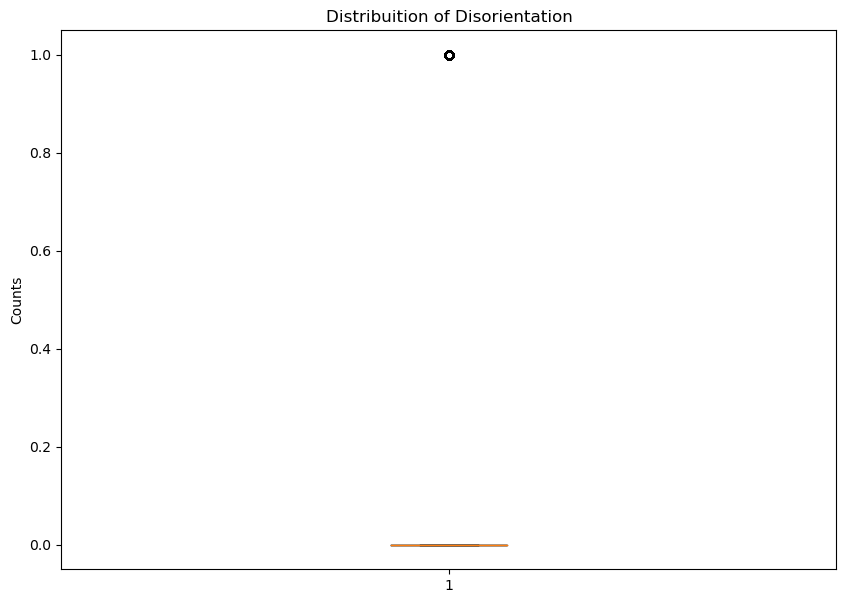

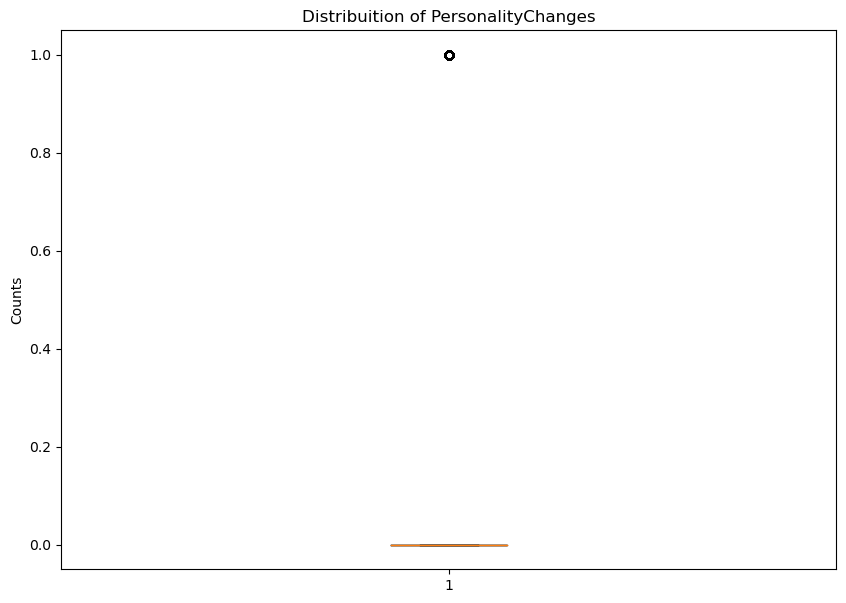

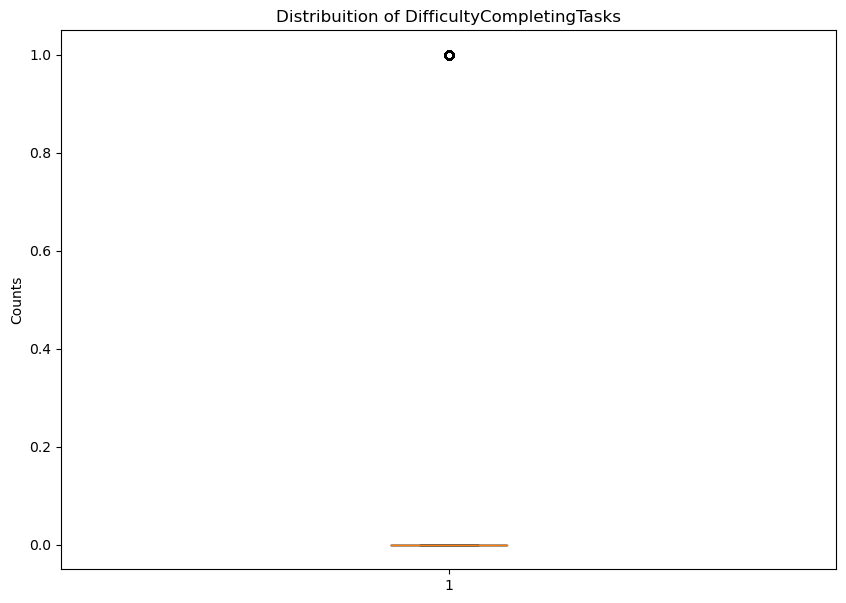

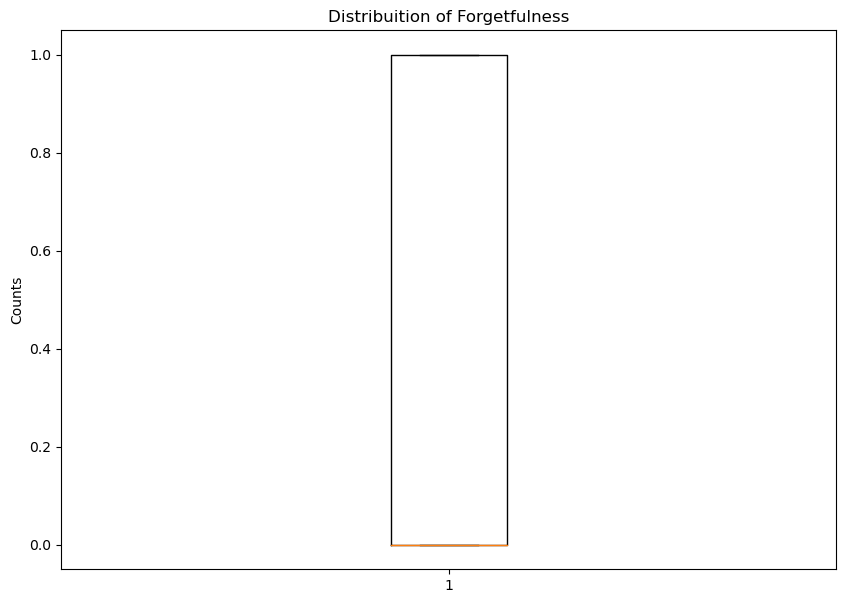

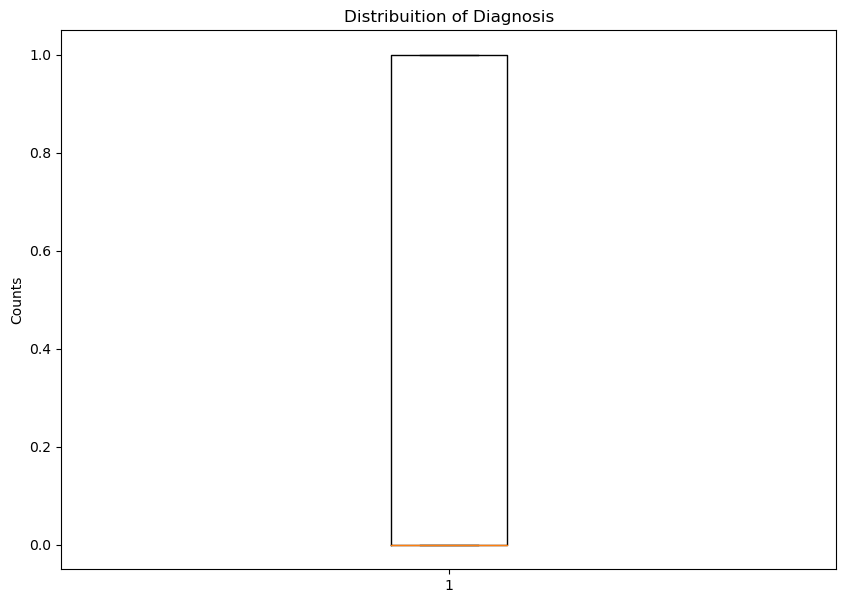

In [52]:
plot_distribution(df, "boxplot")

# Aggregation Views

In [63]:
interested_columns = df.columns[:-1]

# Sum

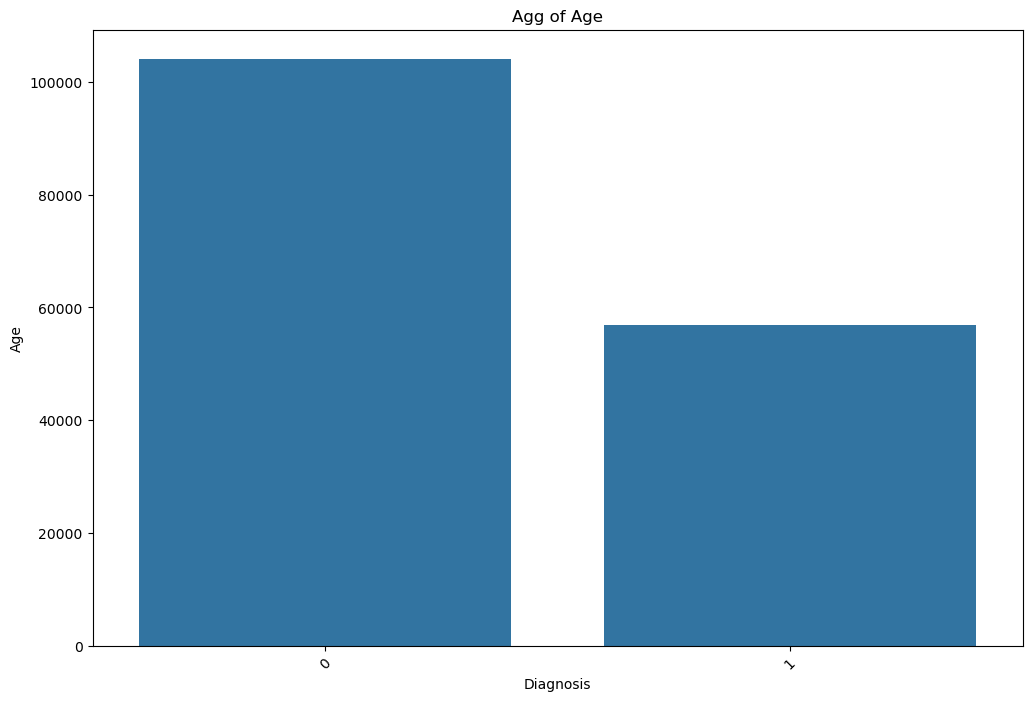

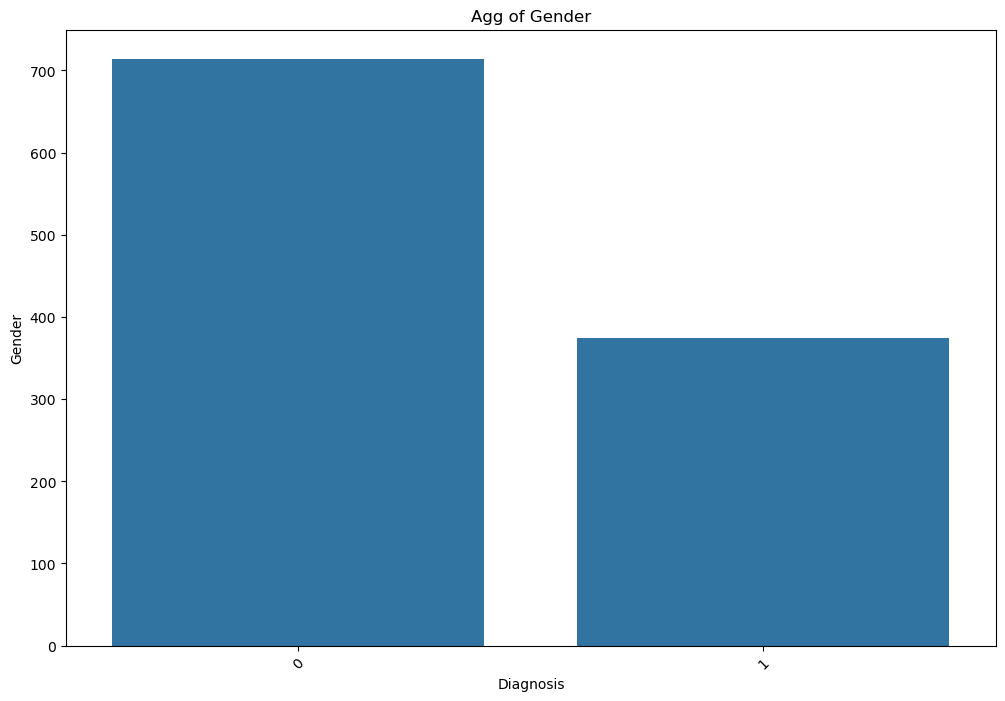

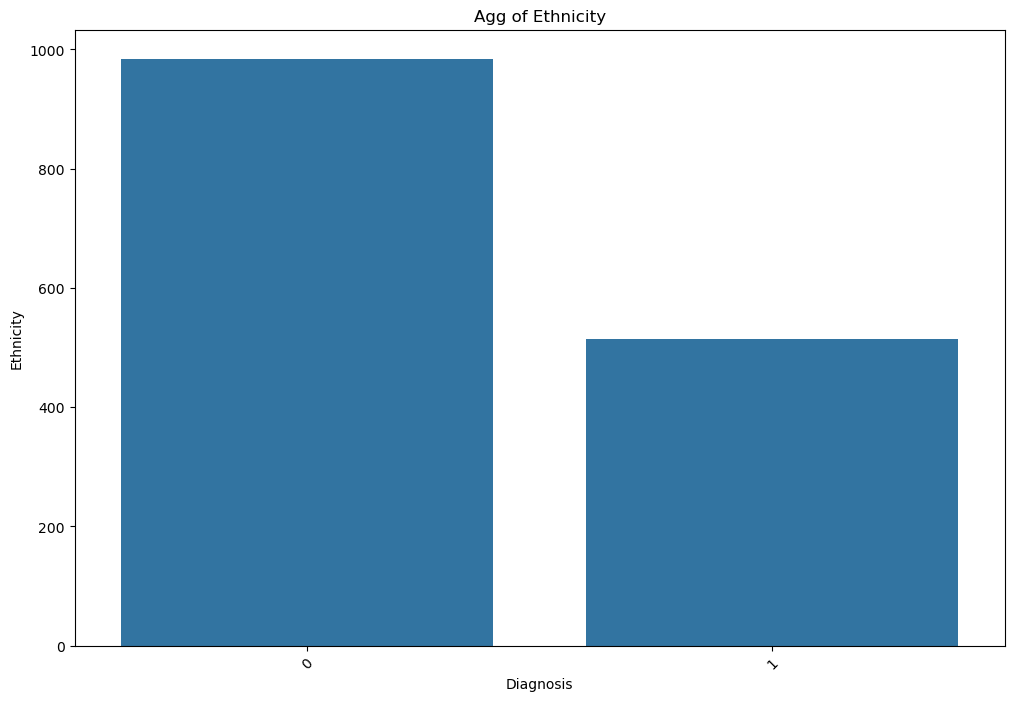

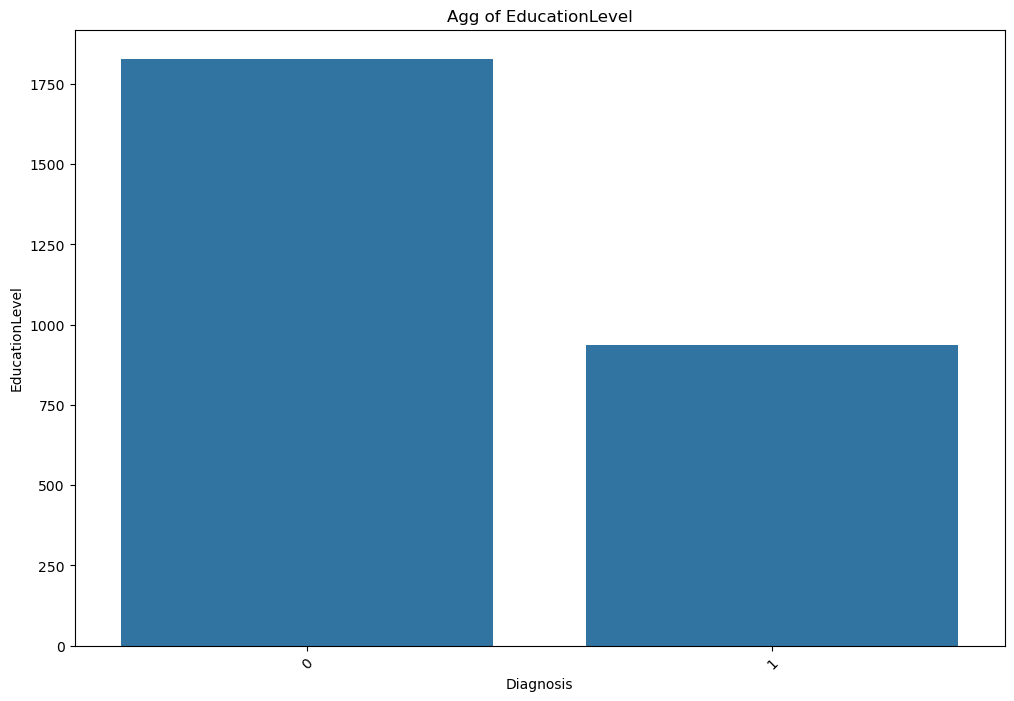

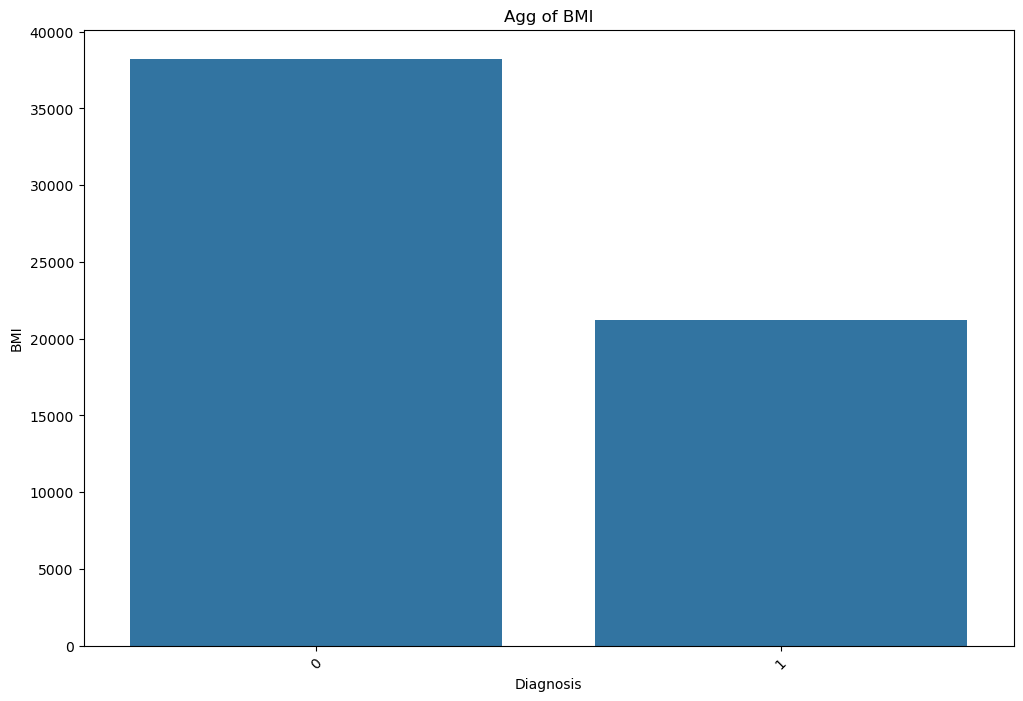

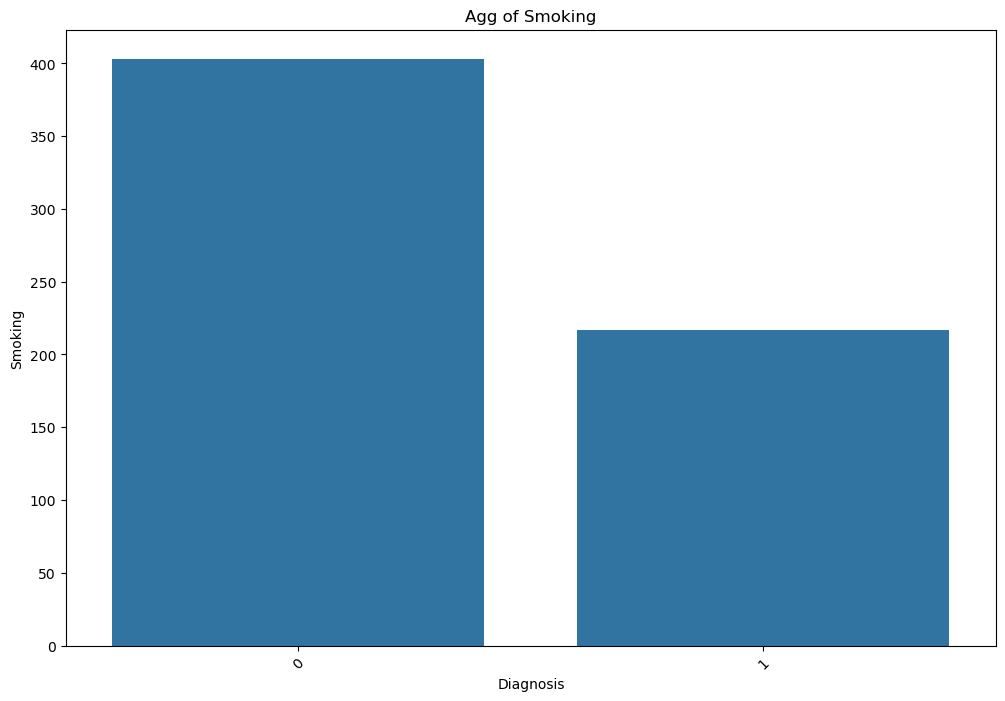

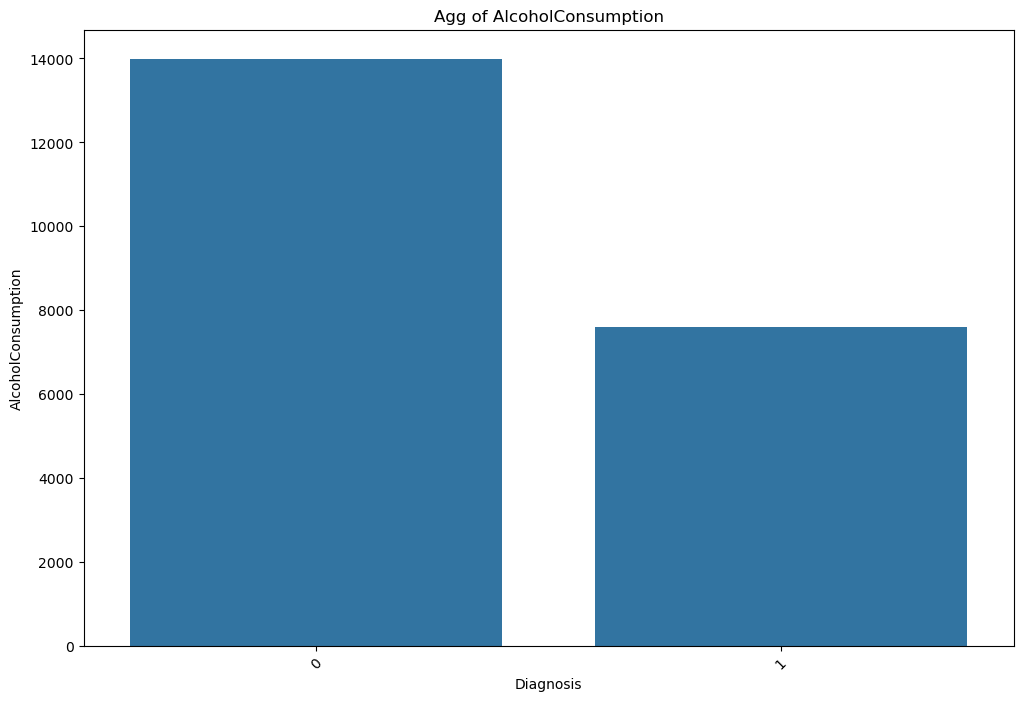

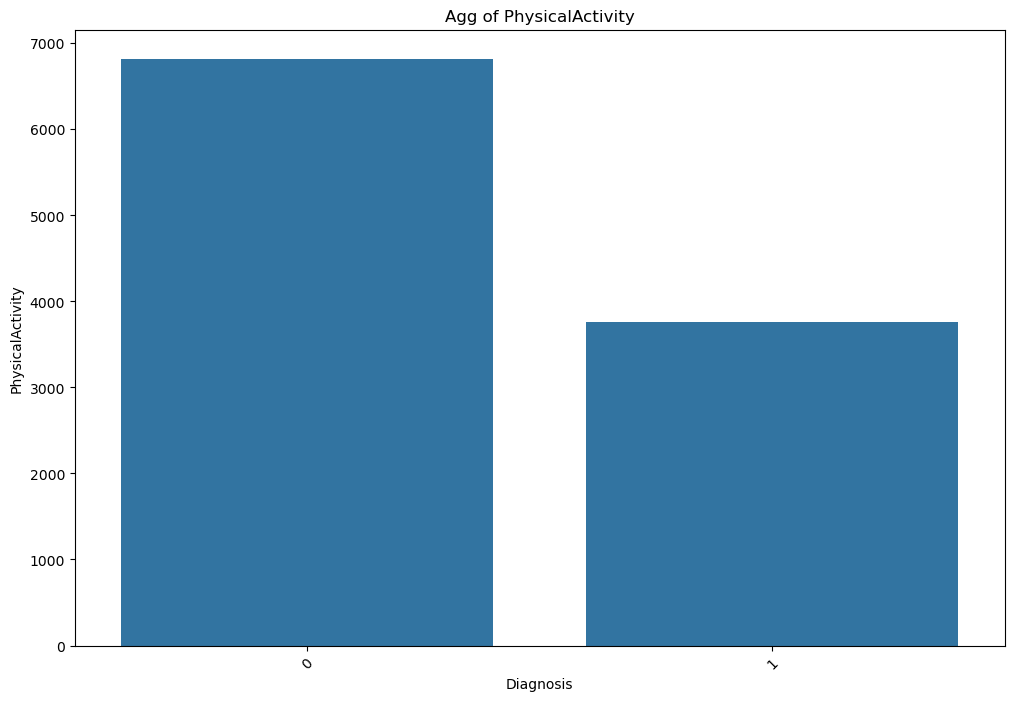

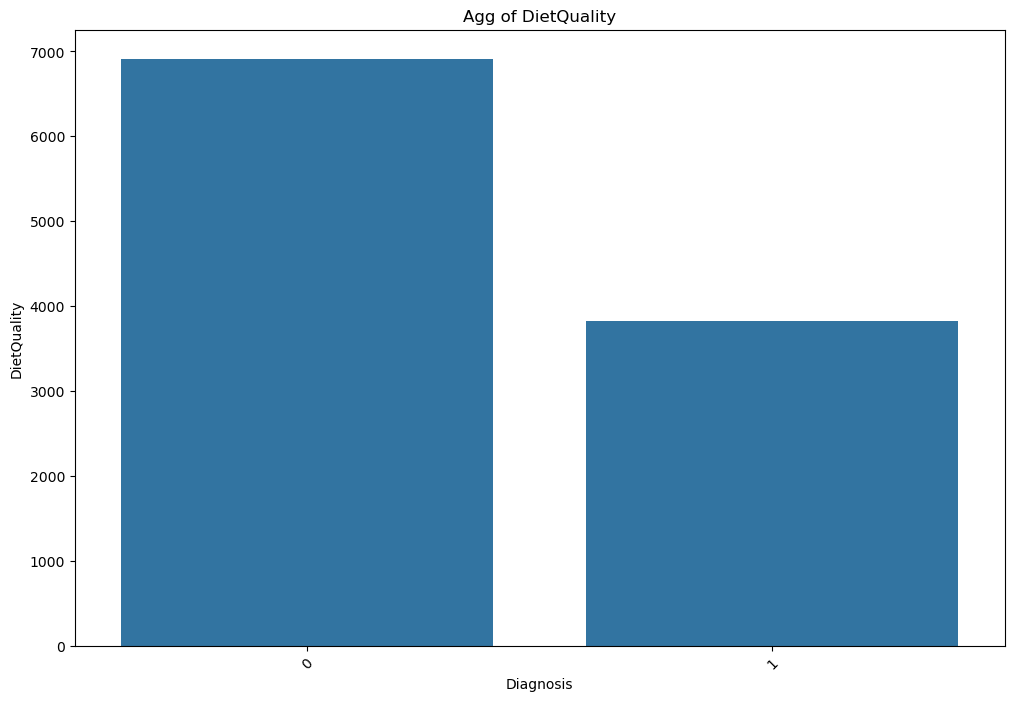

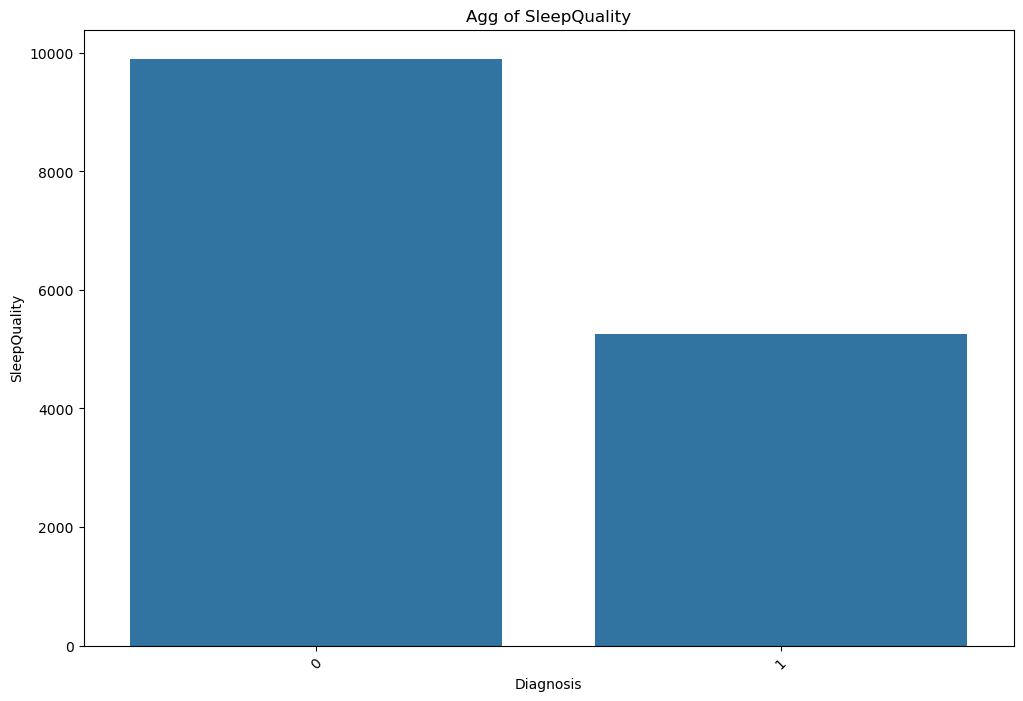

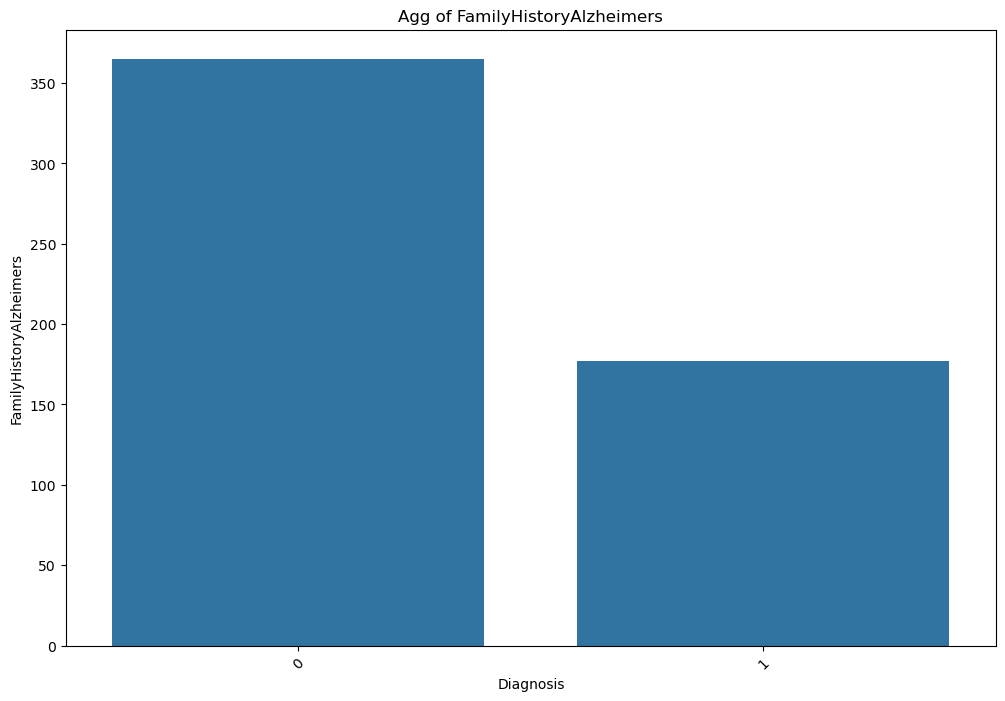

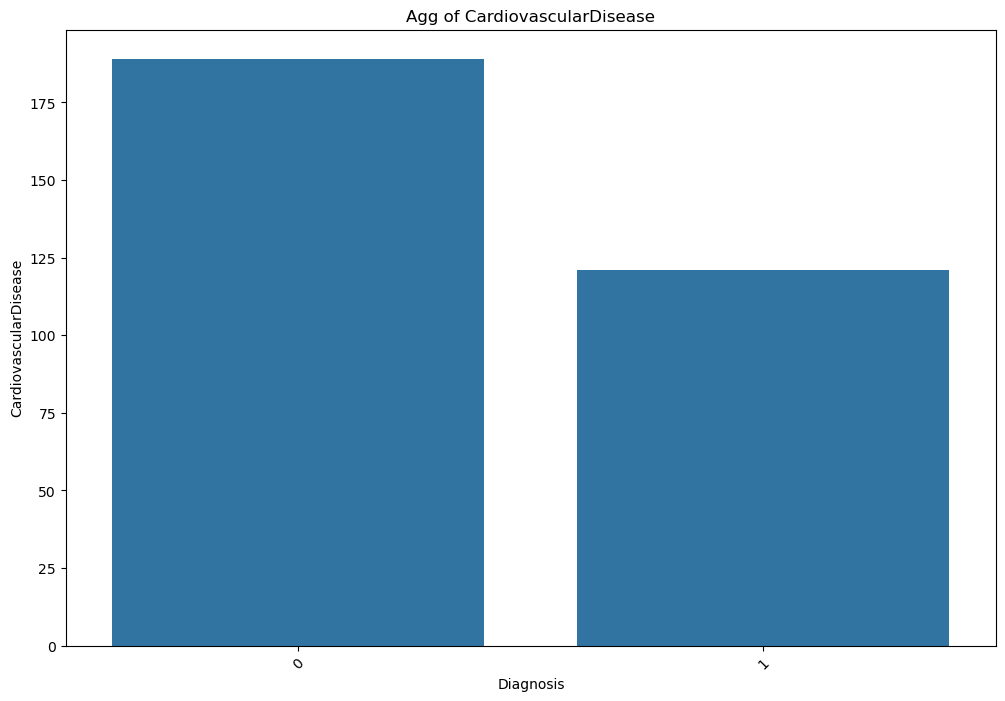

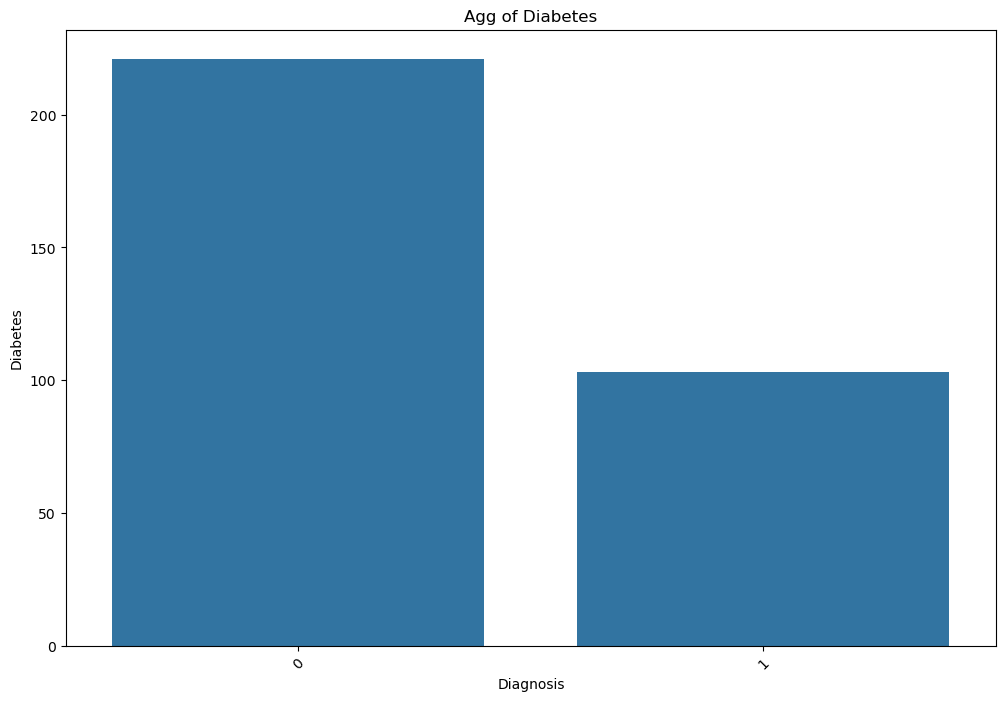

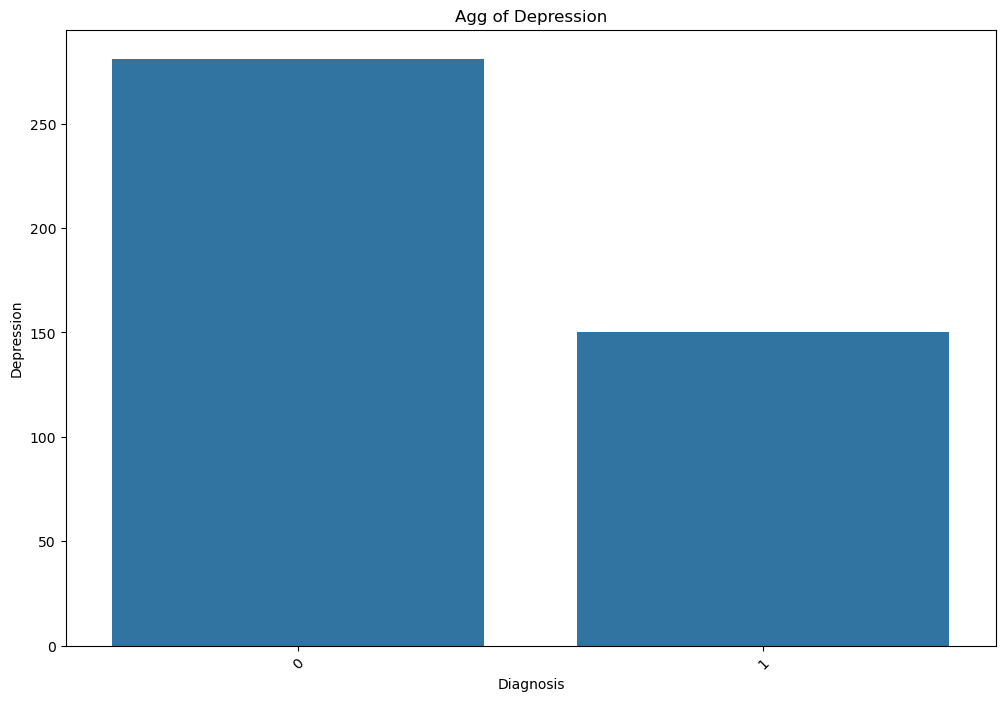

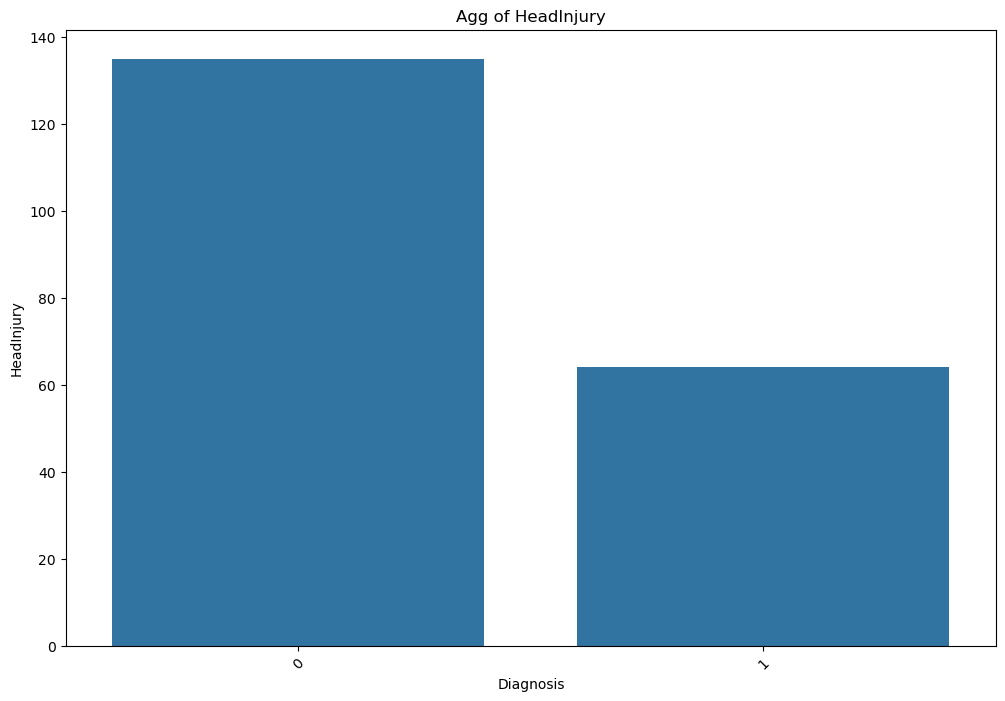

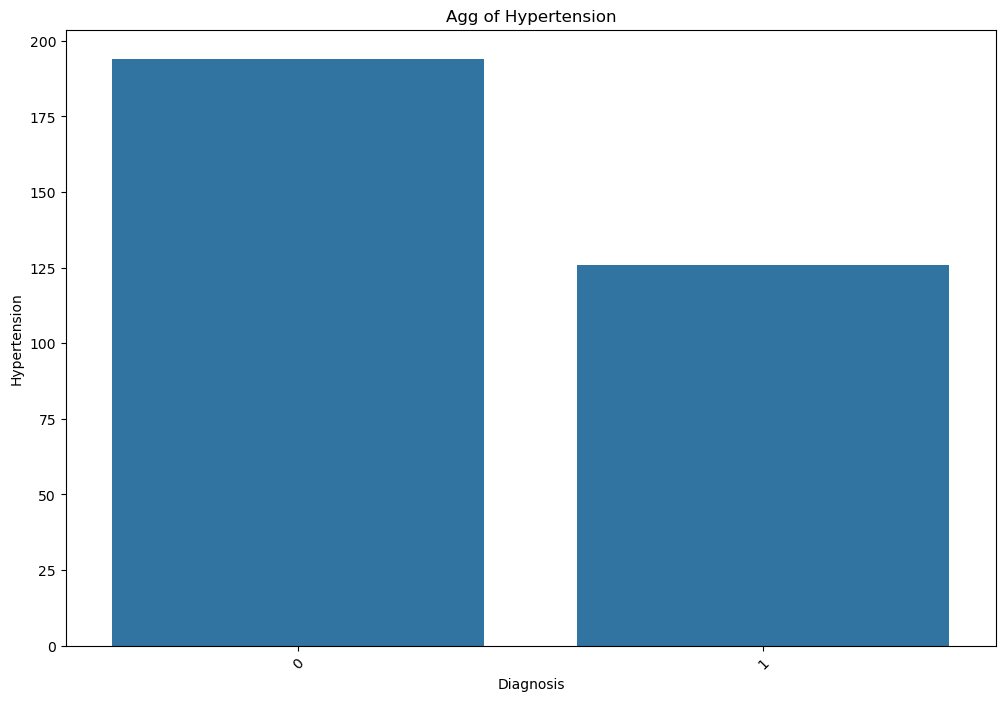

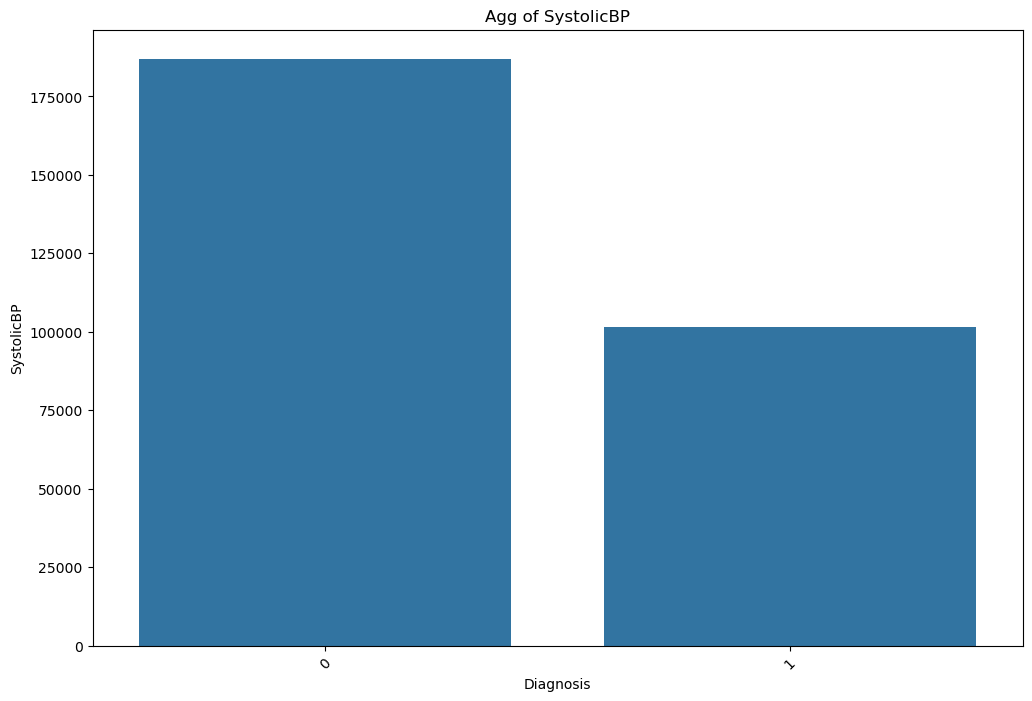

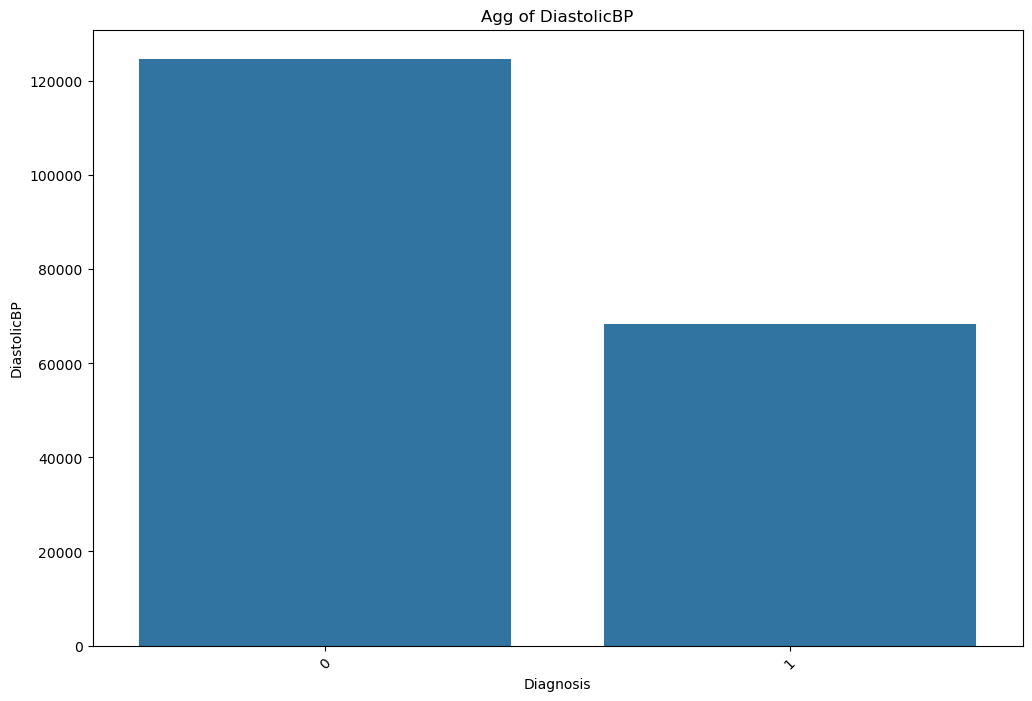

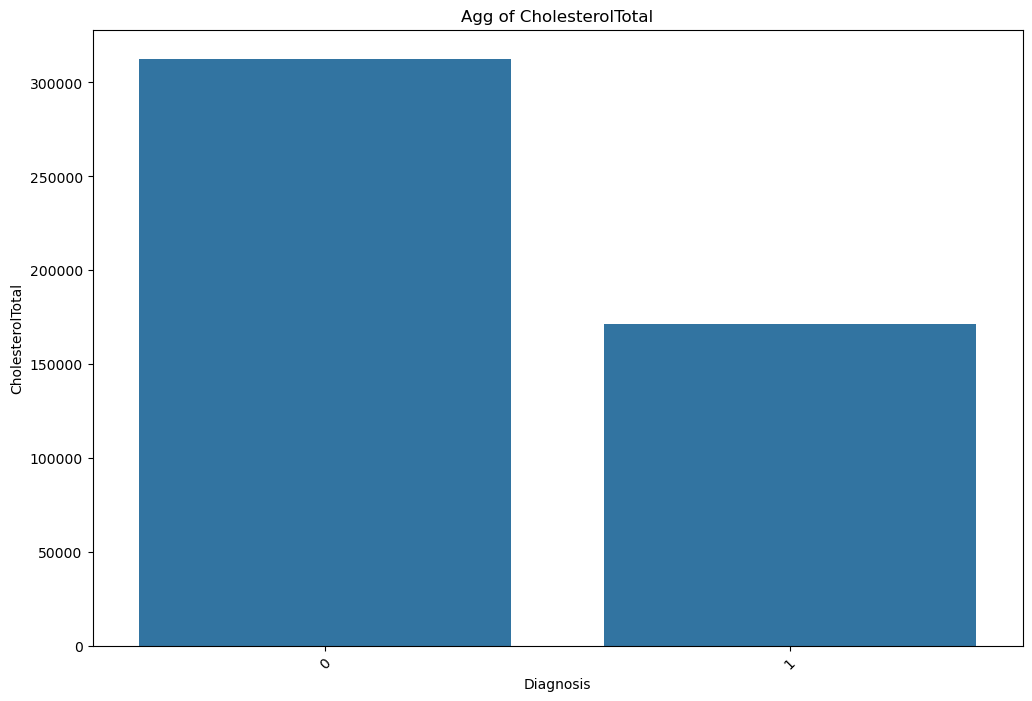

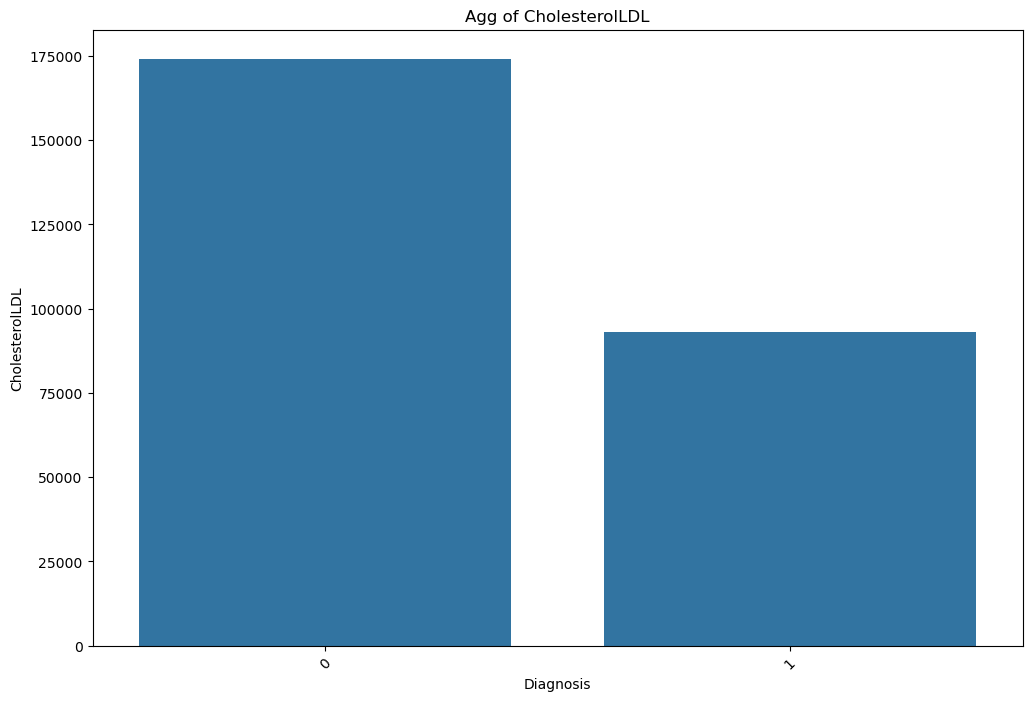

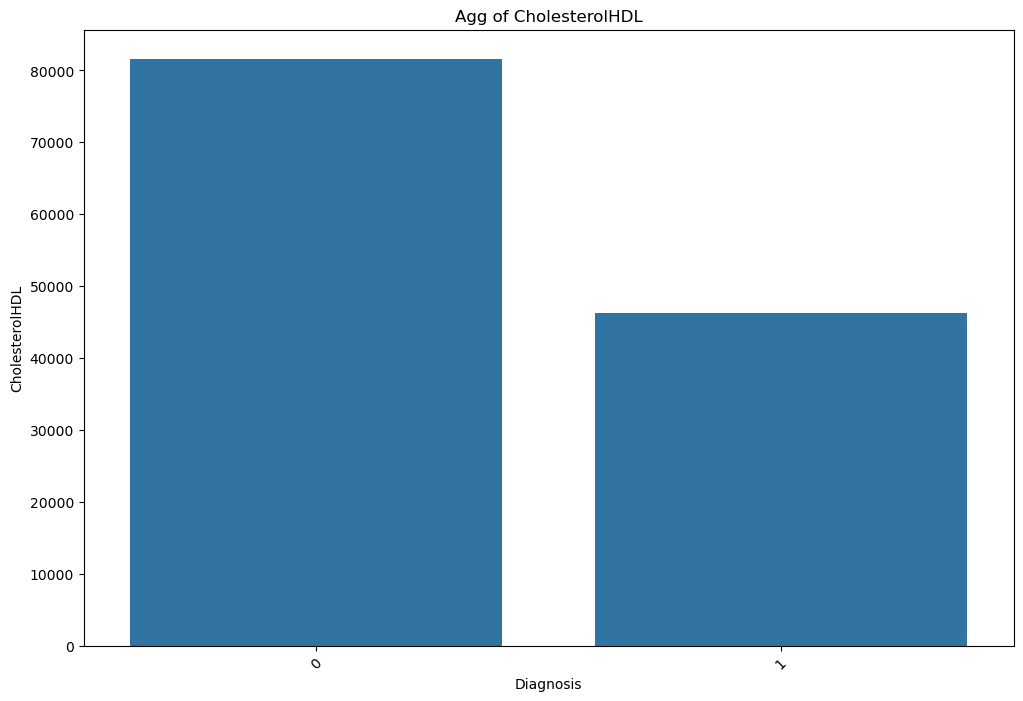

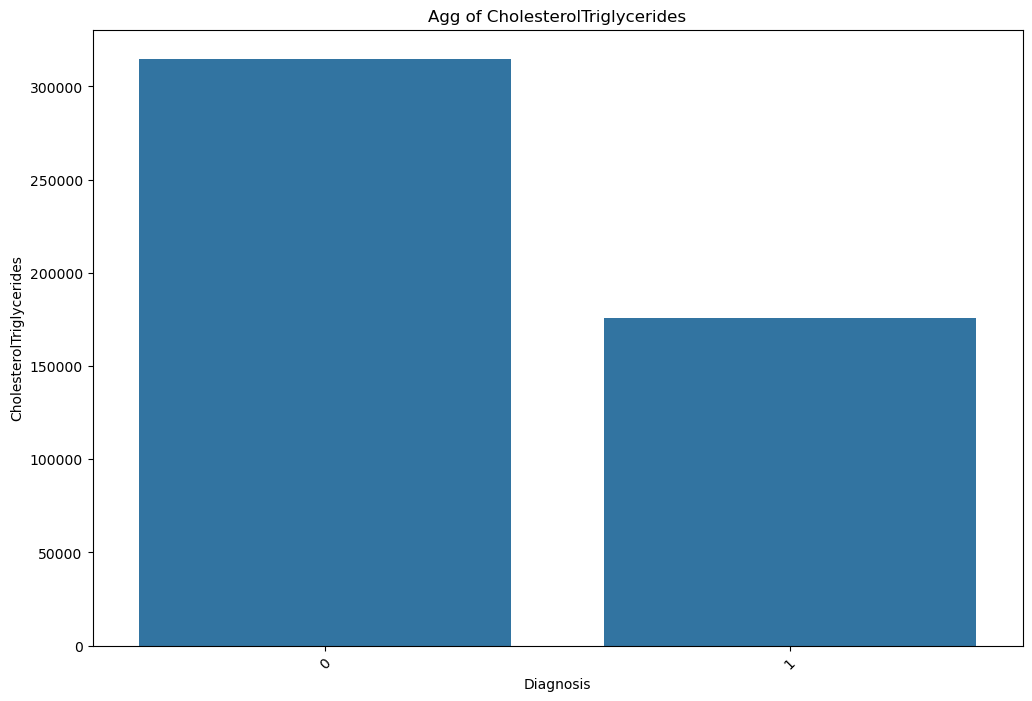

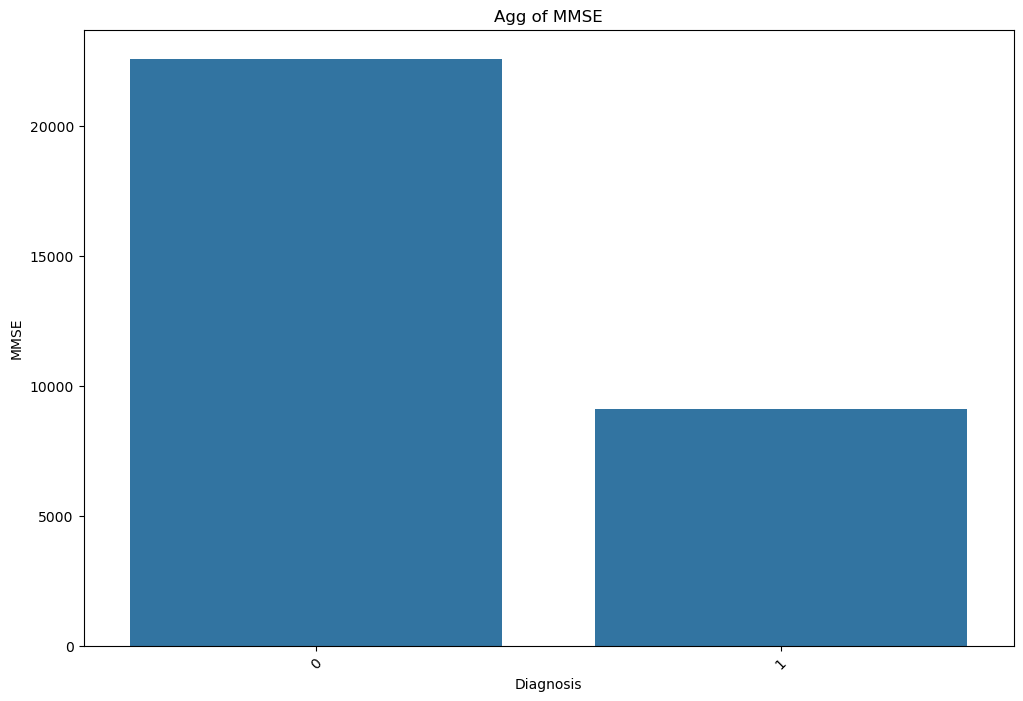

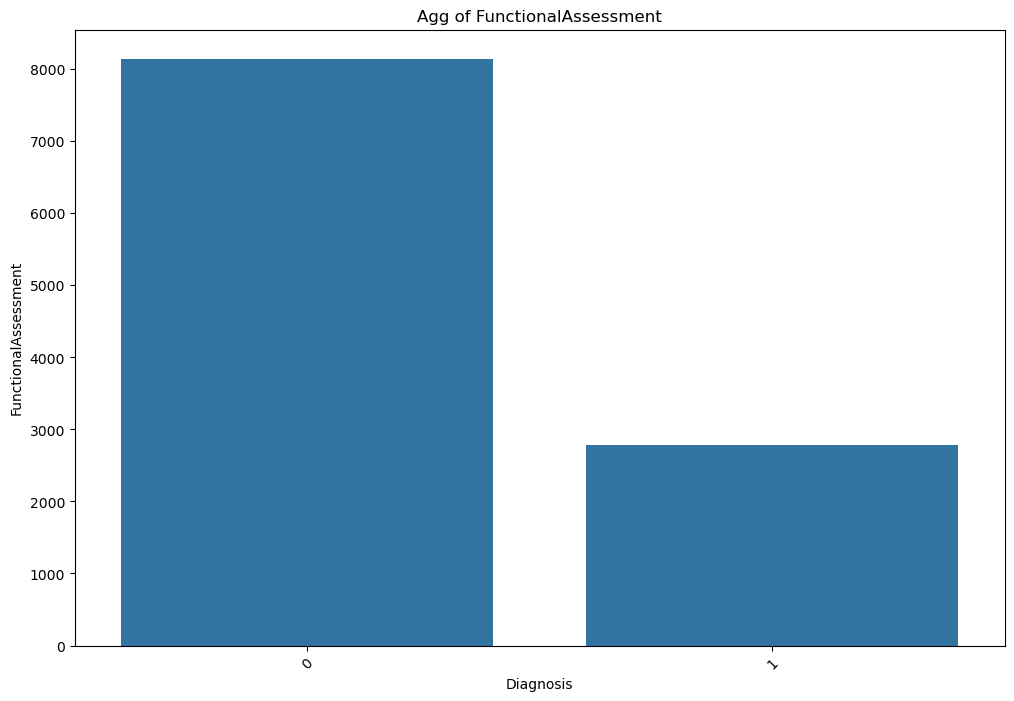

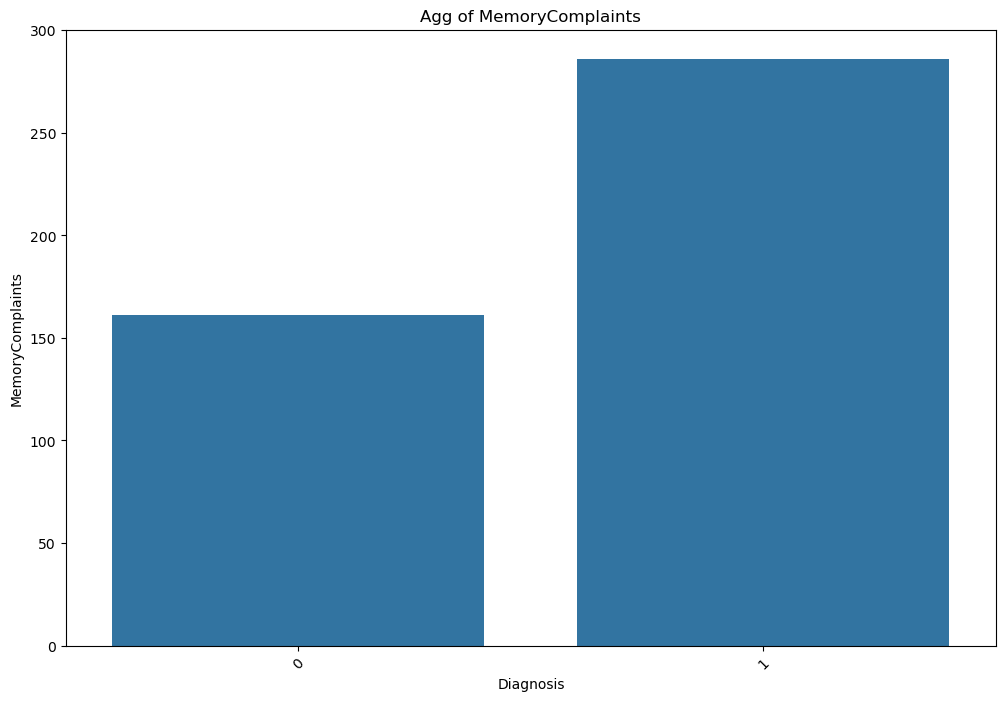

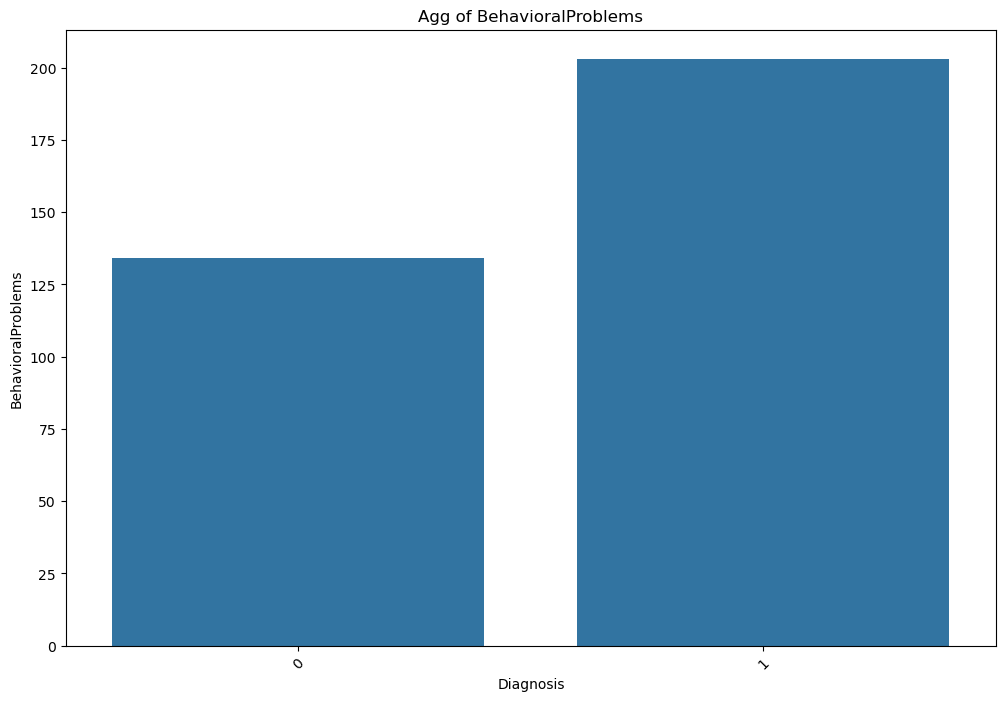

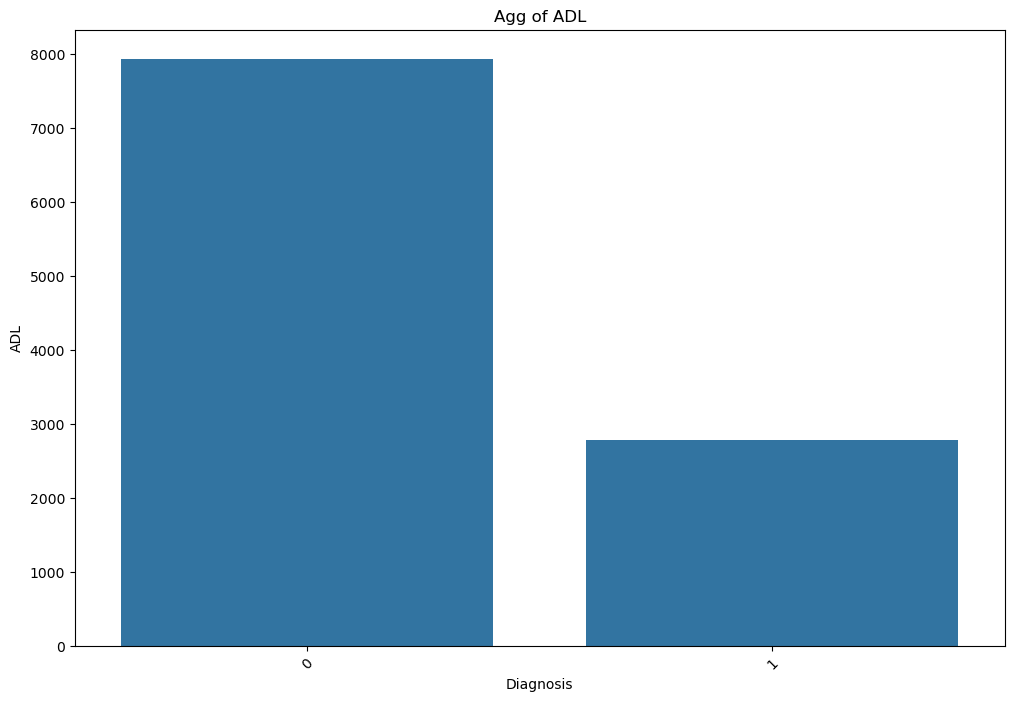

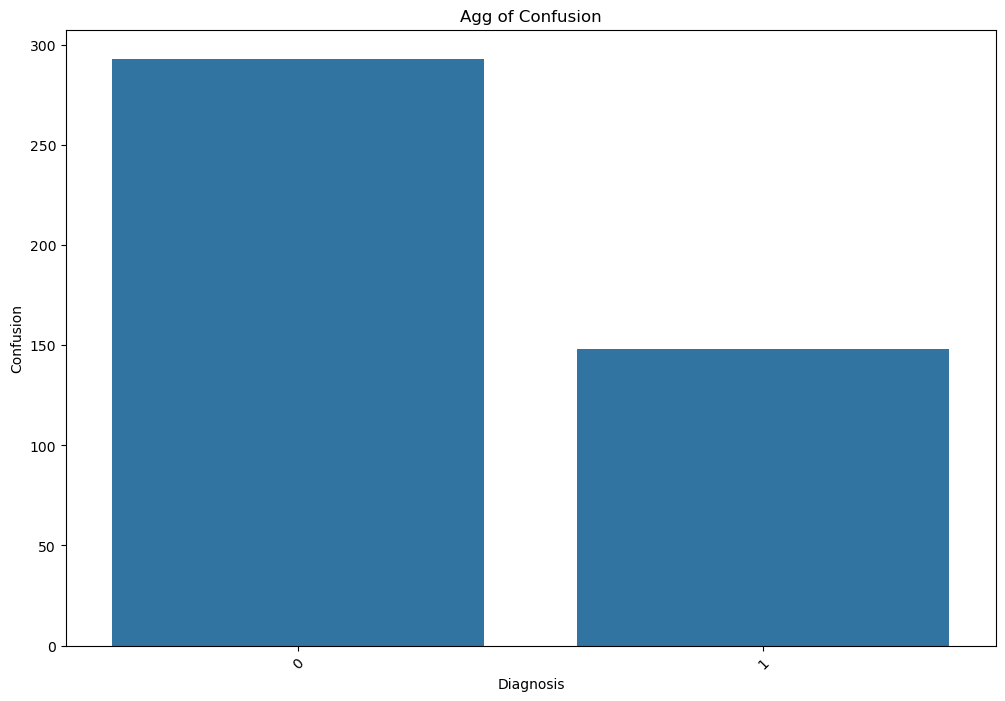

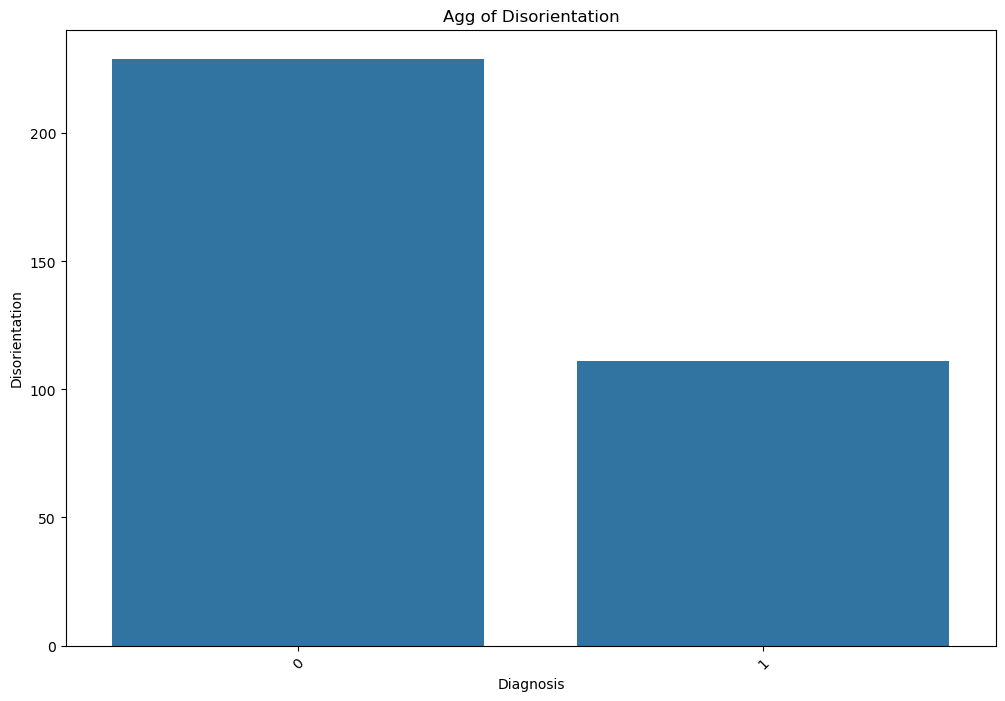

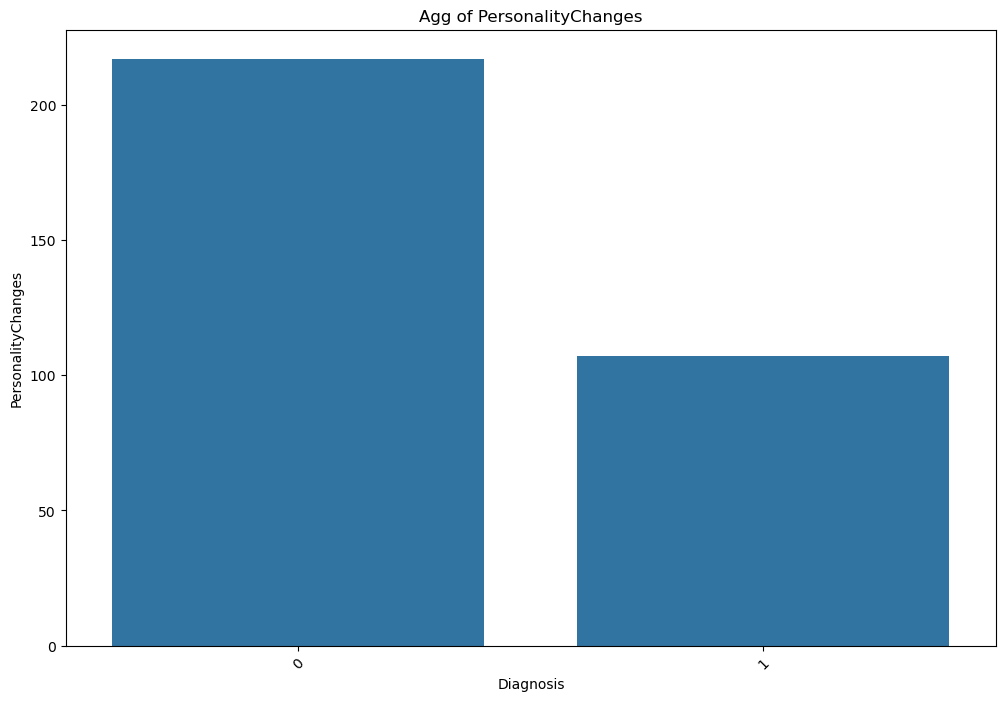

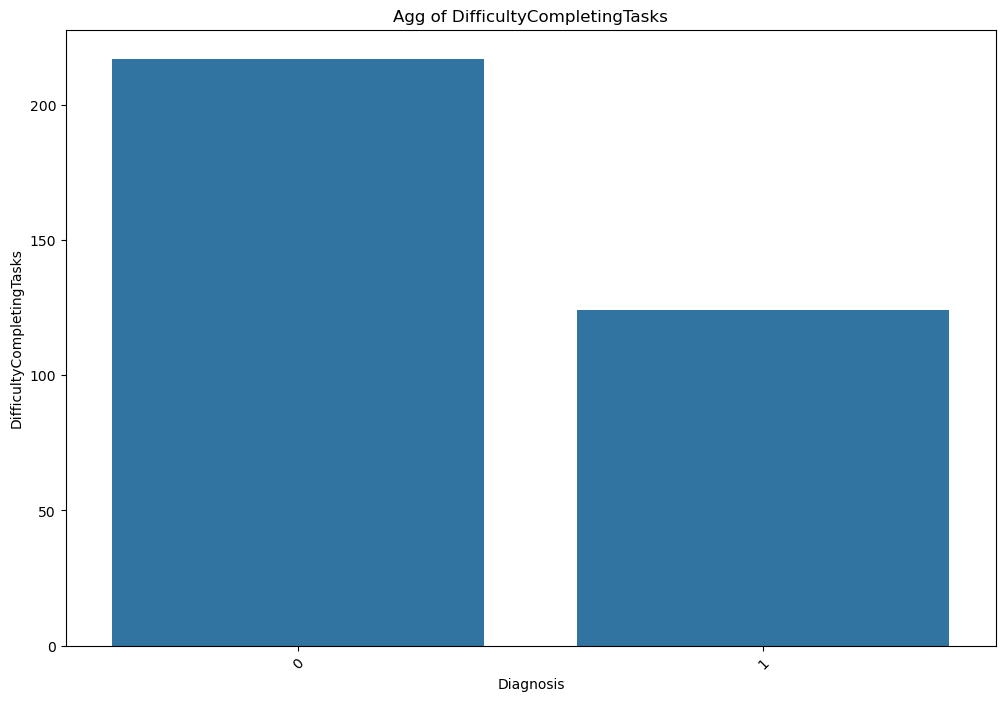

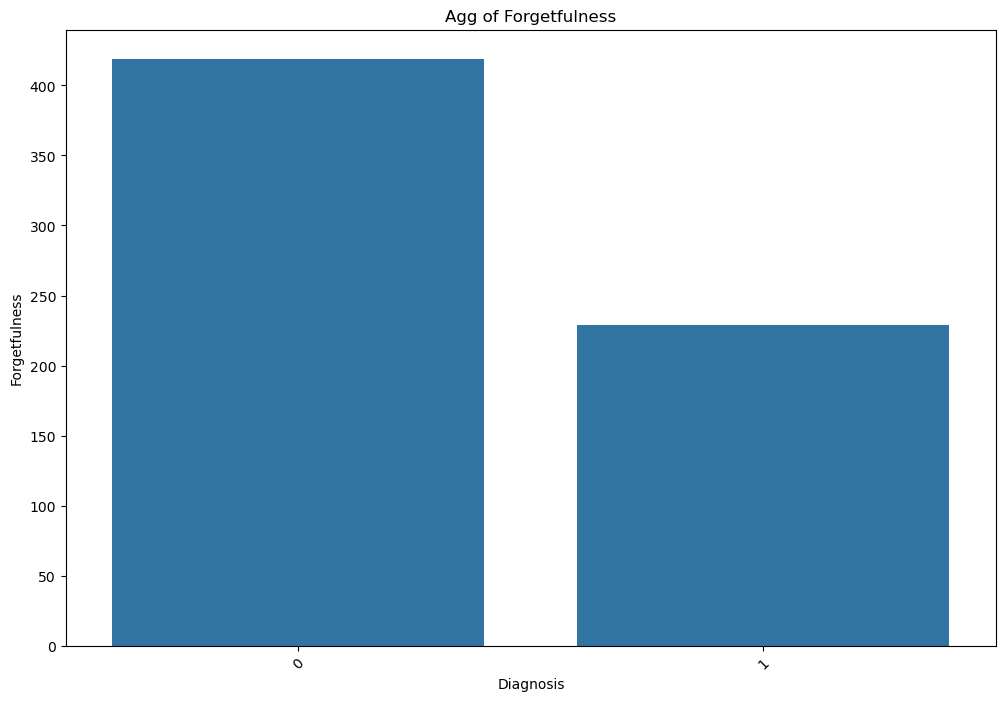

In [64]:
aggregate_dataset(df, interested_columns,"Diagnosis", "sum")

# Mean

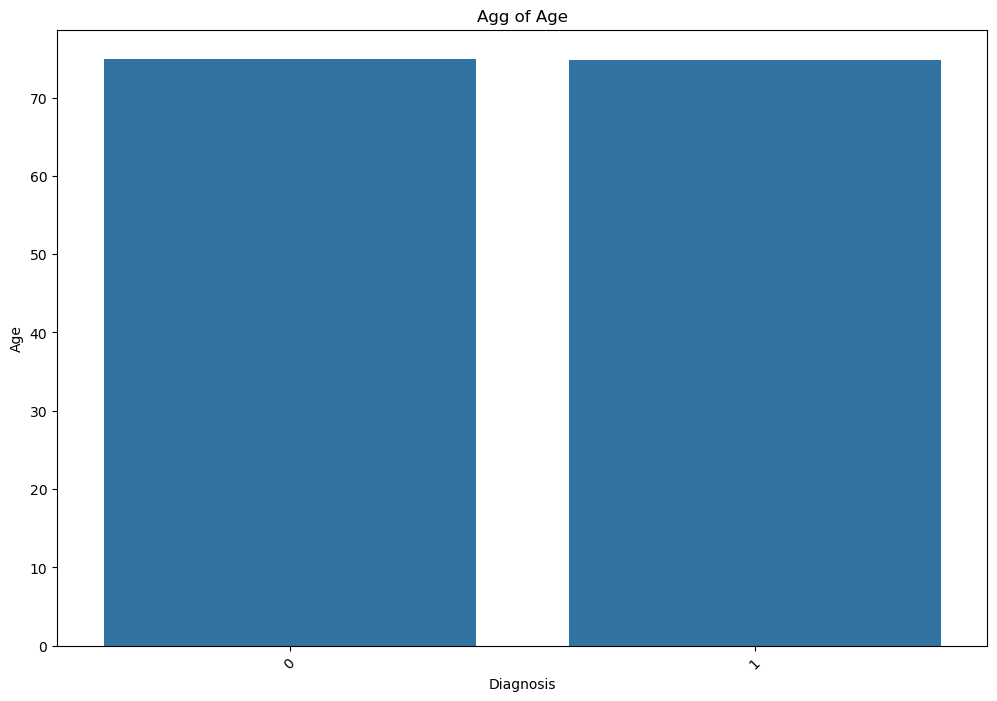

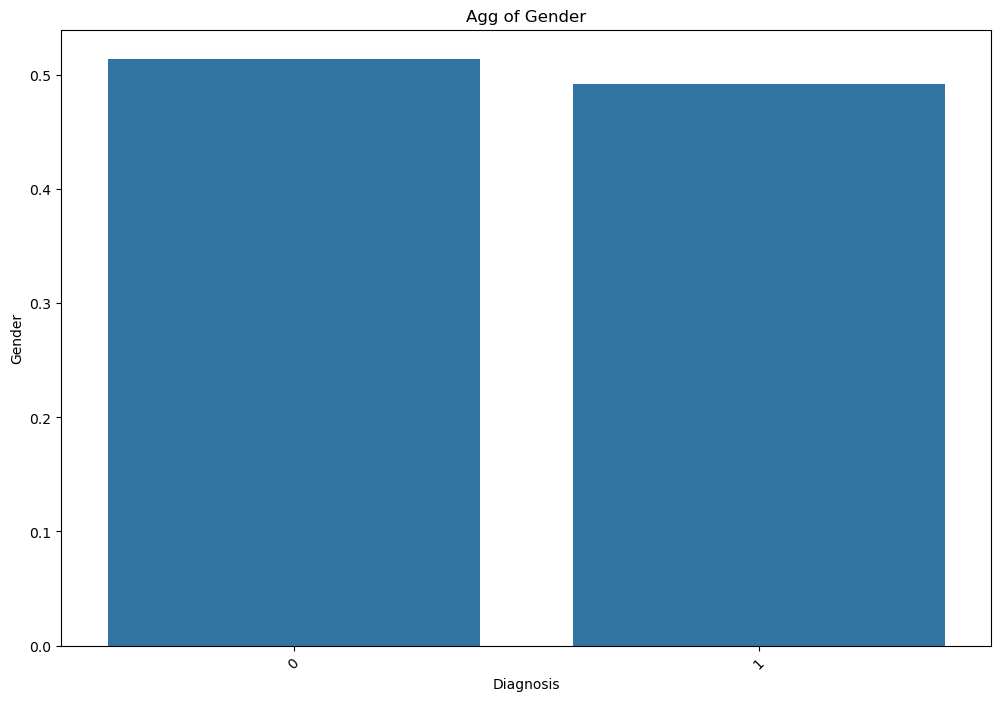

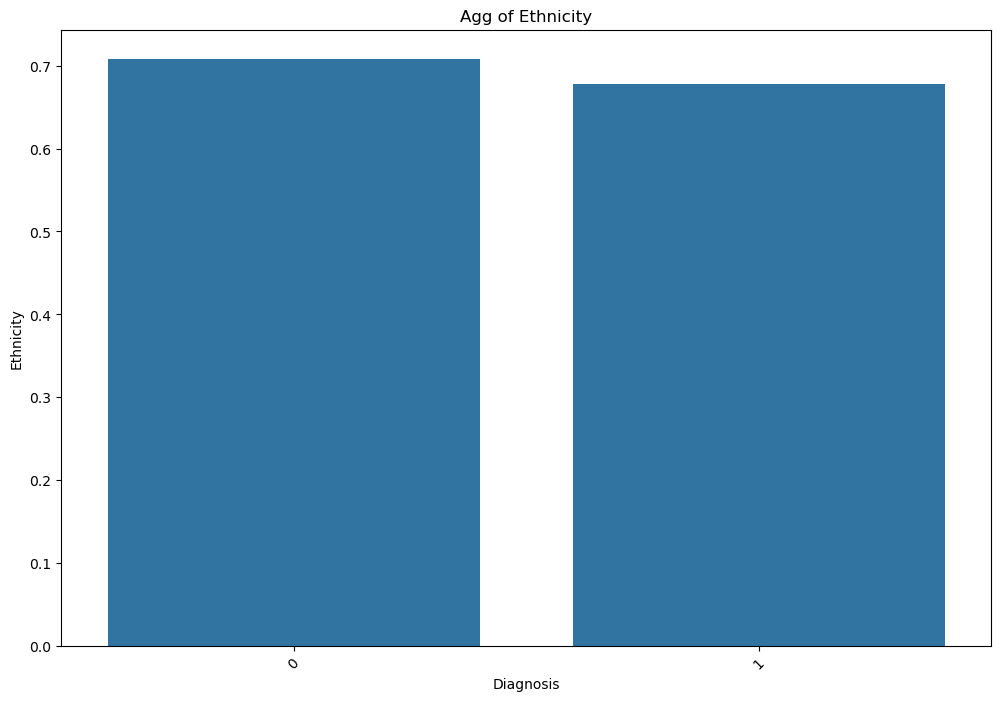

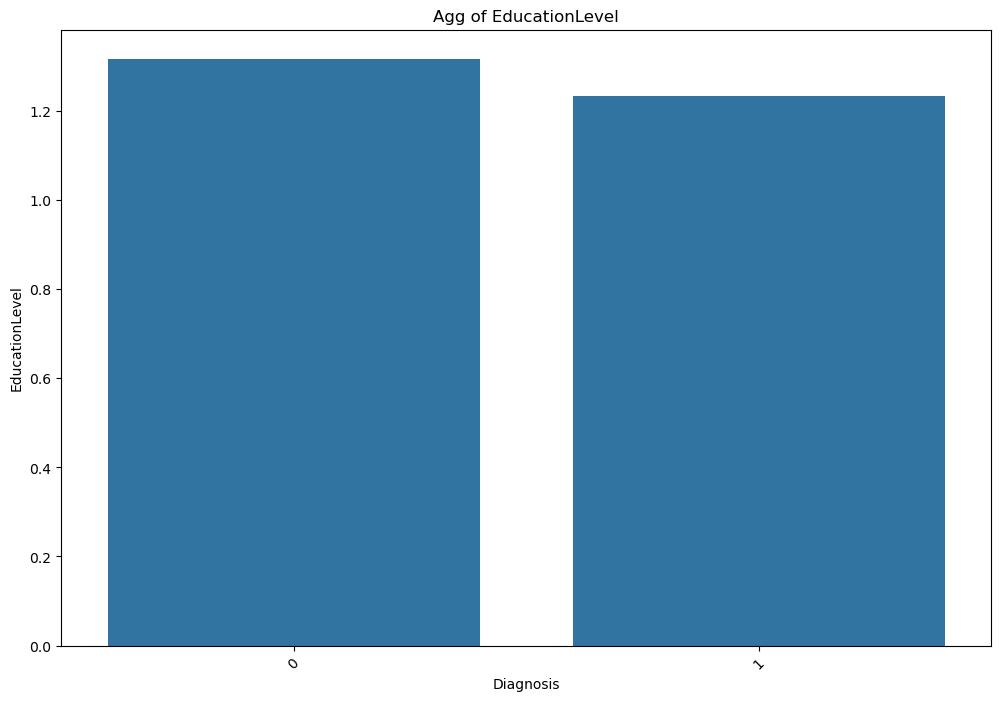

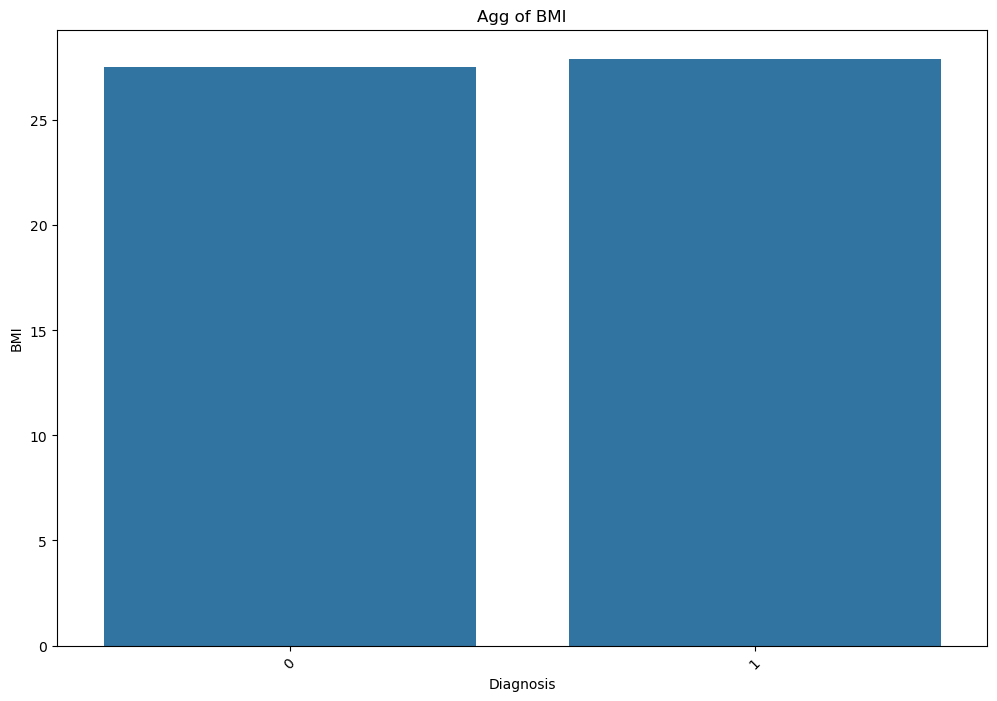

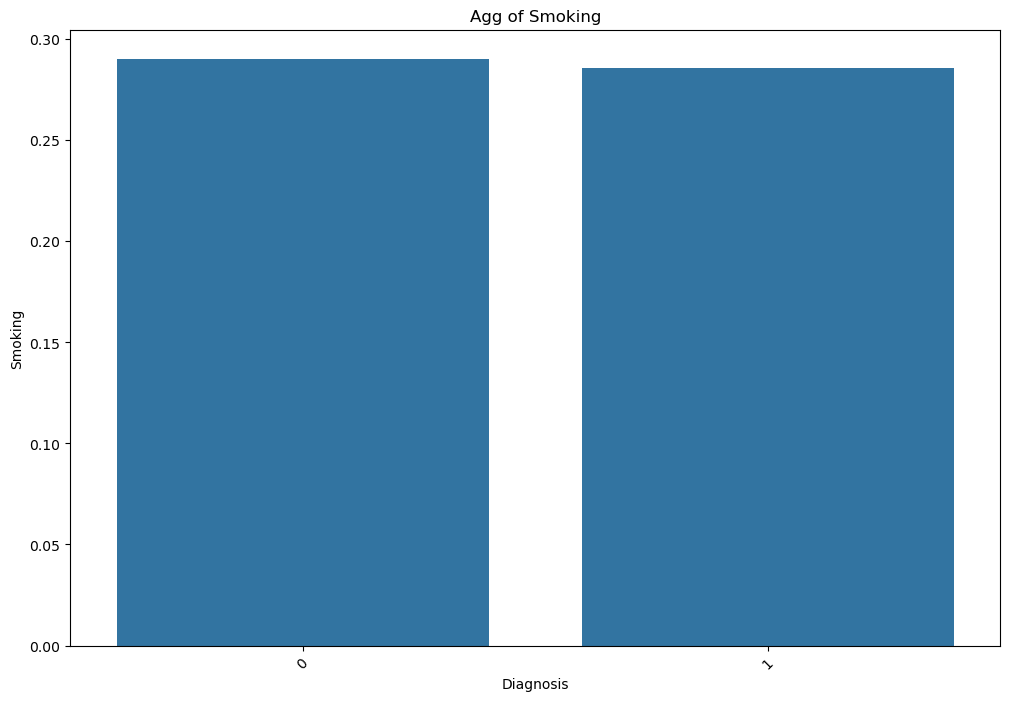

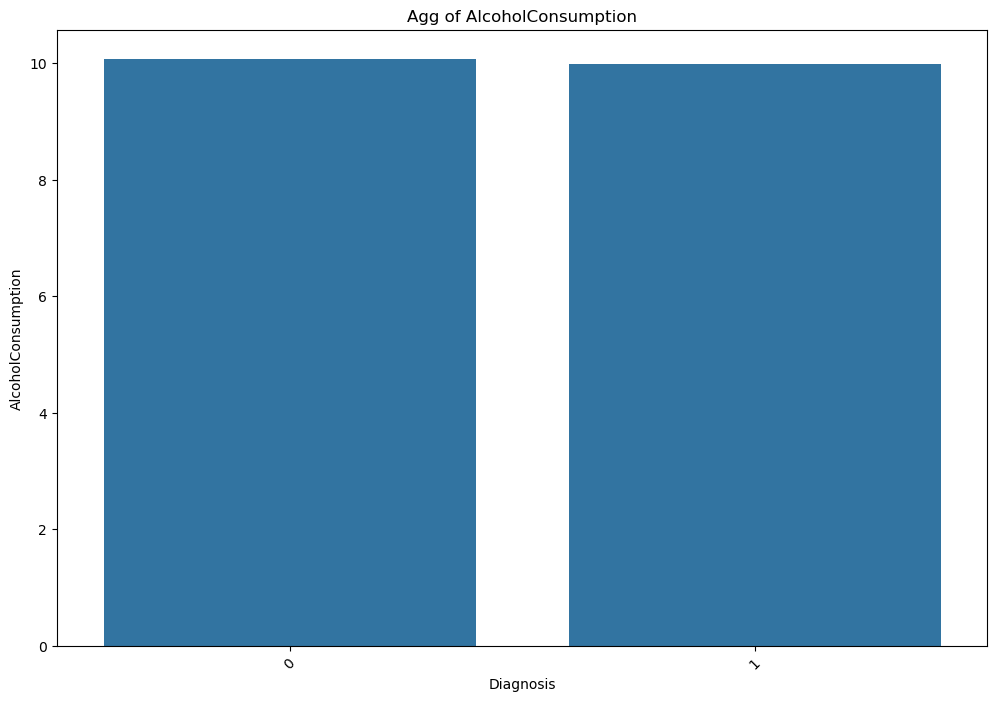

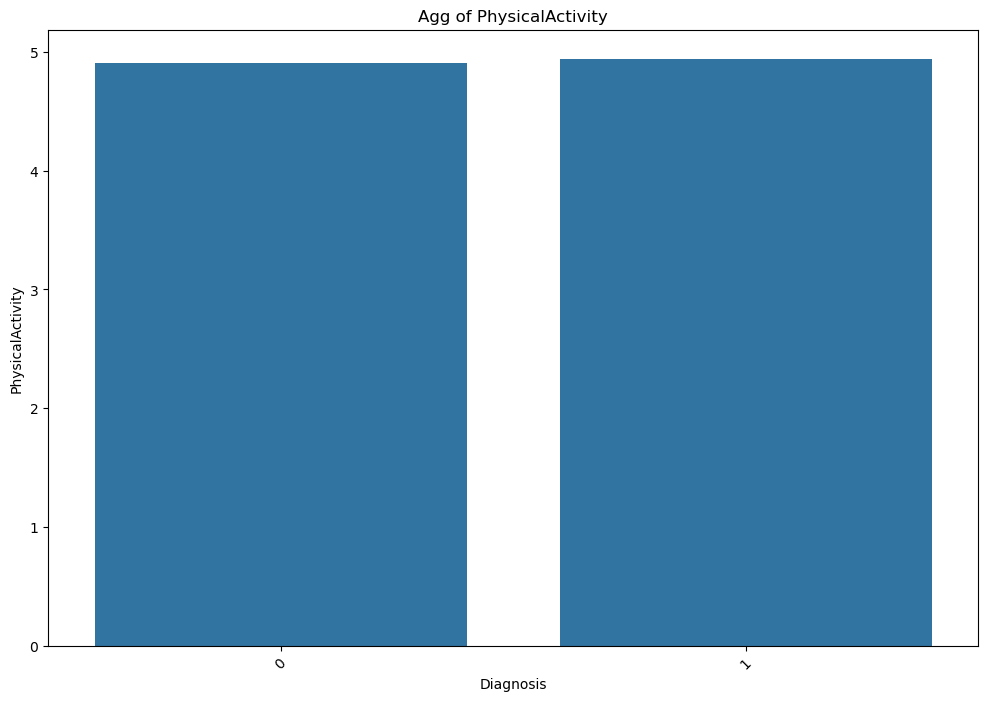

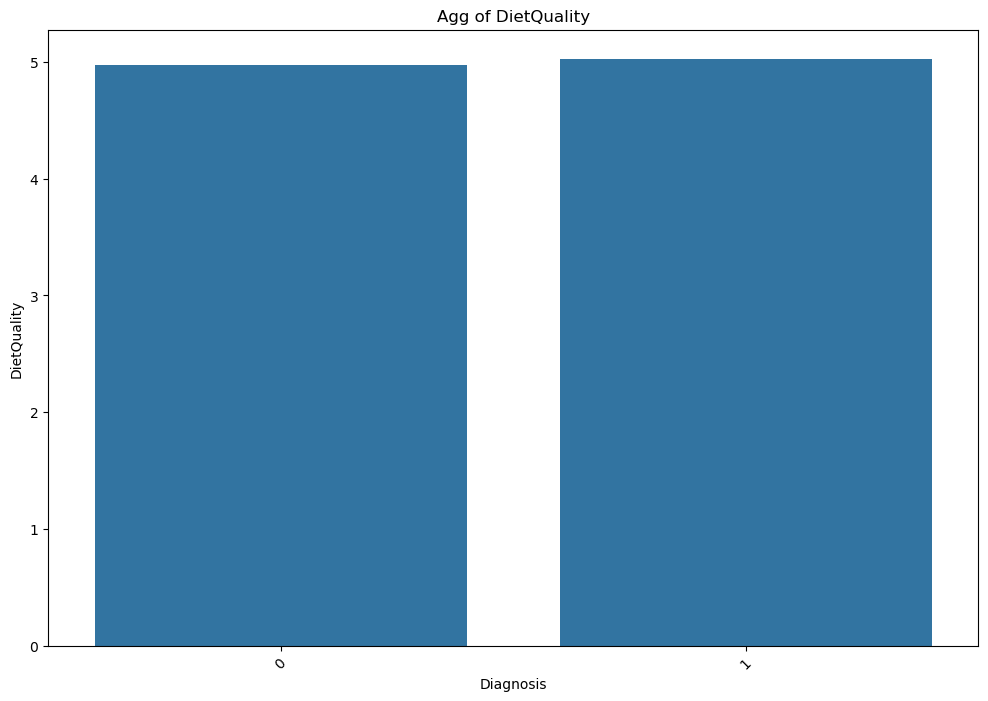

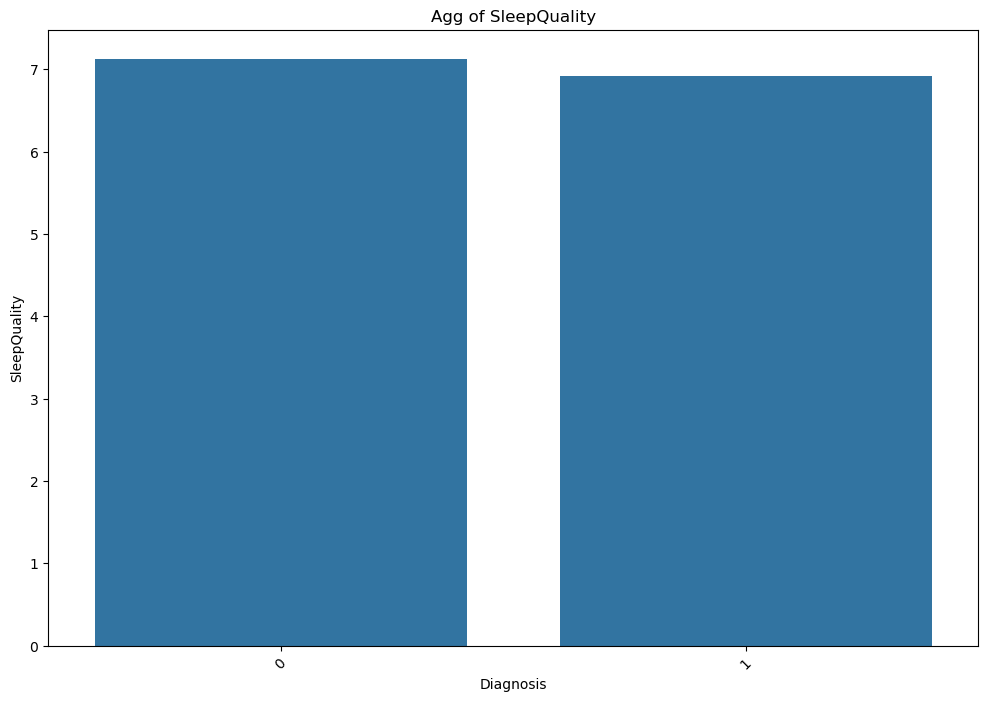

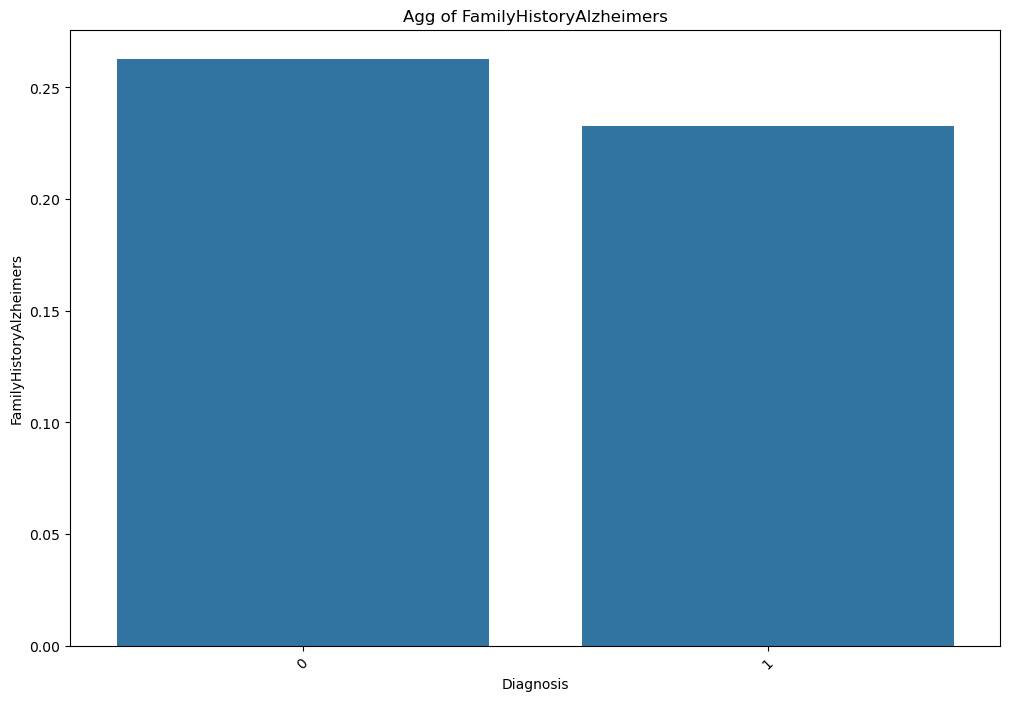

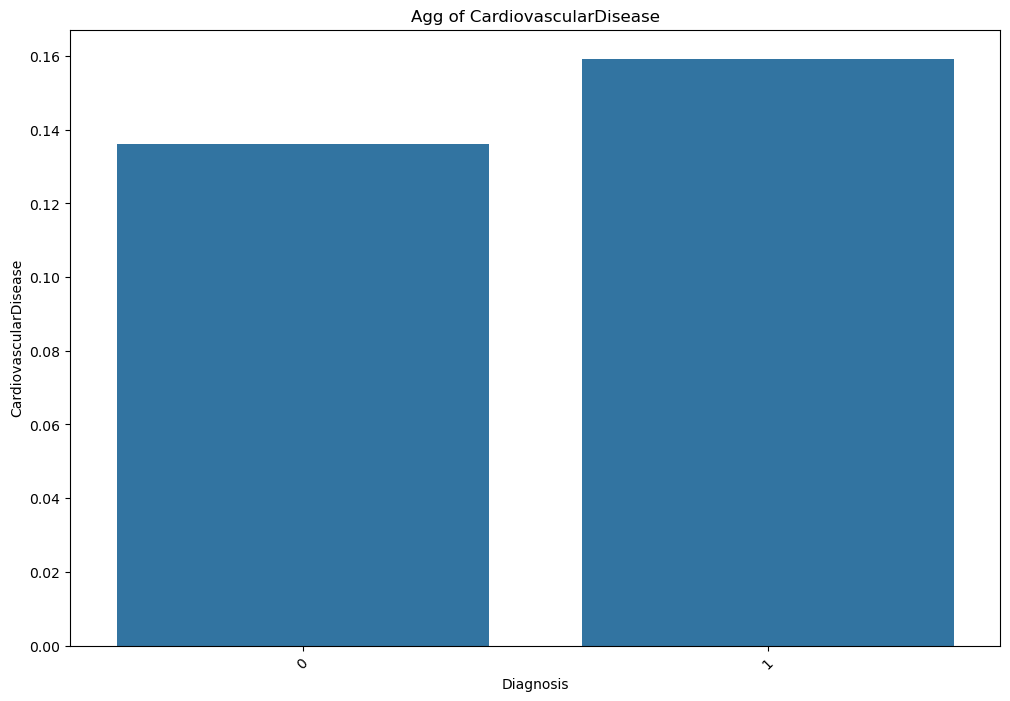

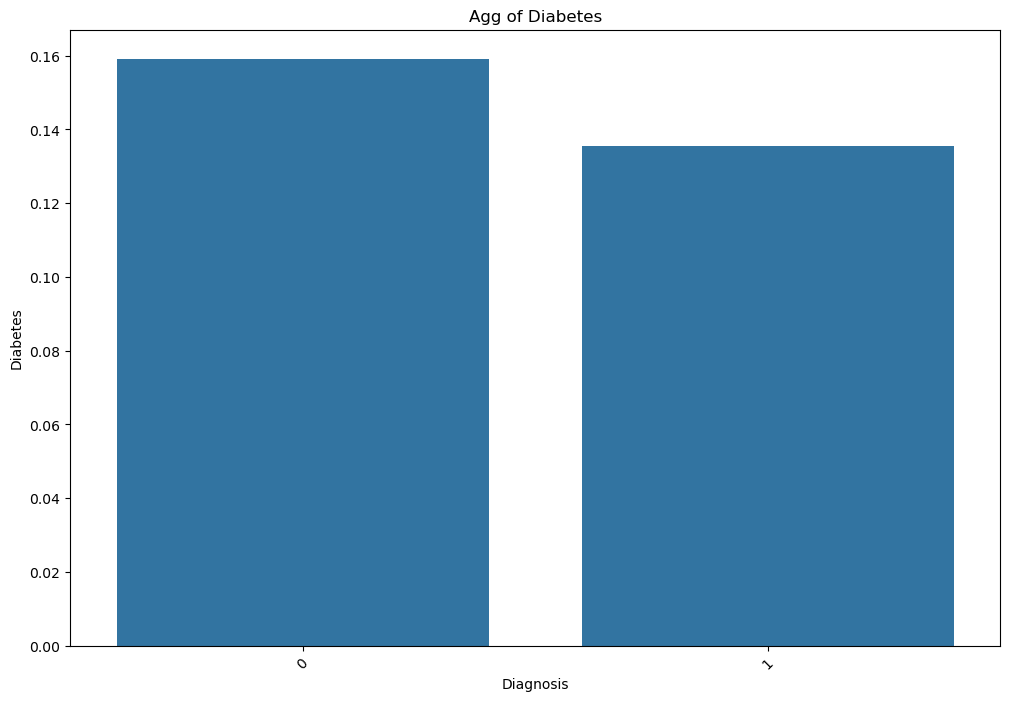

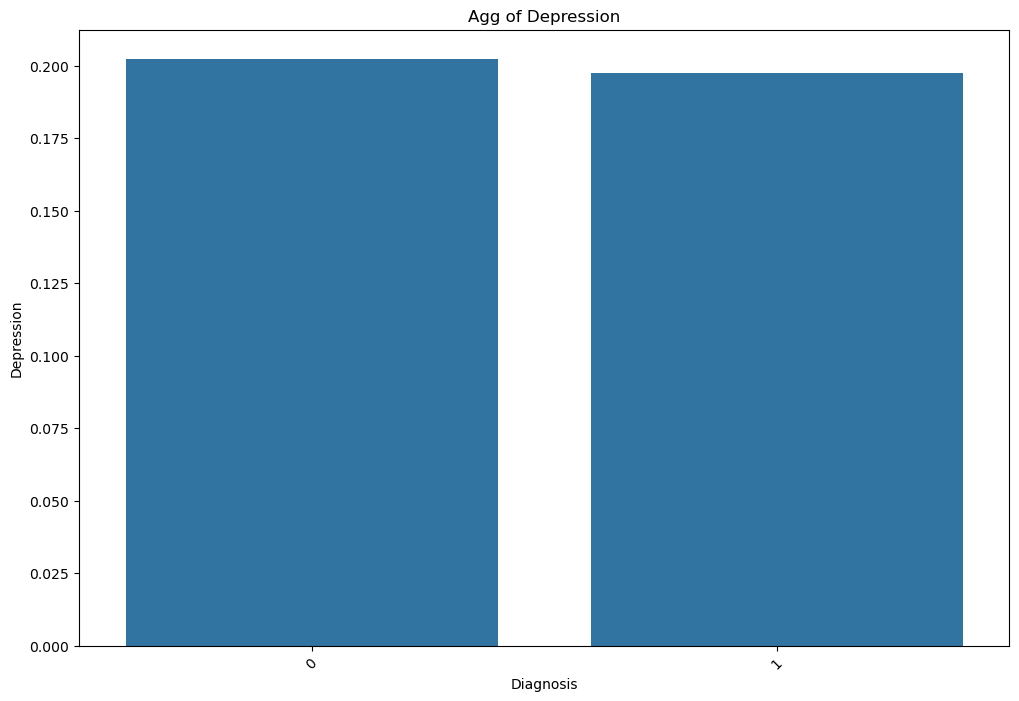

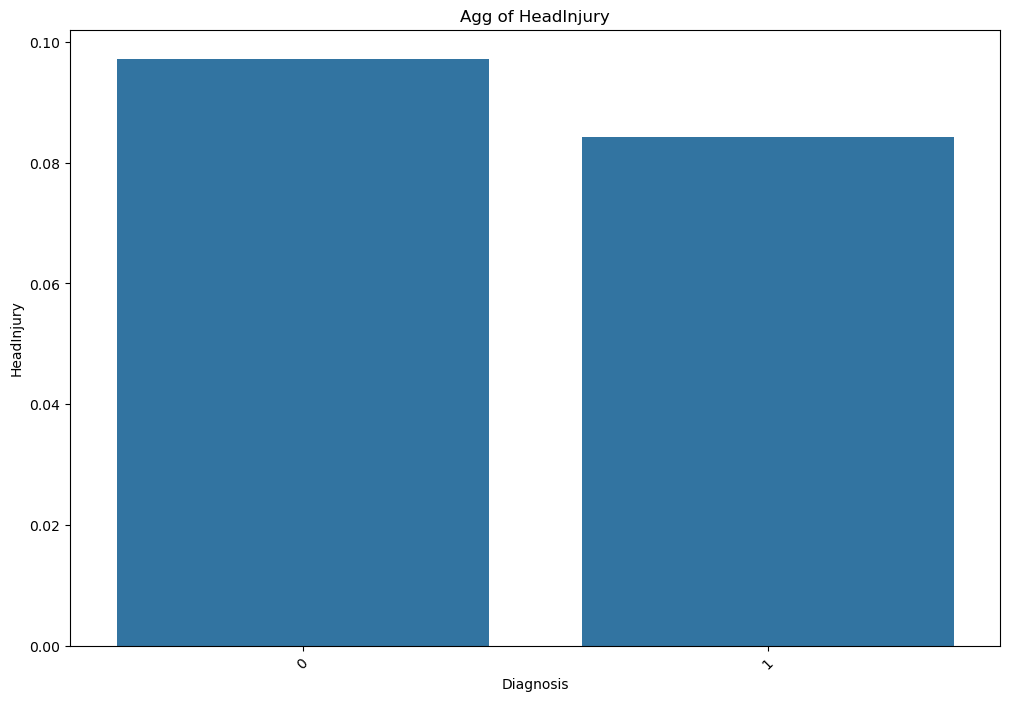

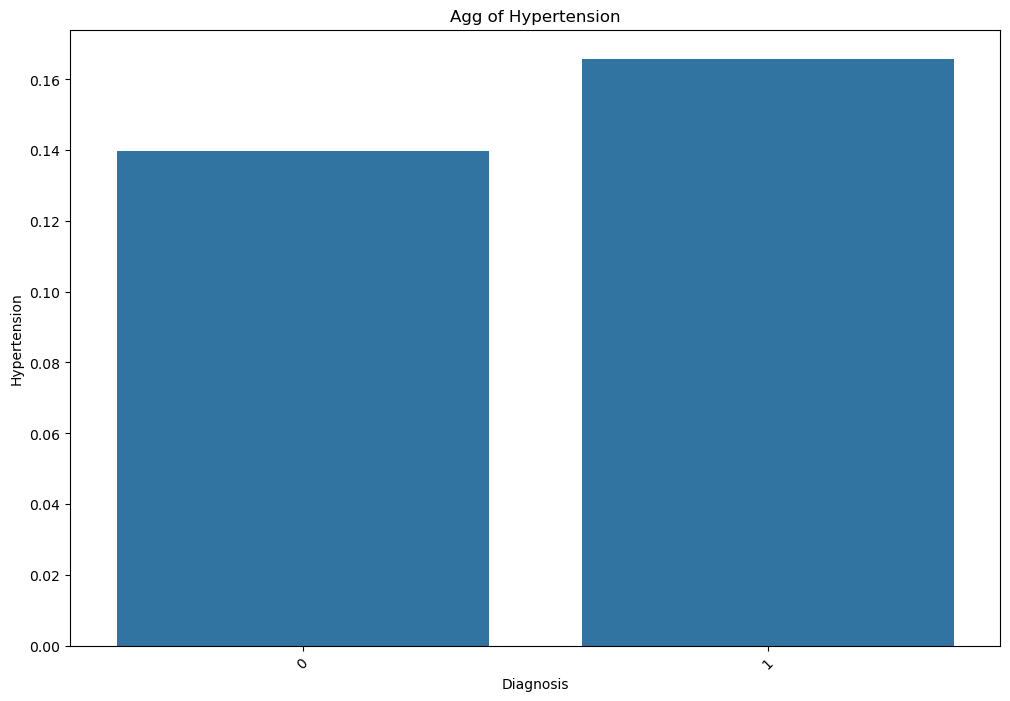

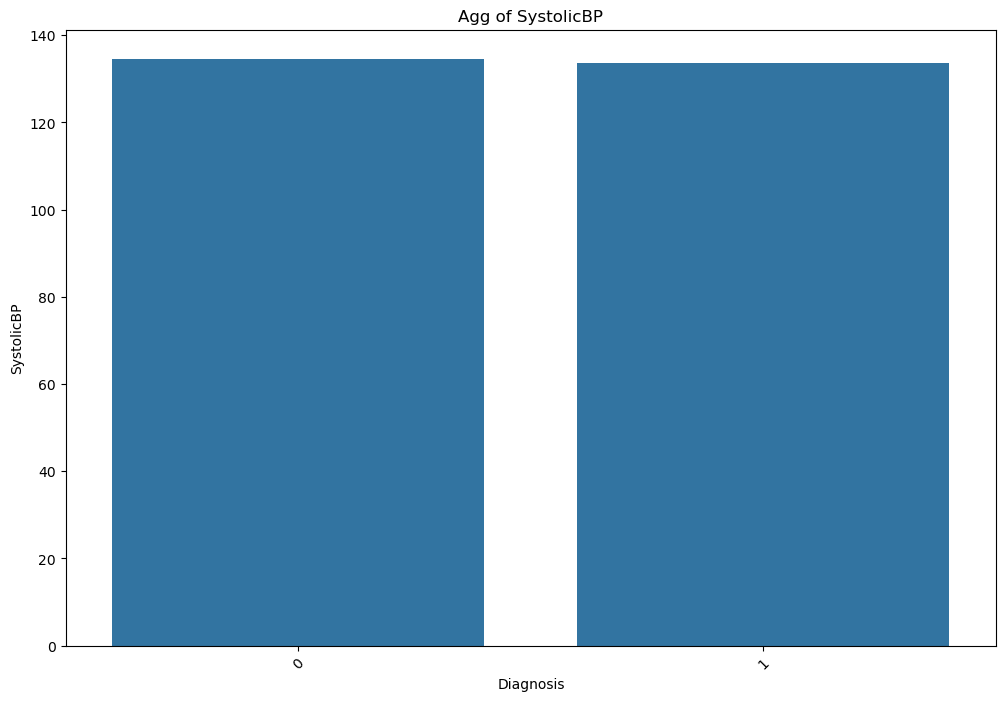

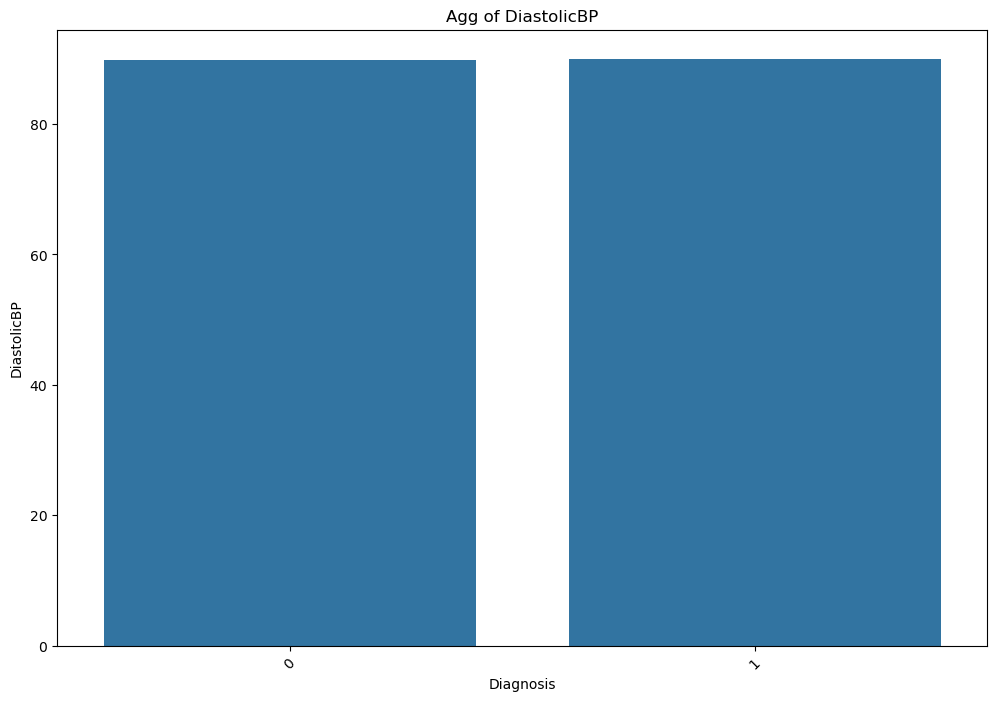

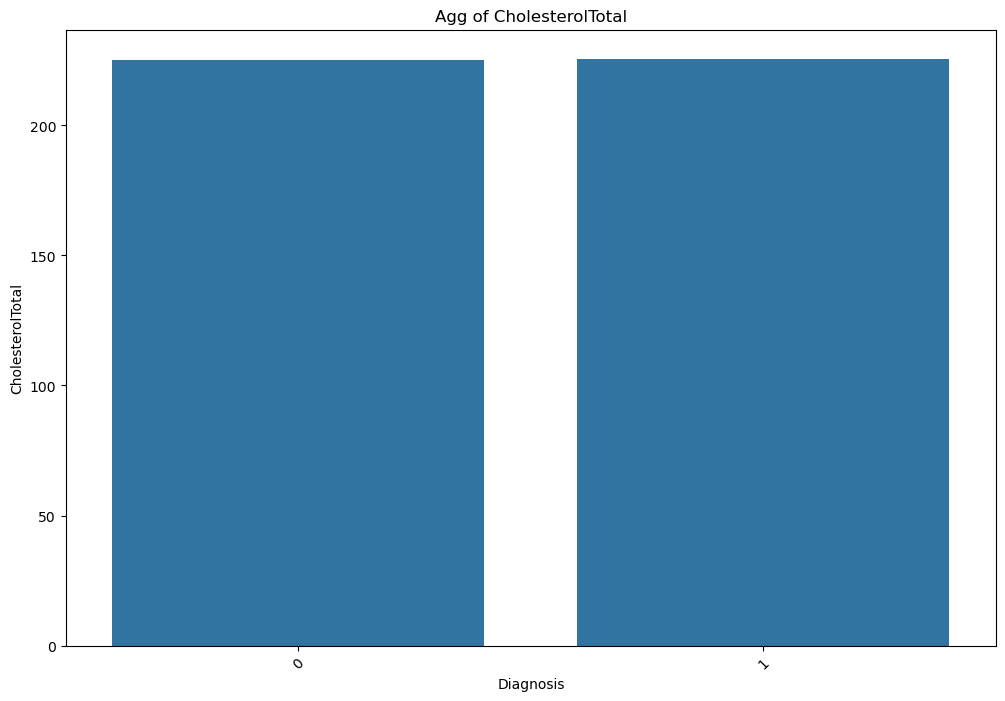

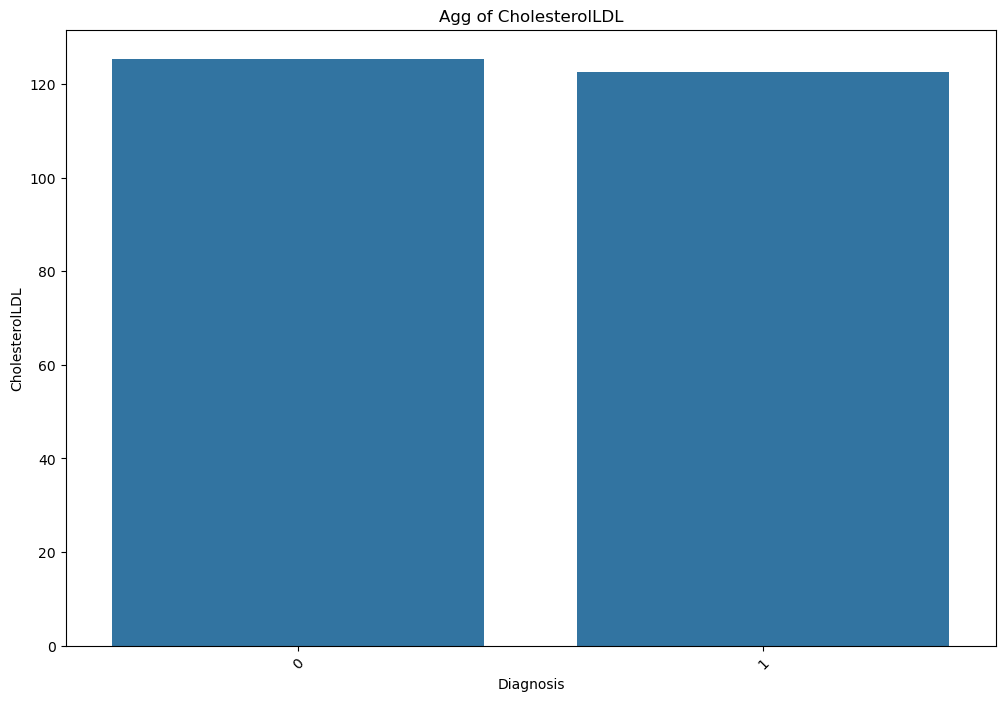

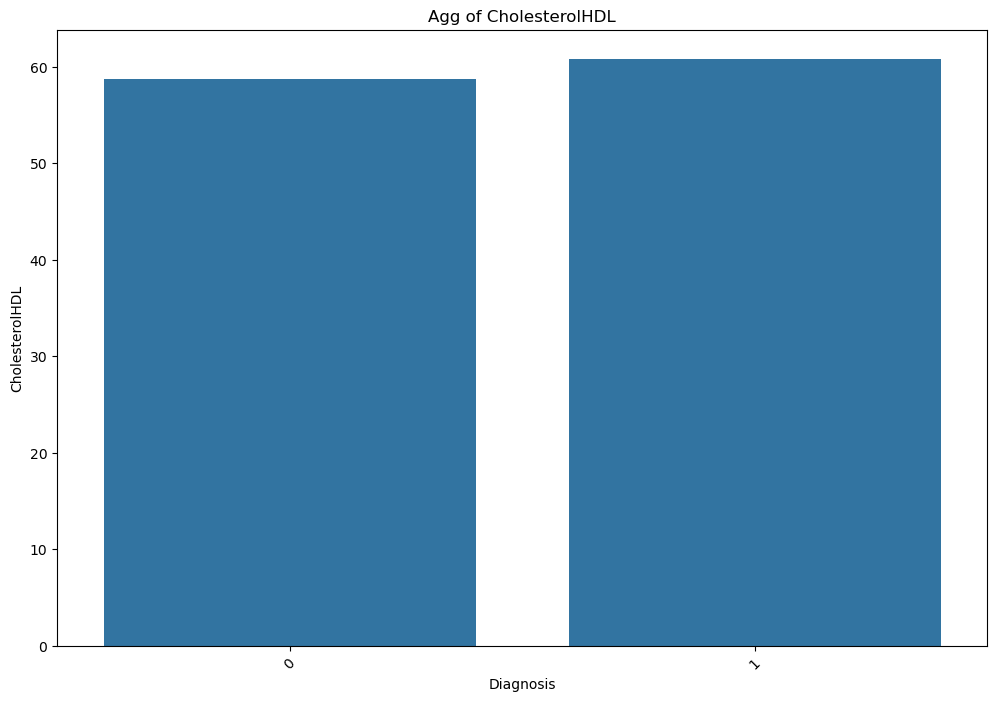

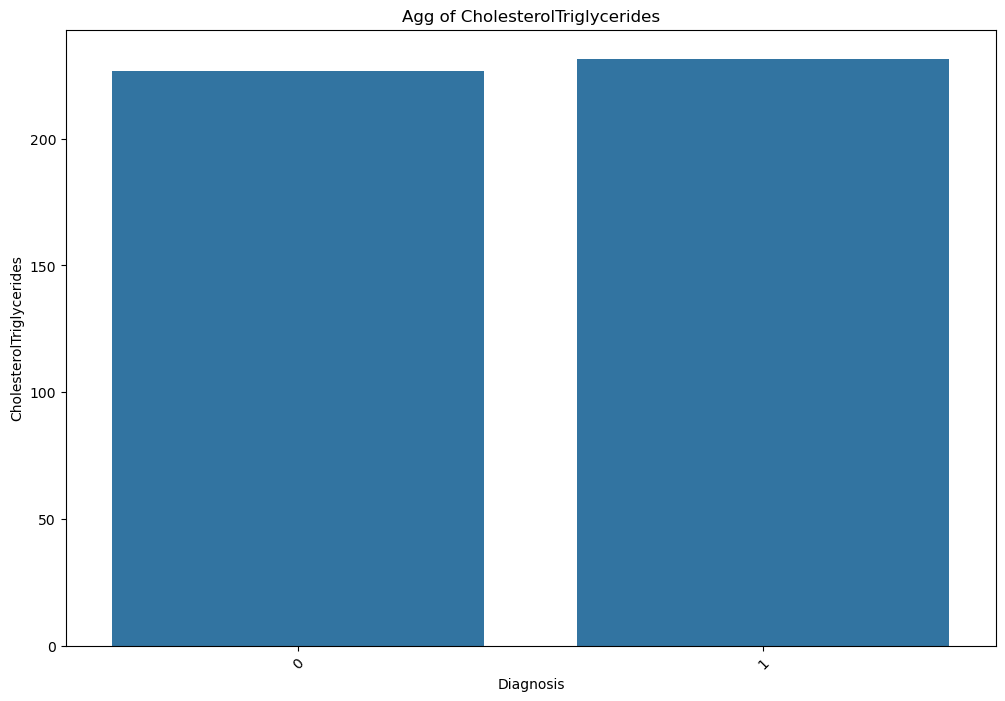

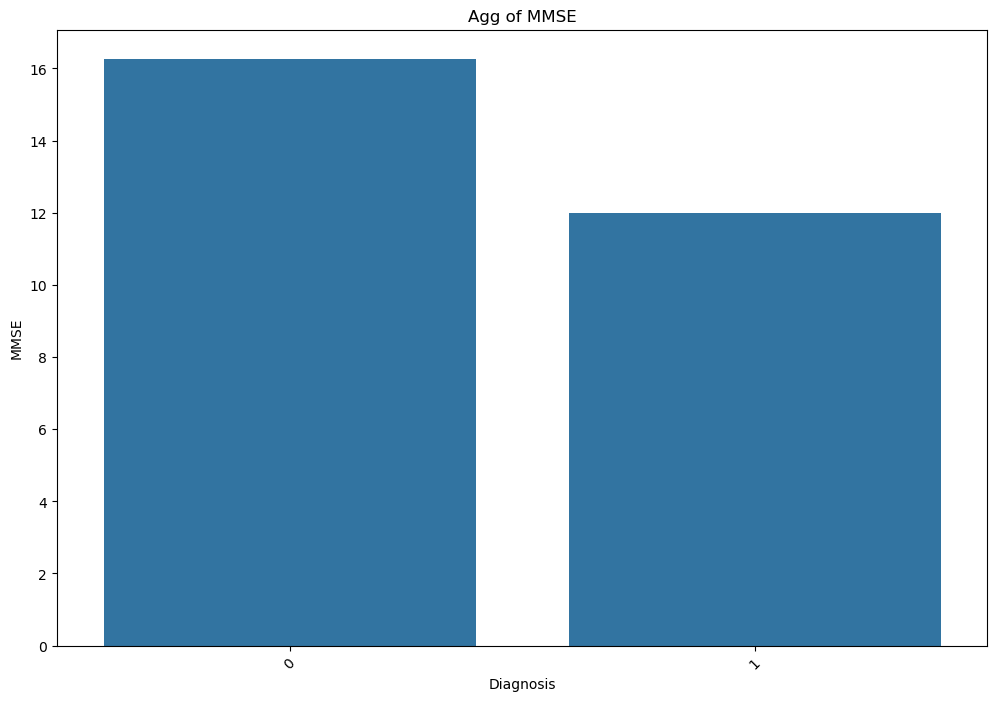

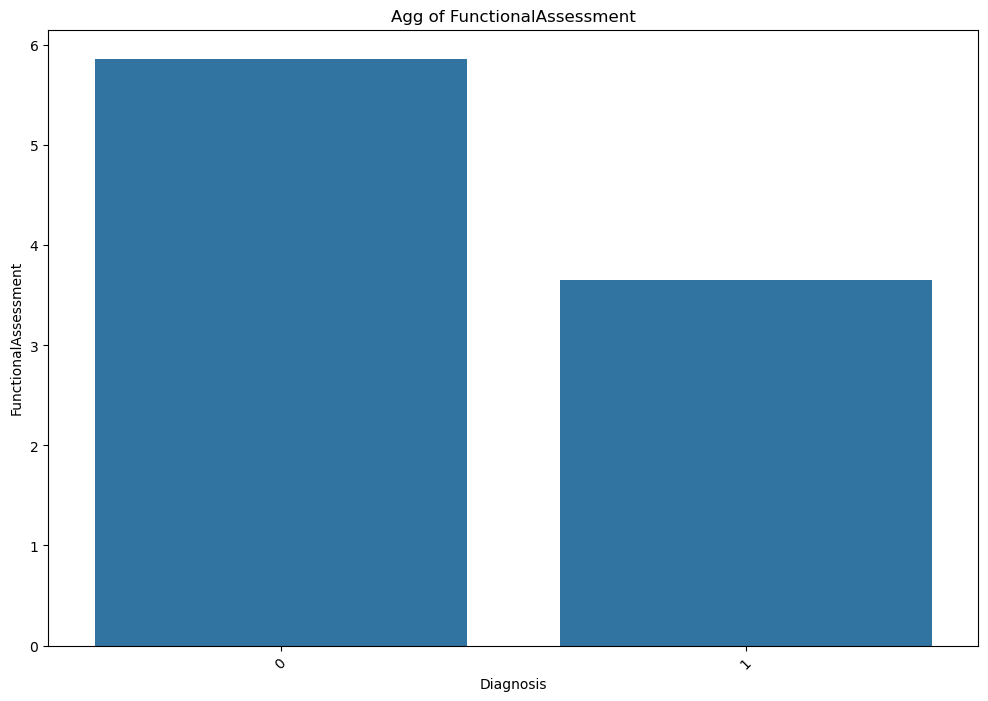

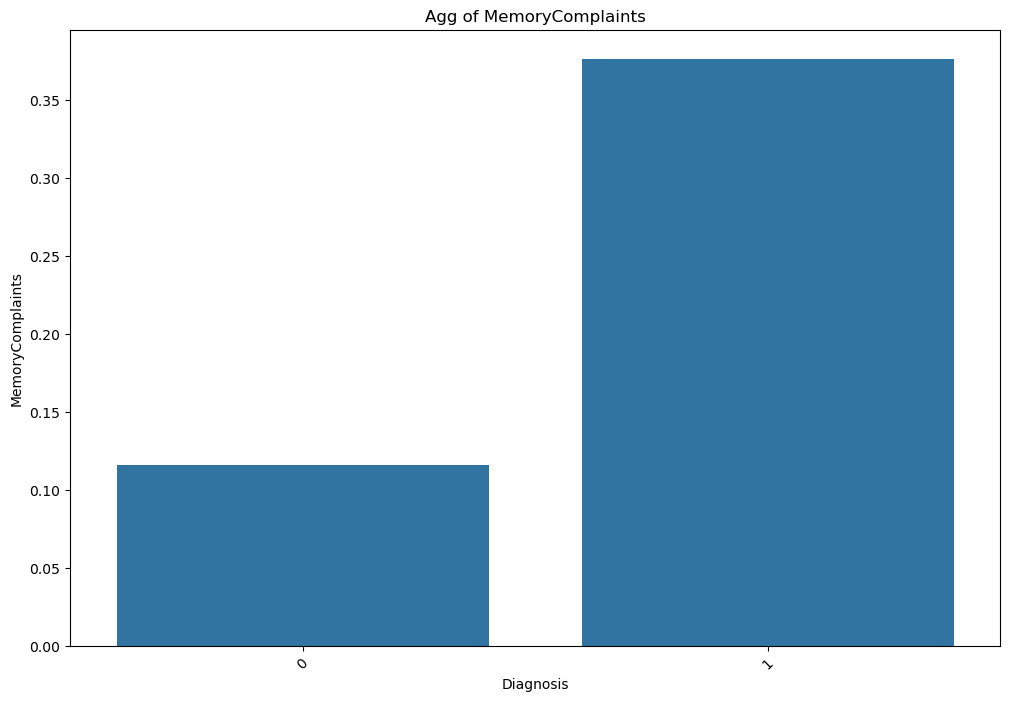

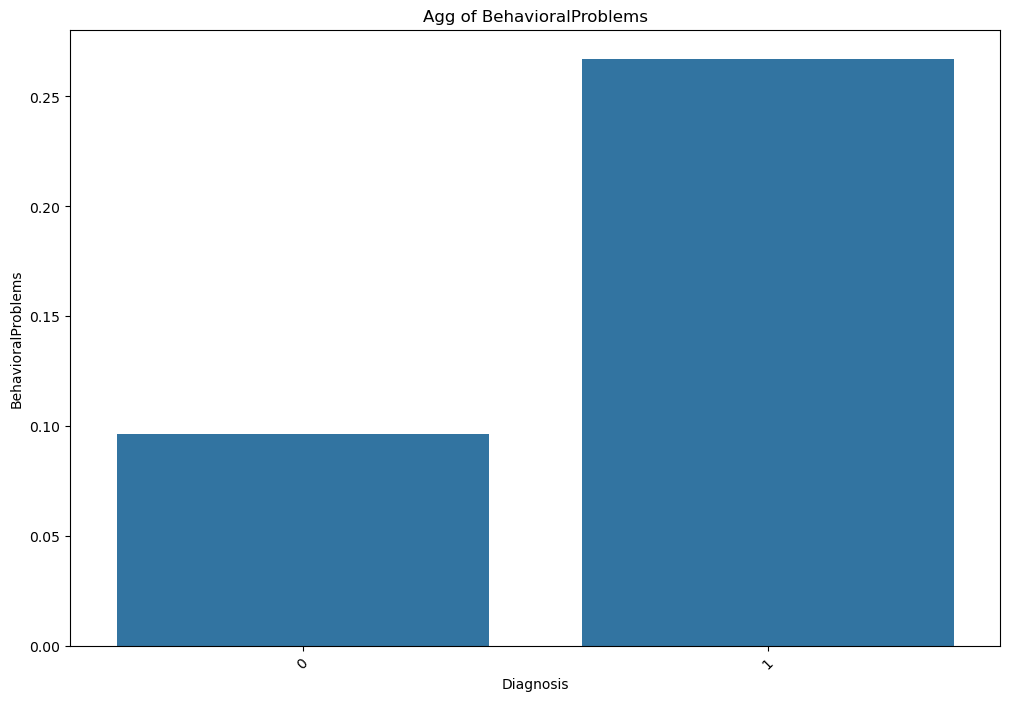

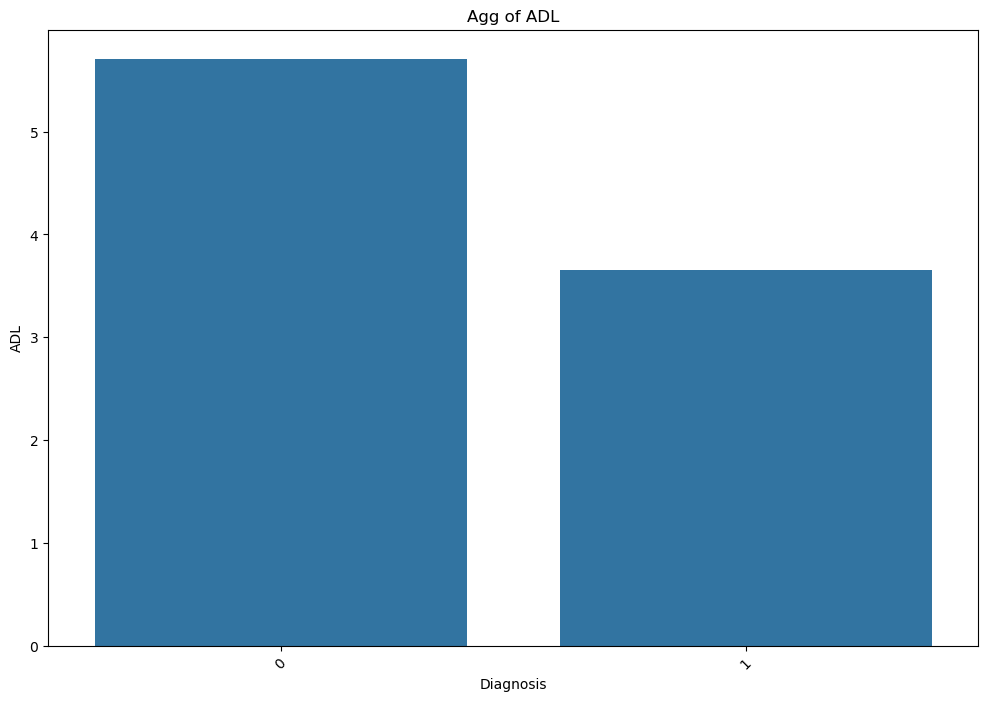

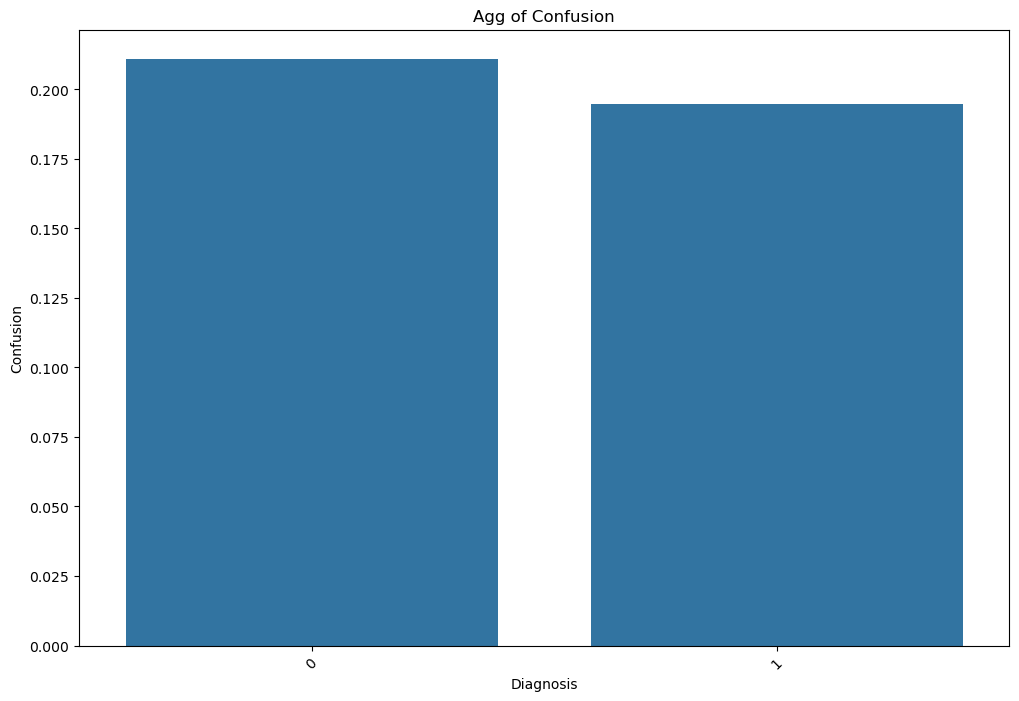

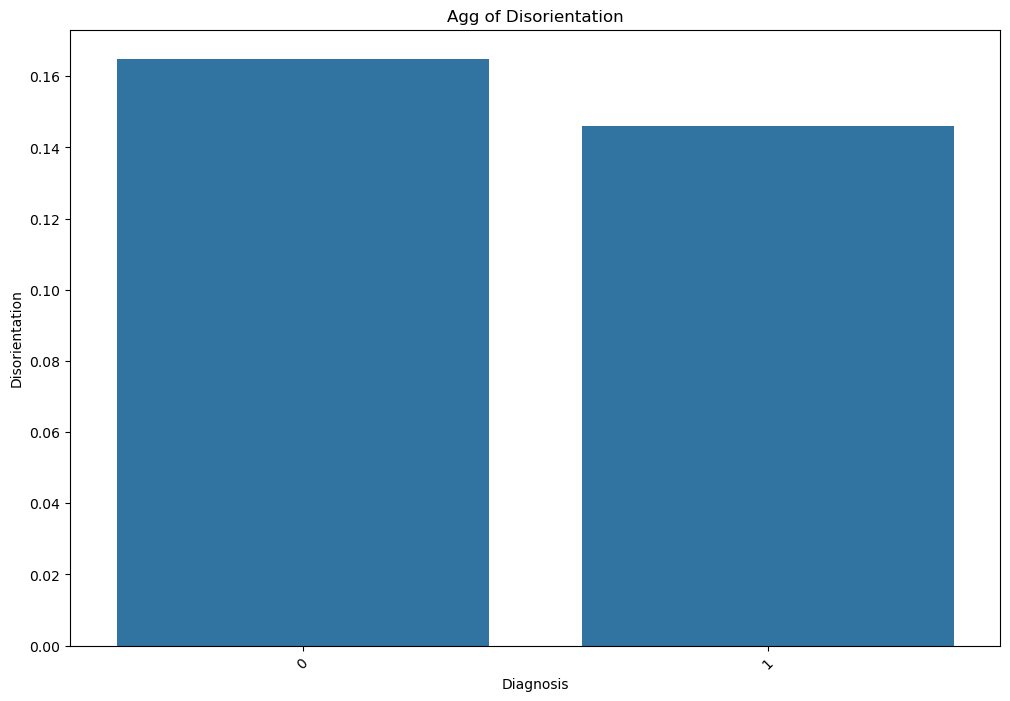

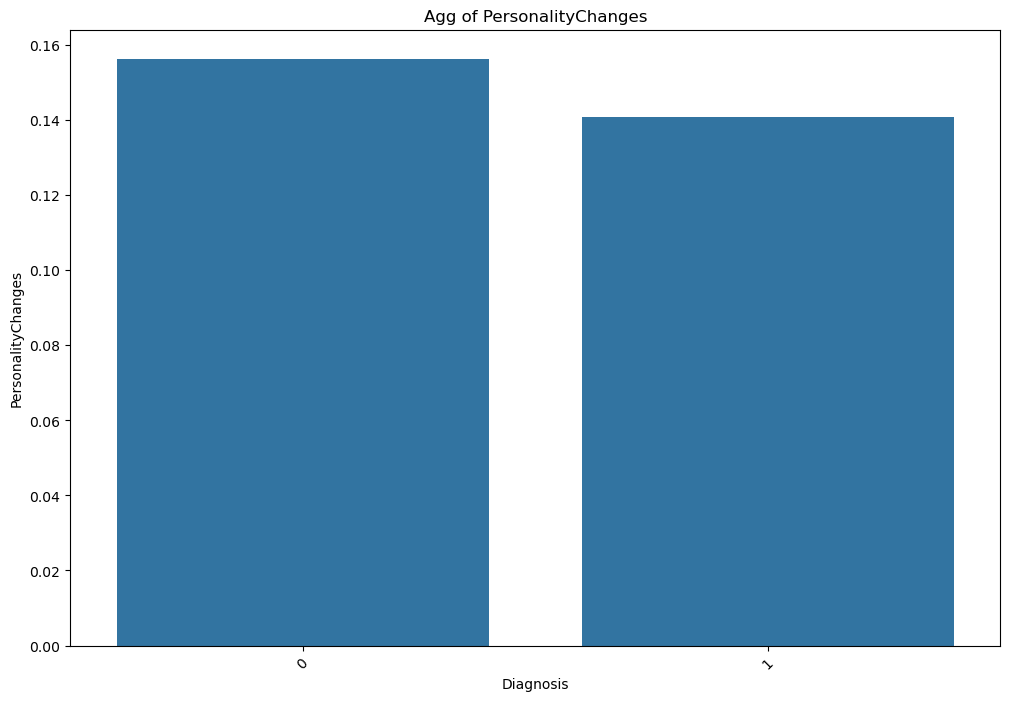

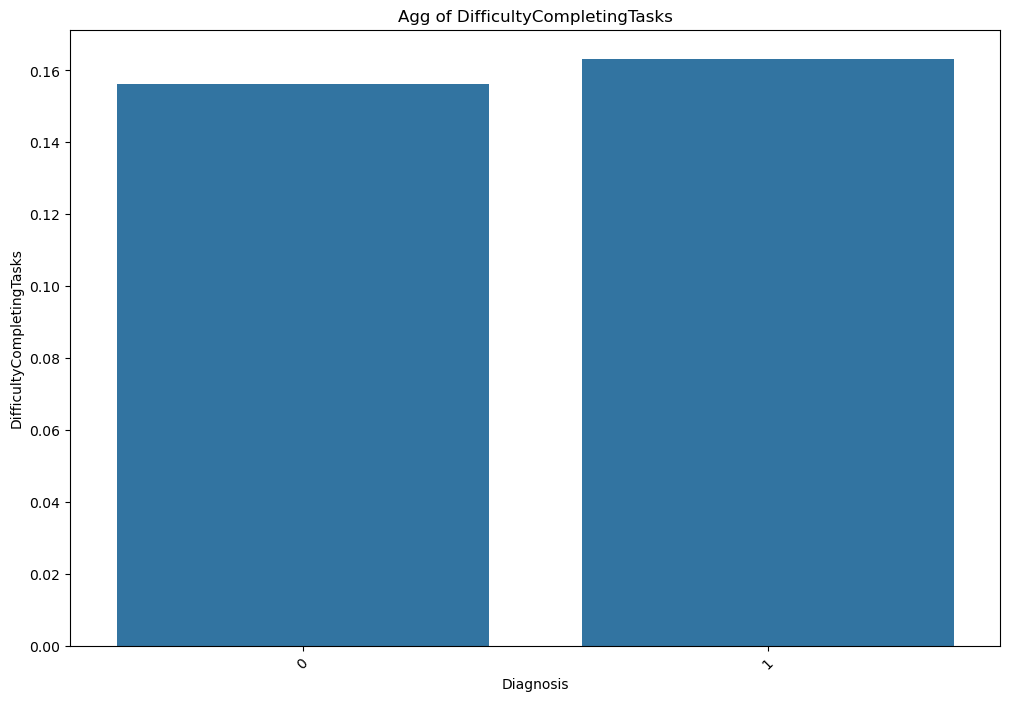

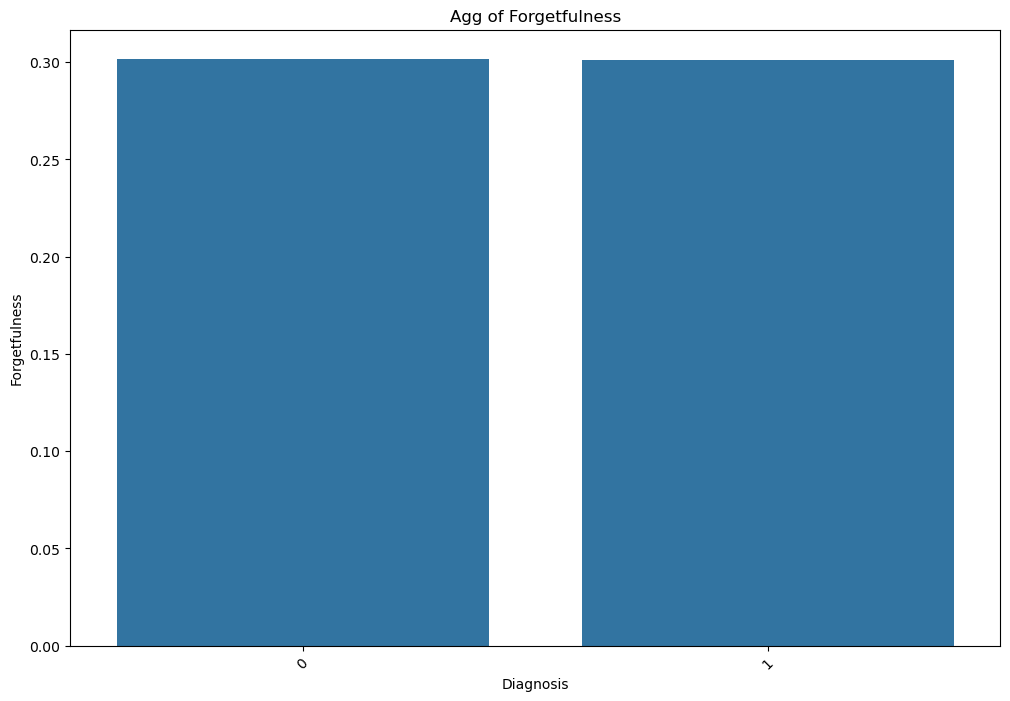

In [65]:
aggregate_dataset(df, interested_columns,"Diagnosis", "mean")

# Separate Features

In [57]:
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# Metrics

In [71]:
acc_metric = make_scorer(accuracy_score, greater_is_better=True)
f1_metric = make_scorer(f1_score, greater_is_better=True, average="weighted")
precision_metric = make_scorer(precision_score, greater_is_better=True, average='weighted')
recall_metric = make_scorer(recall_score, greater_is_better=True, average='weighted')

# Baseline Model Performance

In [72]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
sample_model = SMOTE()
test_selected_models(sample_model, model_name, models, X, y, acc_metric)

   Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
0  DUMMY  0.498  0.001  0.035     0.511         0.511            0.551   

   F1-Score  
0     0.522  


In [73]:
model_name = ["DUMMY"]
models = grab_selected_models(model_name)
sample_model = SMOTE()
test_selected_models(sample_model, model_name, models, X, y, f1_metric)

   Model   Mean    Var    STD  Test-Acc  recall-Score  precision-Score  \
0  DUMMY  0.508  0.001  0.033     0.512         0.512            0.559   

   F1-Score  
0     0.523  


# PCA Analysis

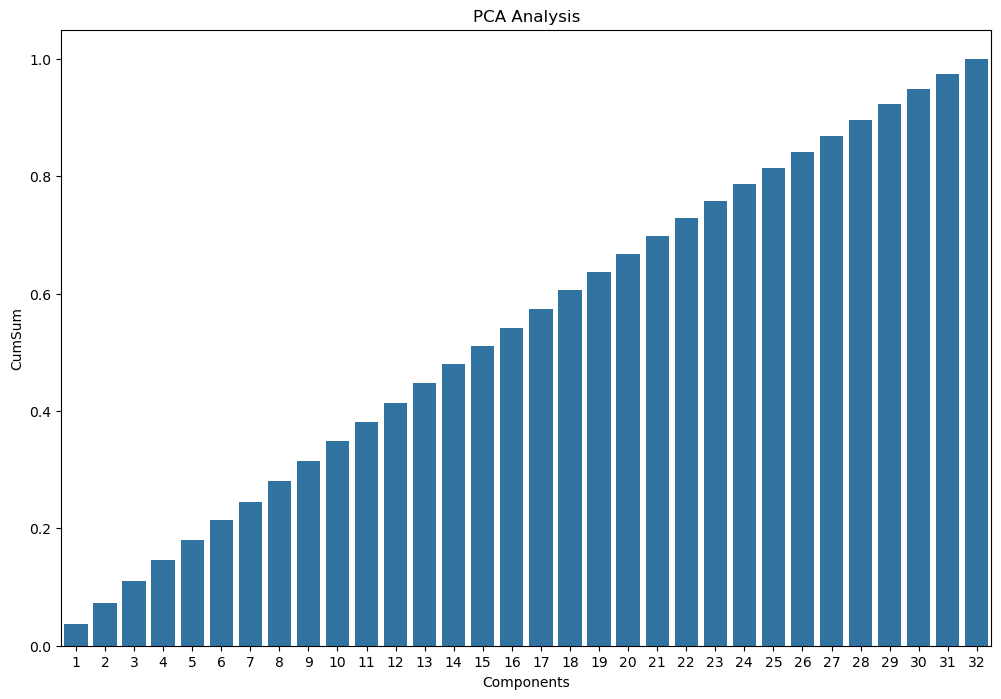

    Component    CumSum
0           1  0.037274
1           2  0.073618
2           3  0.110634
3           4  0.146002
4           5  0.180551
5           6  0.214721
6           7  0.245590
7           8  0.281073
8           9  0.315009
9          10  0.348885
10         11  0.380528
11         12  0.414429
12         13  0.447728
13         14  0.479667
14         15  0.510051
15         16  0.542247
16         17  0.574725
17         18  0.605809
18         19  0.637208
19         20  0.668251
20         21  0.698439
21         22  0.728913
22         23  0.757754
23         24  0.786223
24         25  0.814341
25         26  0.842194
26         27  0.869379
27         28  0.896294
28         29  0.922983
29         30  0.949163
30         31  0.974927
31         32  1.000000


In [58]:
pca_analysis(X)

# Select Kbest Columns